In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score,
                             confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay,
                             roc_curve, auc, roc_auc_score, classification_report)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

In [33]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

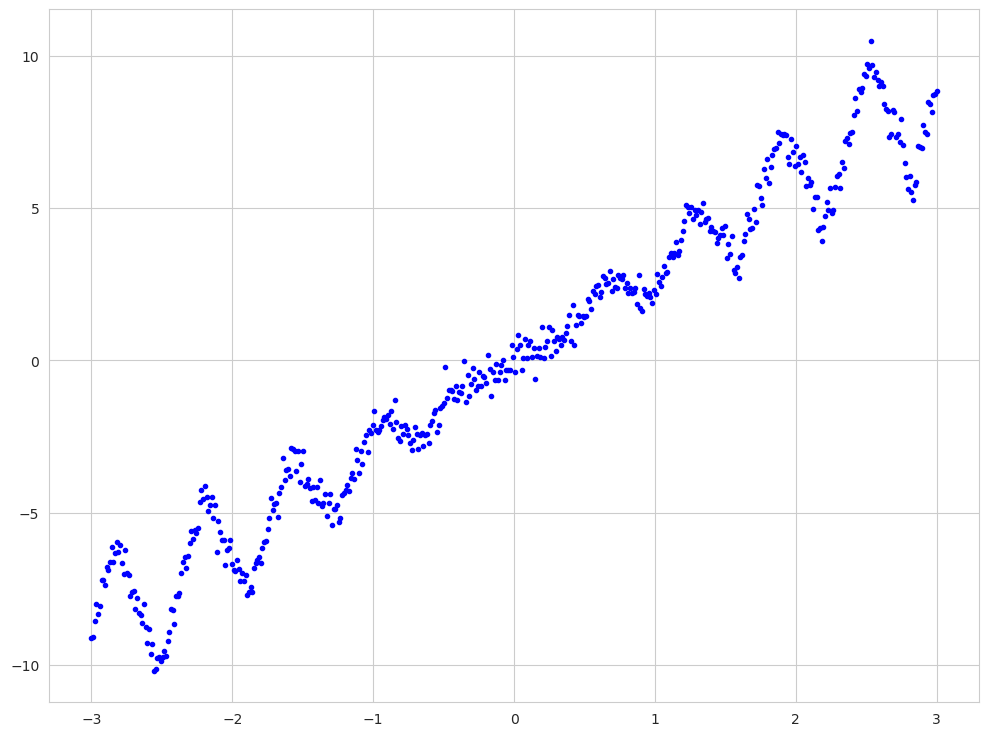

In [39]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 500
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [40]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1, y)

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

In [2]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [41]:
def plot_reg_pred_depth(max_depth, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    fig, axs = plt.subplots(nrows=6, ncols=3, sharex=True, sharey=True, figsize=(10, 20), dpi=300)
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    
    for depth, ax in zip(max_depth, axs.flat):
        # creating a model and predicting y
        dec_tree_reg = DecisionTreeRegressor(max_depth=depth, random_state=SEED)
        dec_tree_reg.fit(X, y)
        y_pred = dec_tree_reg.predict(x1)
        
        # plotting
        ax.axis(axes)
        ax.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$", color="steelblue")
        ax.plot(X, y, linewidth=1, label="fit", color="lightseagreen", alpha=0.7)
        ax.set_xlabel("$x_1$", fontsize=18)
        if ylabel:
            ax.set_ylabel(ylabel, fontsize=16, rotation=0)
        ax.set_title(f"Max Depth = {depth}", fontweight='bold')
        ax.legend()
    
    fig.suptitle("Decision Tree Regression with different max depth", fontsize=18, 
                 fontweight="bold", y=1)
    plt.tight_layout()

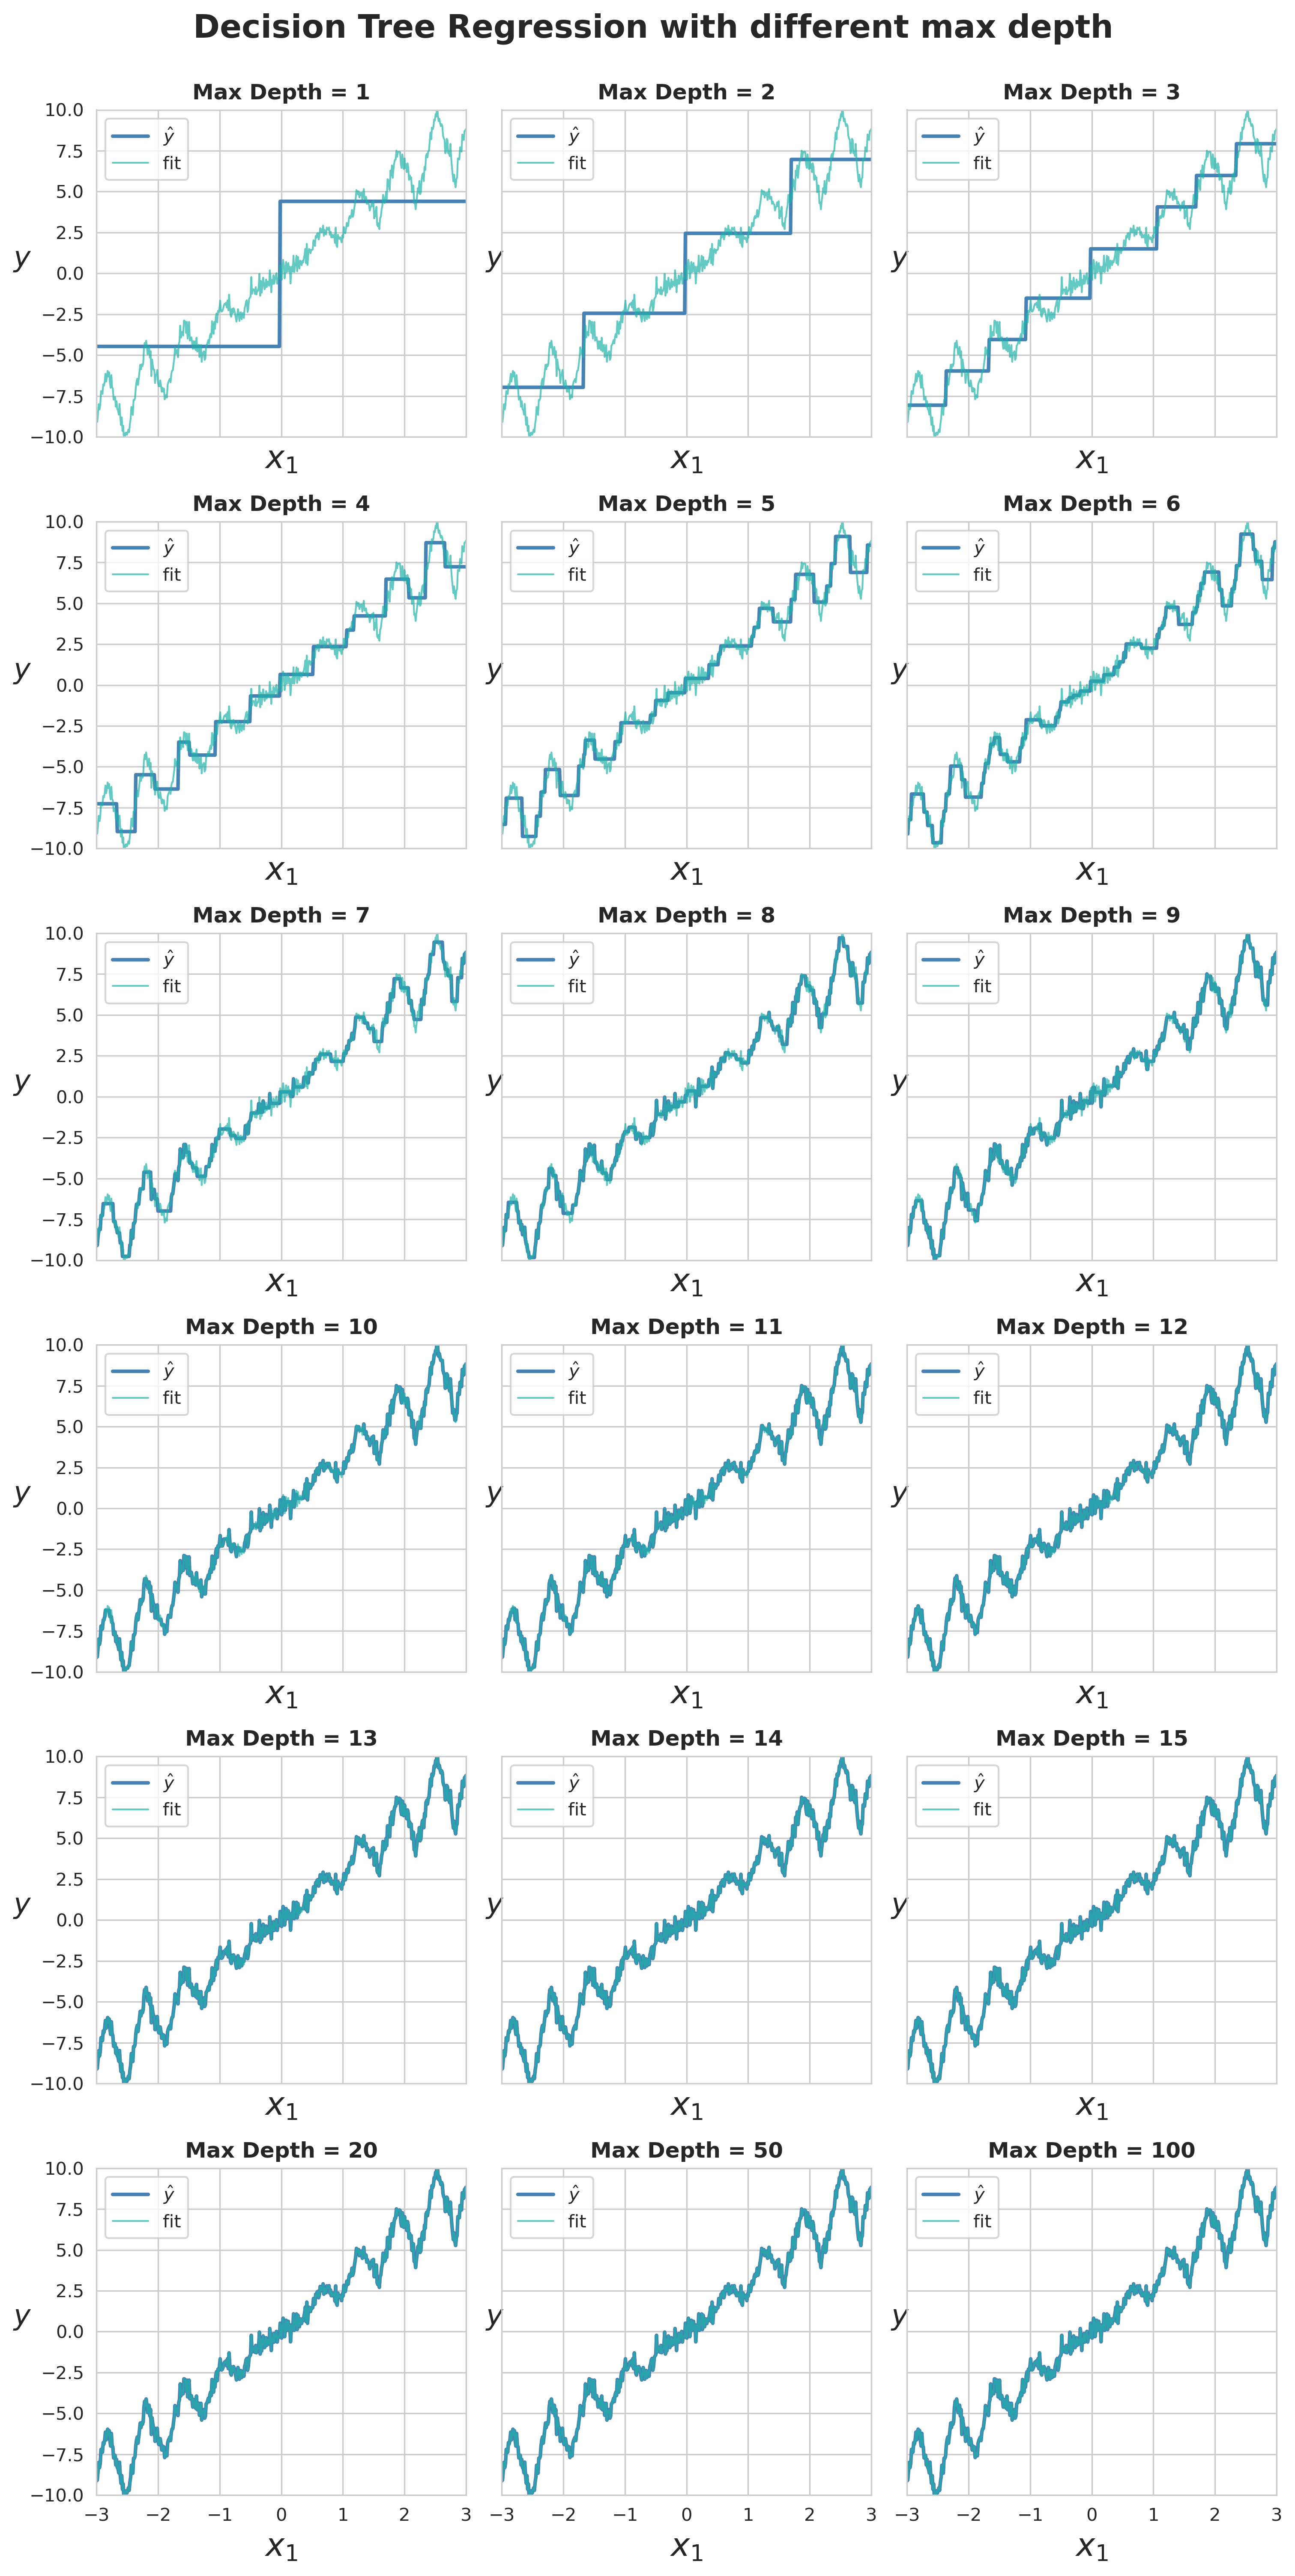

In [42]:
max_depth = list(range(1, 16)) + [20, 50, 100]
plot_reg_pred_depth(max_depth, X, y)

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [98]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

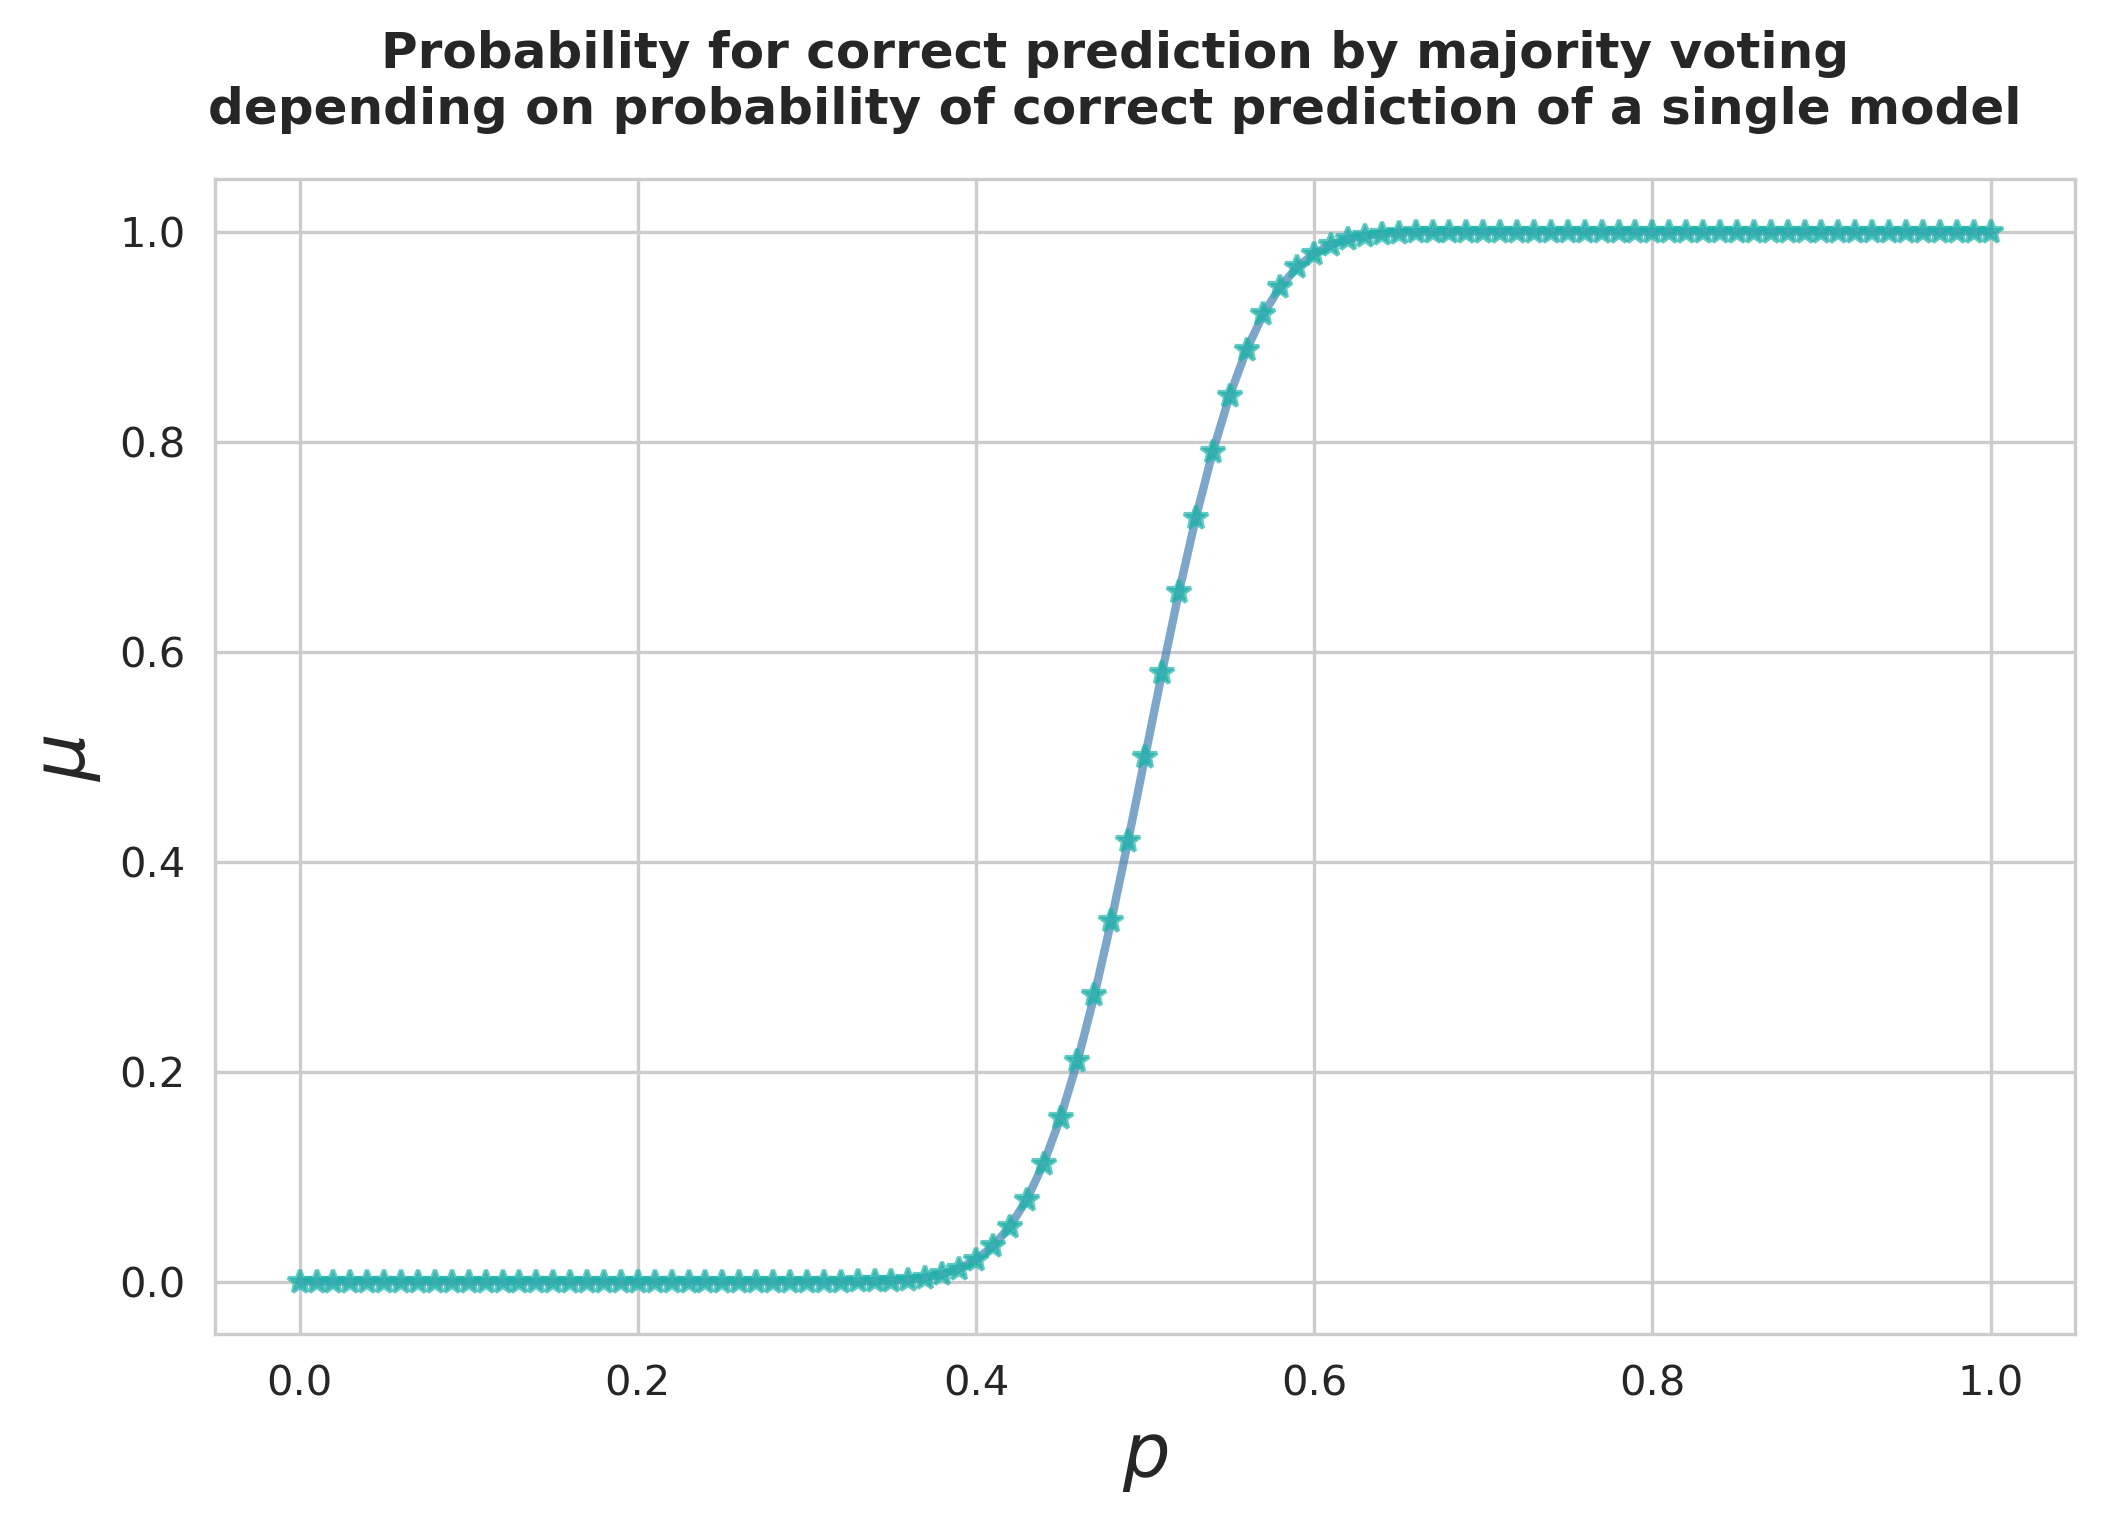

In [43]:
p_values = np.arange(0, 1.01, 0.01)
max_i = 101
min_i = 51
i_ = list(range(min_i, max_i+1))
mu = list(sum(math.comb(max_i, i) * p**i * (1 - p)**(max_i - i) for i in i_) for p in p_values)

fig, ax = plt.subplots(figsize=(8,5), dpi=300)
ax.plot(p_values, mu, linewidth=2, color="steelblue", alpha=0.7, marker="*", markersize=6, mec="lightseagreen", mfc="lightseagreen")
ax.set_xlabel("$p$", fontsize=18, fontweight="bold")
ax.set_ylabel("$\mu$", fontsize=18, fontweight="bold")
fig.suptitle("Probability for correct prediction by majority voting\ndepending on probability of correct prediction of a single model", 
             fontsize=12, fontweight="bold");

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [4]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

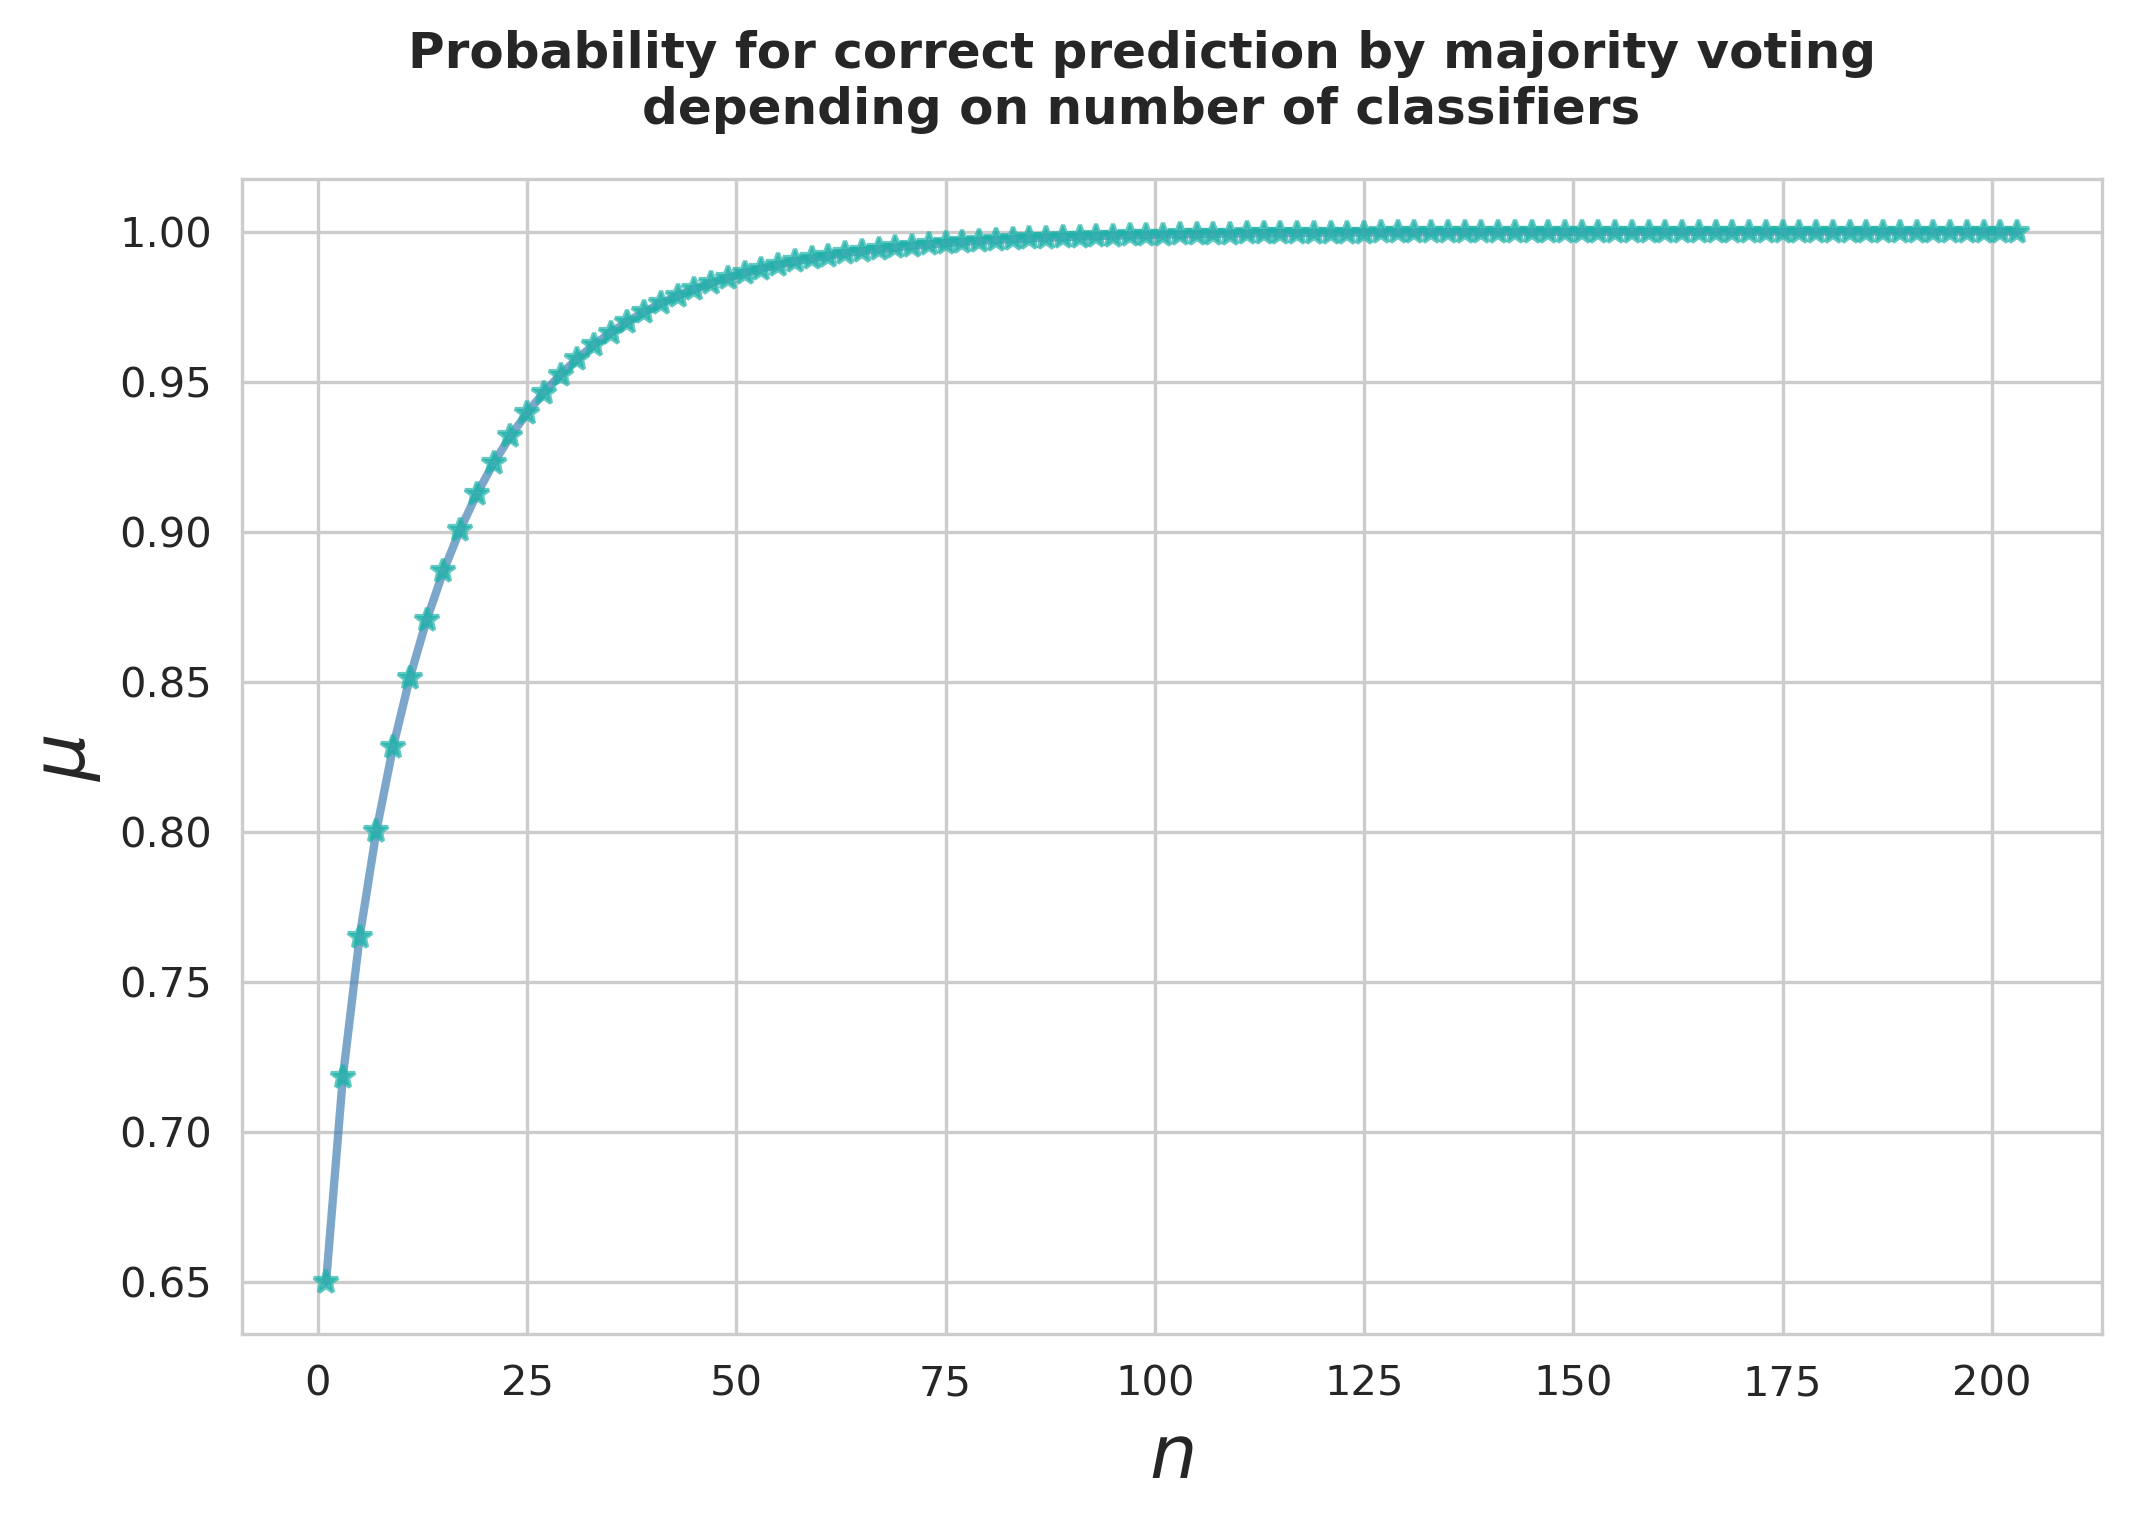

In [131]:
p_value = 0.65
n_classifiers = list(range(1, 205, 2))
mu = list(sum(math.comb(n, i) * p_value**i * (1 - p_value)**(n - i) for i in list(range(n // 2 + n % 2, n + 1))) for n in n_classifiers)

fig, ax = plt.subplots(figsize=(8,5), dpi=300)
ax.plot(n_classifiers, mu, linewidth=2, color="steelblue", alpha=0.7, marker="*", markersize=6, mec="lightseagreen", mfc="lightseagreen")
ax.set_xlabel("$n$", fontsize=18, fontweight="bold")
ax.set_ylabel("$\mu$", fontsize=18, fontweight="bold")
fig.suptitle("Probability for correct prediction by majority voting\ndepending on number of classifiers", 
             fontsize=12, fontweight="bold");

Опишите ваши наблюдения:

* for majority voting, it performs pretty good if probability for correct prediction by a single model more then 60%
* as we can see, 25 classifiers is enough to build a good model (with >0.95 probability to make correct prediction) and ar least 75 classifiers we need to predict target with ~100% precision

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [8]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        for i in range(0, self.n_estimators):
            # setting seed
            np.random.seed(self.random_state + i)
            
            # selecting n random features 
            self.feat_ids_by_tree.append(np.random.choice(X.shape[1], size=self.max_features, replace=False))
            
            # creating pseudosample using bootstrap
            # random indices for pseudosample
            pseudo_idx = np.random.choice(X.shape[0], size=X.shape[0], replace=True).reshape(X.shape[0], 1)
            pseudo_X = X[pseudo_idx, self.feat_ids_by_tree[i]]
            pseudo_y = y[pseudo_idx]
            
            # creating and fitting model
            dec_tree_class = DecisionTreeClassifier(max_depth=self.max_depth, 
                                                    max_features=self.max_features, 
                                                    random_state=self.random_state)
            dec_tree_class.fit(pseudo_X, pseudo_y)
            
            # appending tree to a list
            self.trees.append(dec_tree_class)
        return self
            
        
    def predict_proba(self, X):
        probs = []
        for i, tree in enumerate(self.trees):
            proba = tree.predict_proba(X[:, self.feat_ids_by_tree[i]])
            probs.append(proba)
        return np.mean(probs, axis=0)
    
    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [9]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

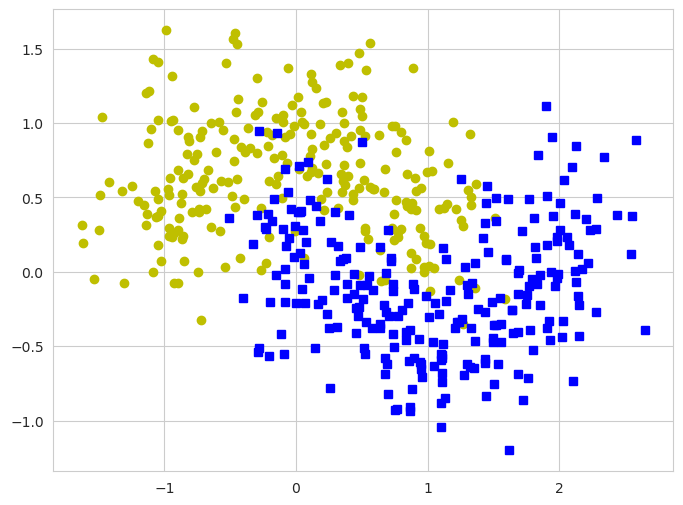

In [29]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [5]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

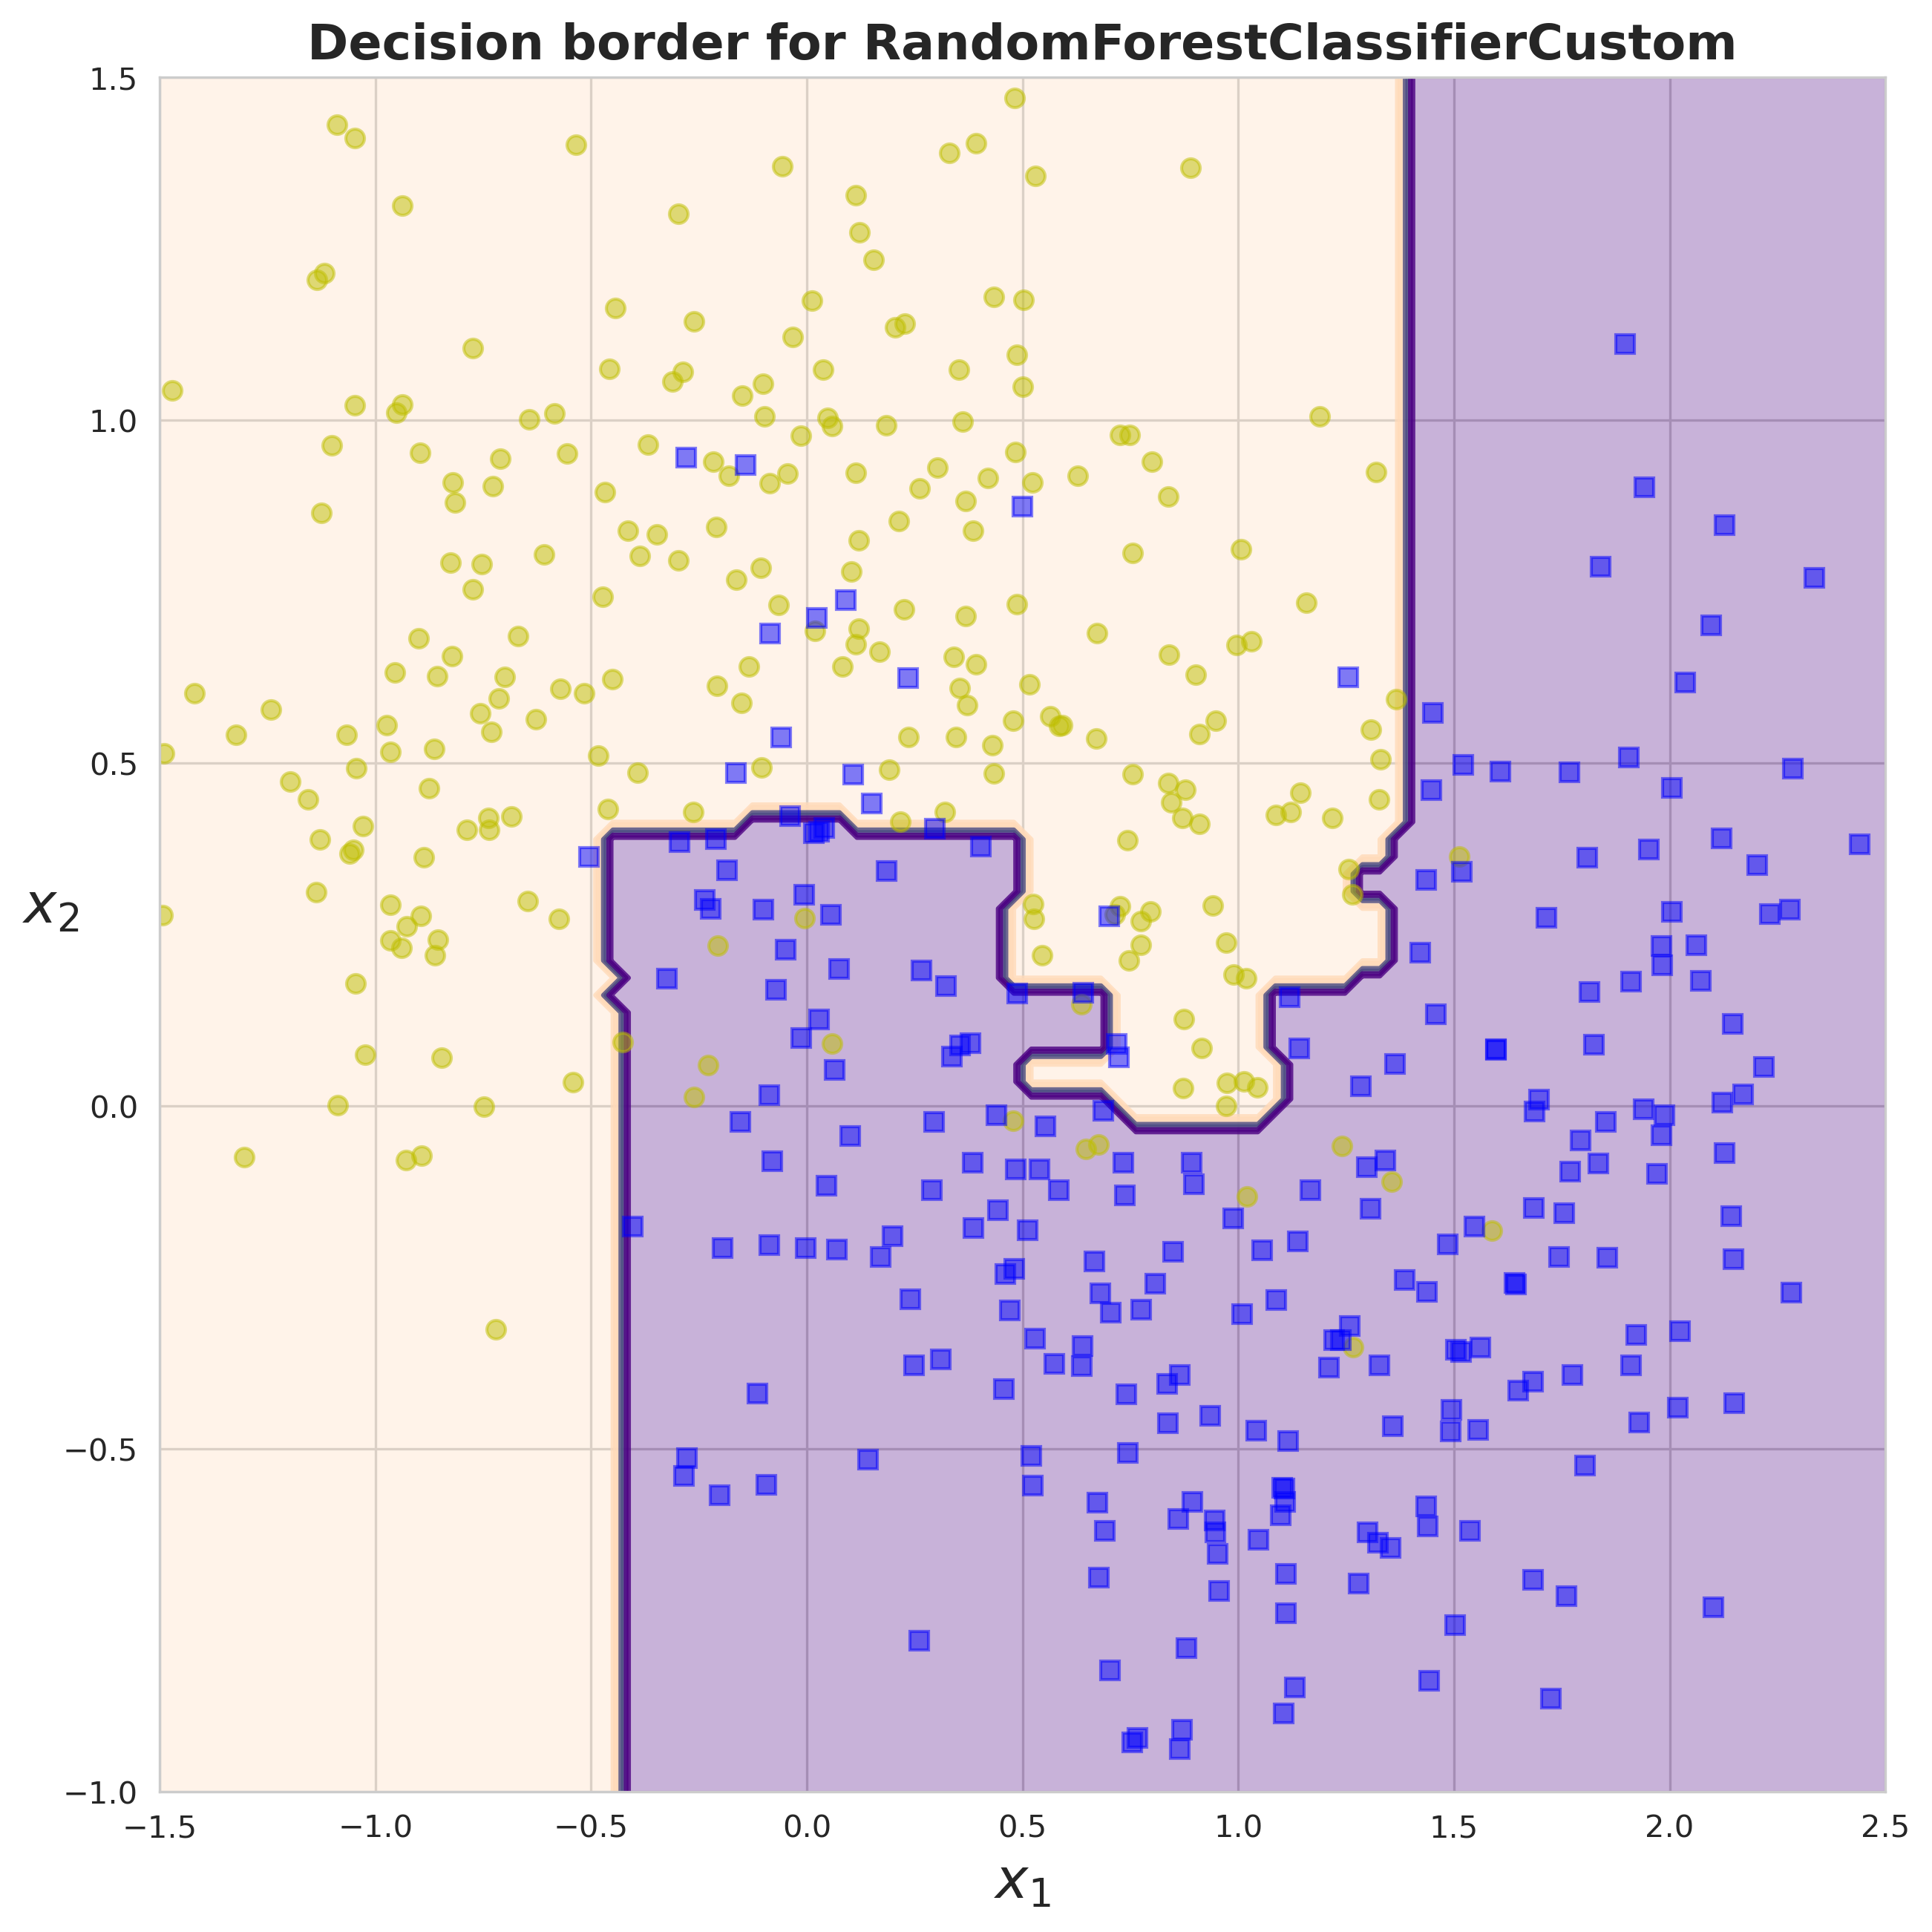

In [30]:
custom_rf = RandomForestClassifierCustom(max_depth=5, max_features=2, random_state=SEED)
custom_rf.fit(X, y)

fig, ax = plt.subplots(figsize=(10,10), dpi=300)
plot_decision_boundary(custom_rf, X, y)
plt.title("Decision border for RandomForestClassifierCustom", fontsize=16, fontweight="bold");

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

Fow this task we have three hyperparameters: **max_depth**, **max_features**, and **n_estimators**. For the best hyperparameters searching, I decided to try `GridSearchCV()` from `sklearn`.

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

parameters = {"n_estimators": list(range(10, 100, 5)) + list(range(100, 1000, 100)),
              "max_depth" : list(range(1, 26)),
              "max_features": [1, 2], # for current task
              "random_state": [SEED]}

param_search = GridSearchCV(estimator=RandomForestClassifierCustom(),
                            param_grid=parameters,
                            scoring="accuracy",
                            n_jobs=-1)

param_search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifierCustom(), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25],
                         'max_features': [1, 2],
                         'n_estimators': [10, 15, 20, 25, 30, 35, 40, 45, 50,
                                          55, 60, 65, 70, 75, 80, 85, 90, 95,
                                          100, 200, 300, 400, 500, 600, 700,
                                          800, 900],
                         'random_state': [111]},
             scoring='accuracy')

In [32]:
param_search.best_params_

{'max_depth': 5, 'max_features': 2, 'n_estimators': 300, 'random_state': 111}

In [33]:
param_search.best_estimator_

RandomForestClassifierCustom(max_depth=5, max_features=2, n_estimators=300)

In [34]:
param_search.best_score_

0.9200000000000002

precision_score: 0.9166666666666666
recall_score: 0.9166666666666666
f1_score: 0.9166666666666666
accuracy_score: 0.92


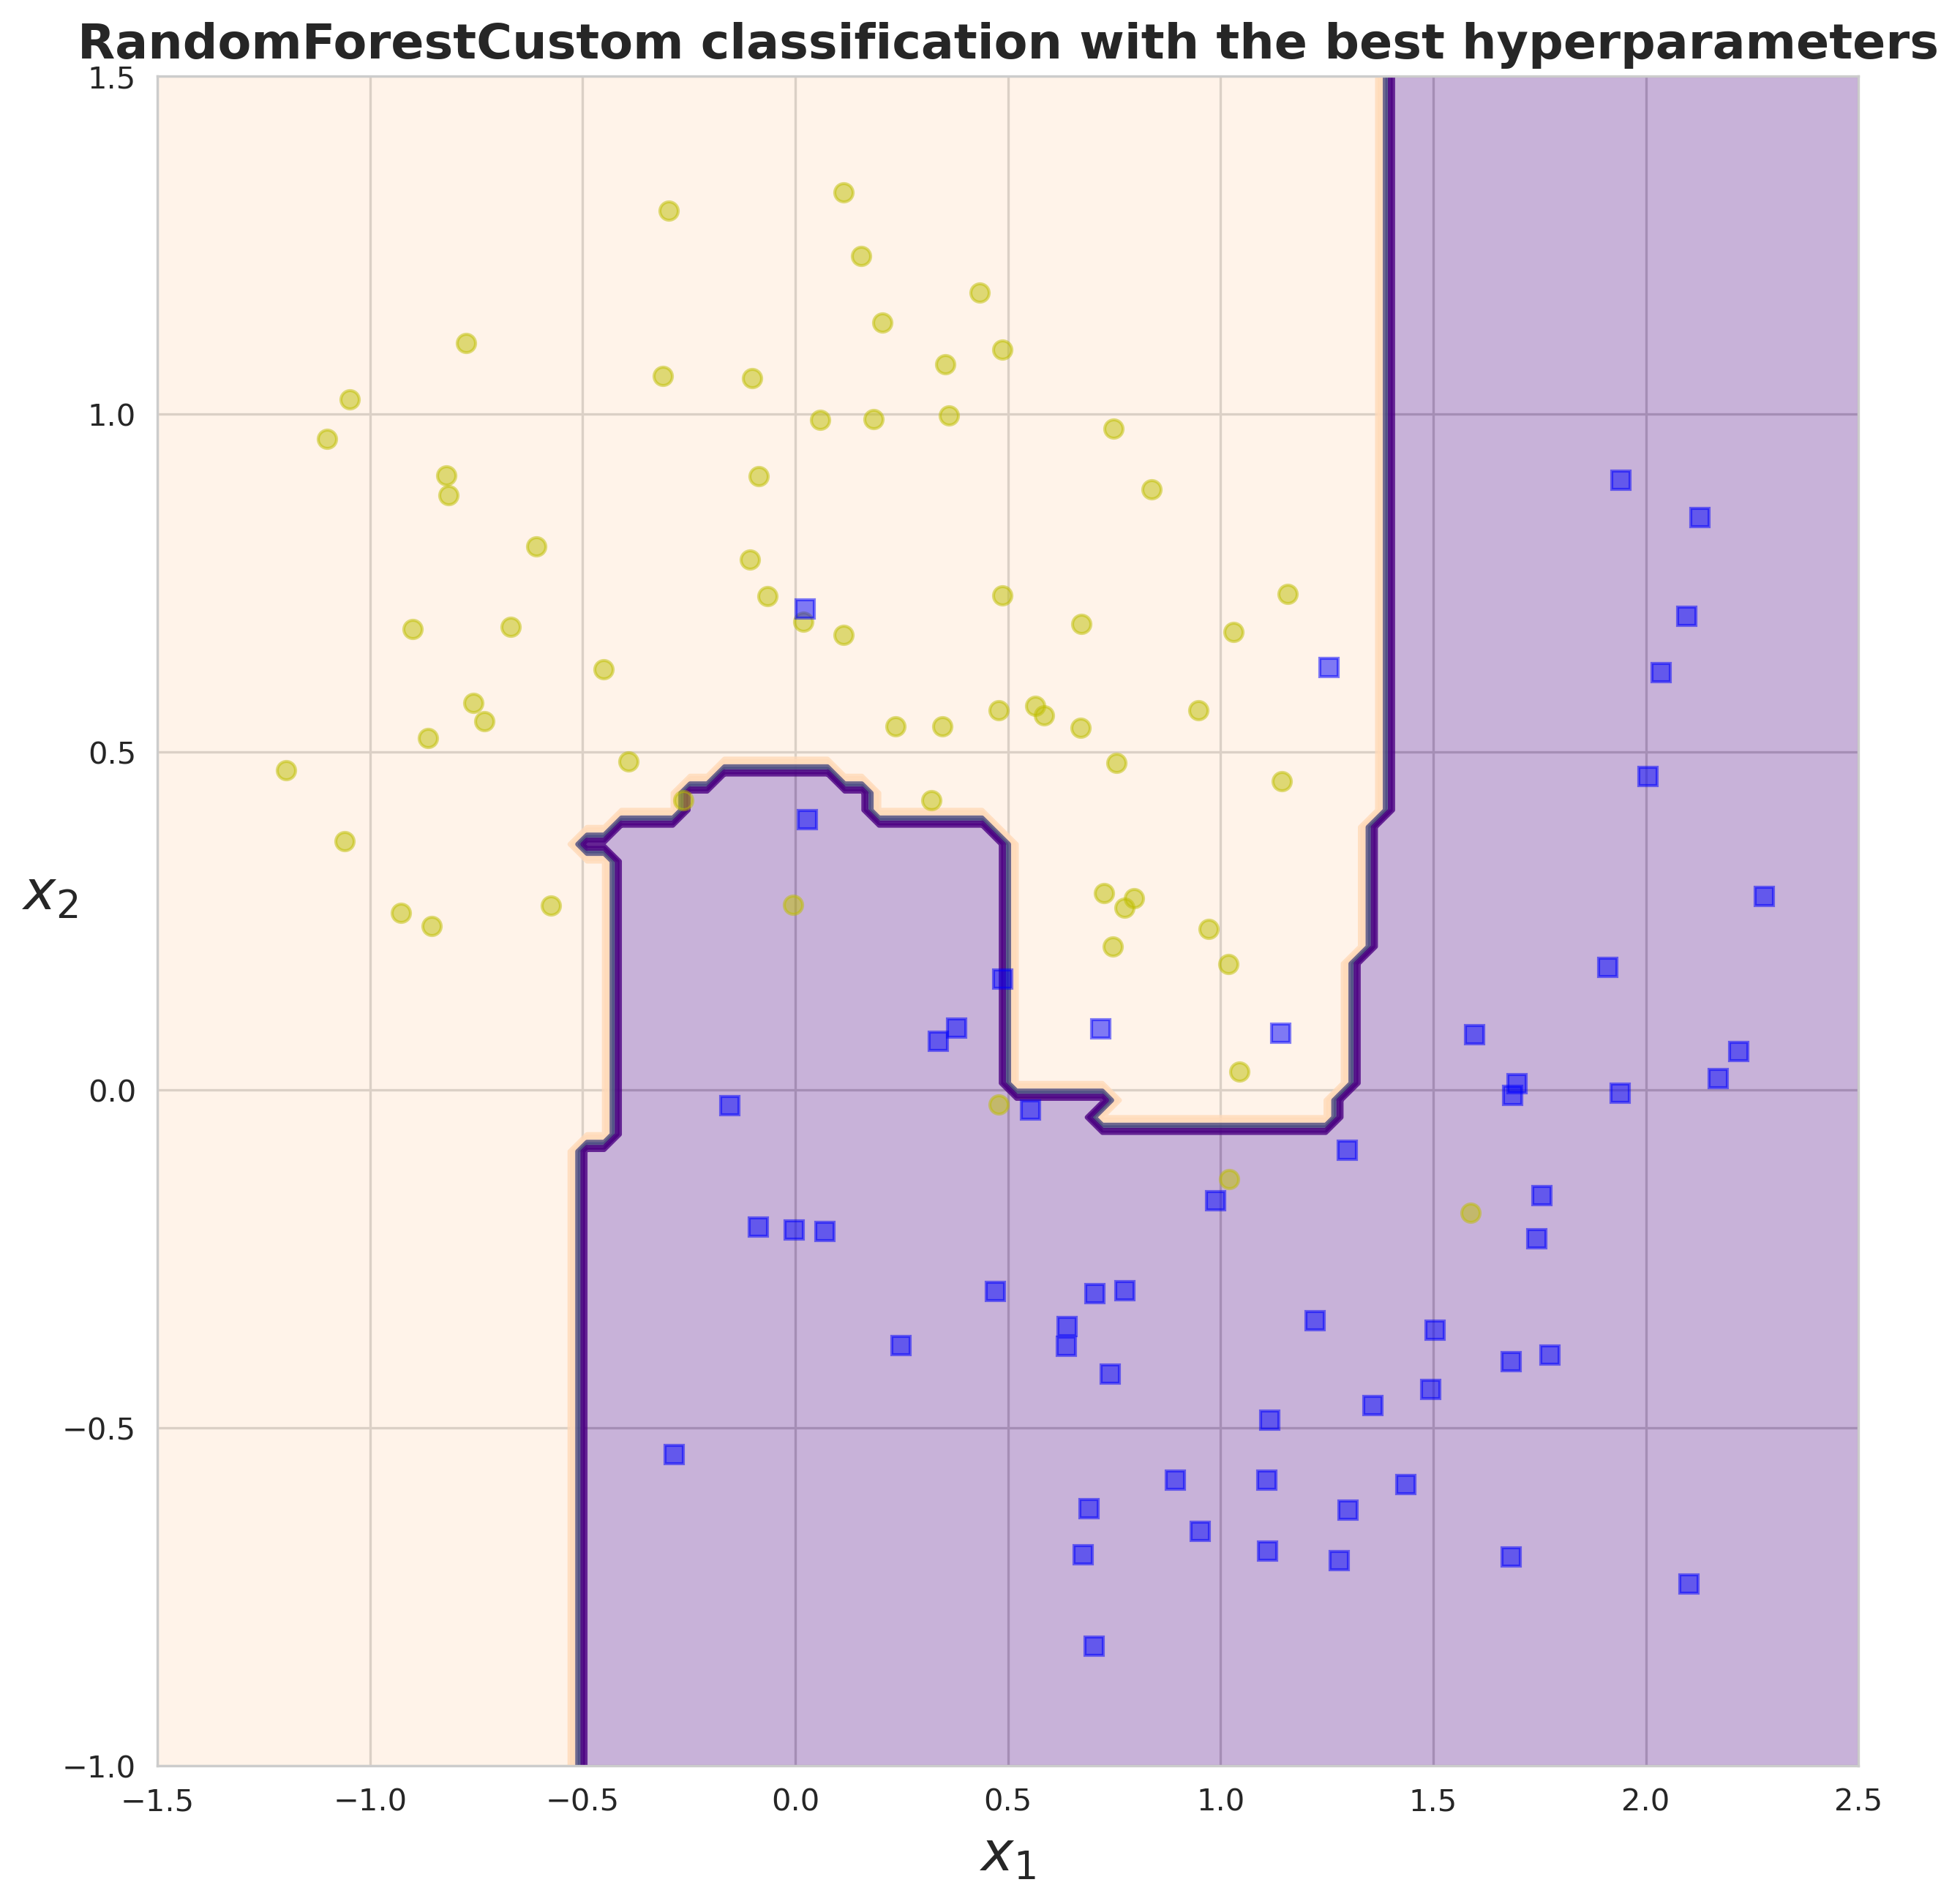

In [35]:
custom_rf = RandomForestClassifierCustom(n_estimators=300, max_depth=5, max_features=2, random_state=SEED)
custom_rf.fit(X_train, y_train)
y_pred = custom_rf.predict(X_test)

metrics=[precision_score, recall_score, f1_score, accuracy_score]
for metric in metrics:
    print(f'{metric.__name__}: {metric(y_test, y_pred)}')

fig, ax = plt.subplots(figsize=(10,10), dpi=300)
plot_decision_boundary(custom_rf, X_test, y_test)
plt.title("RandomForestCustom classification with the best hyperparameters", fontsize=16, fontweight="bold");

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [42]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [43]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [21]:
X.shape, y.shape

((569, 30), (569,))

Hm, 569 observations and 30 features. Let's go.

In [6]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [109]:
max_features = list(range(1, X.shape[1] + 1, 2))
max_features_dict = {}

for n in max_features:
    rf_model = RandomForestClassifier(max_depth=15, max_features=n, n_estimators=300)
    rf_model.fit(X_train, y_train)
    max_features_dict[n] = base_model_pair_correlation(rf_model, X_test)

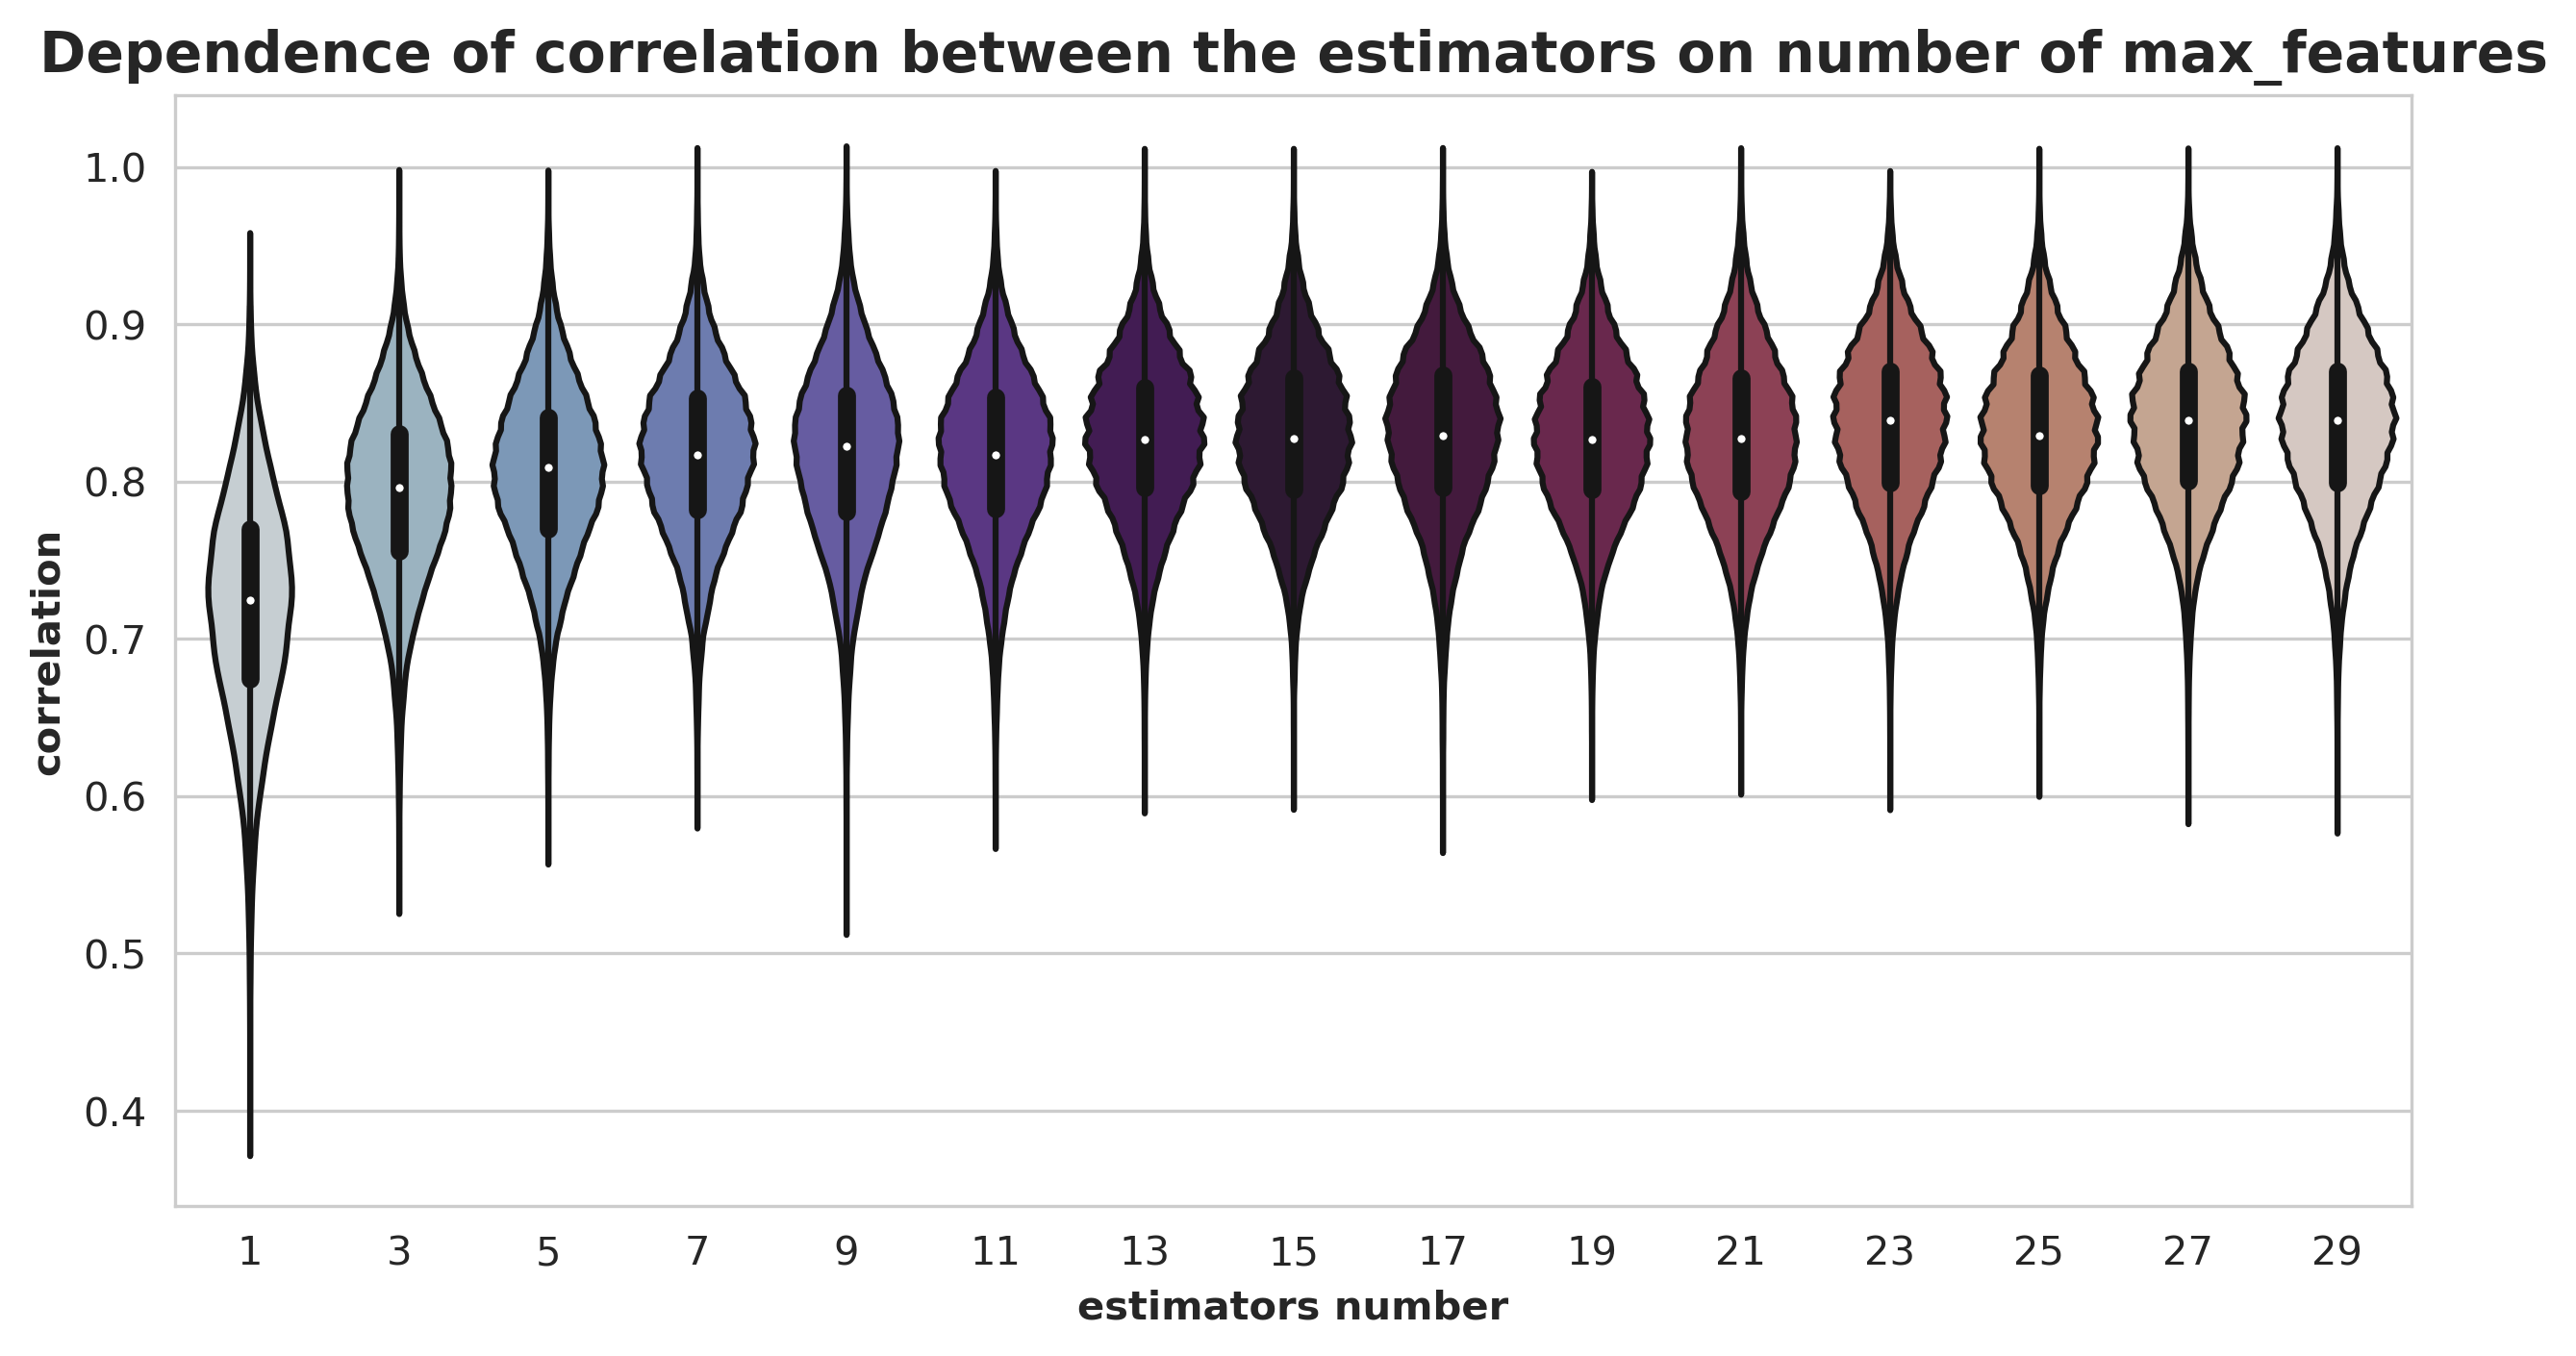

In [110]:
max_features_df = pd.DataFrame(max_features_dict)

fig, ax = plt.subplots(figsize=(10,5), dpi=300)
sns.violinplot(data=max_features_df, palette="twilight", ax=ax)
ax.set_title("Dependence of correlation between the estimators on number of max_features", 
             fontsize=14, fontweight="bold")
ax.set_xlabel("estimators number", fontweight="bold")
ax.set_ylabel("correlation", fontweight="bold");

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [7]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [103]:
max_depth = [1, 2, 5, 10, 15, 25, 50, 100, 200]
max_depth_dict = {}

for i in max_depth:
    rf_model = RandomForestClassifier(max_depth=i, n_estimators=300) # max_features = sqrt(n_features) 5
    rf_model.fit(X_train, y_train)
    max_depth_dict[i] = base_model_pair_correlation(rf_model, X_test)

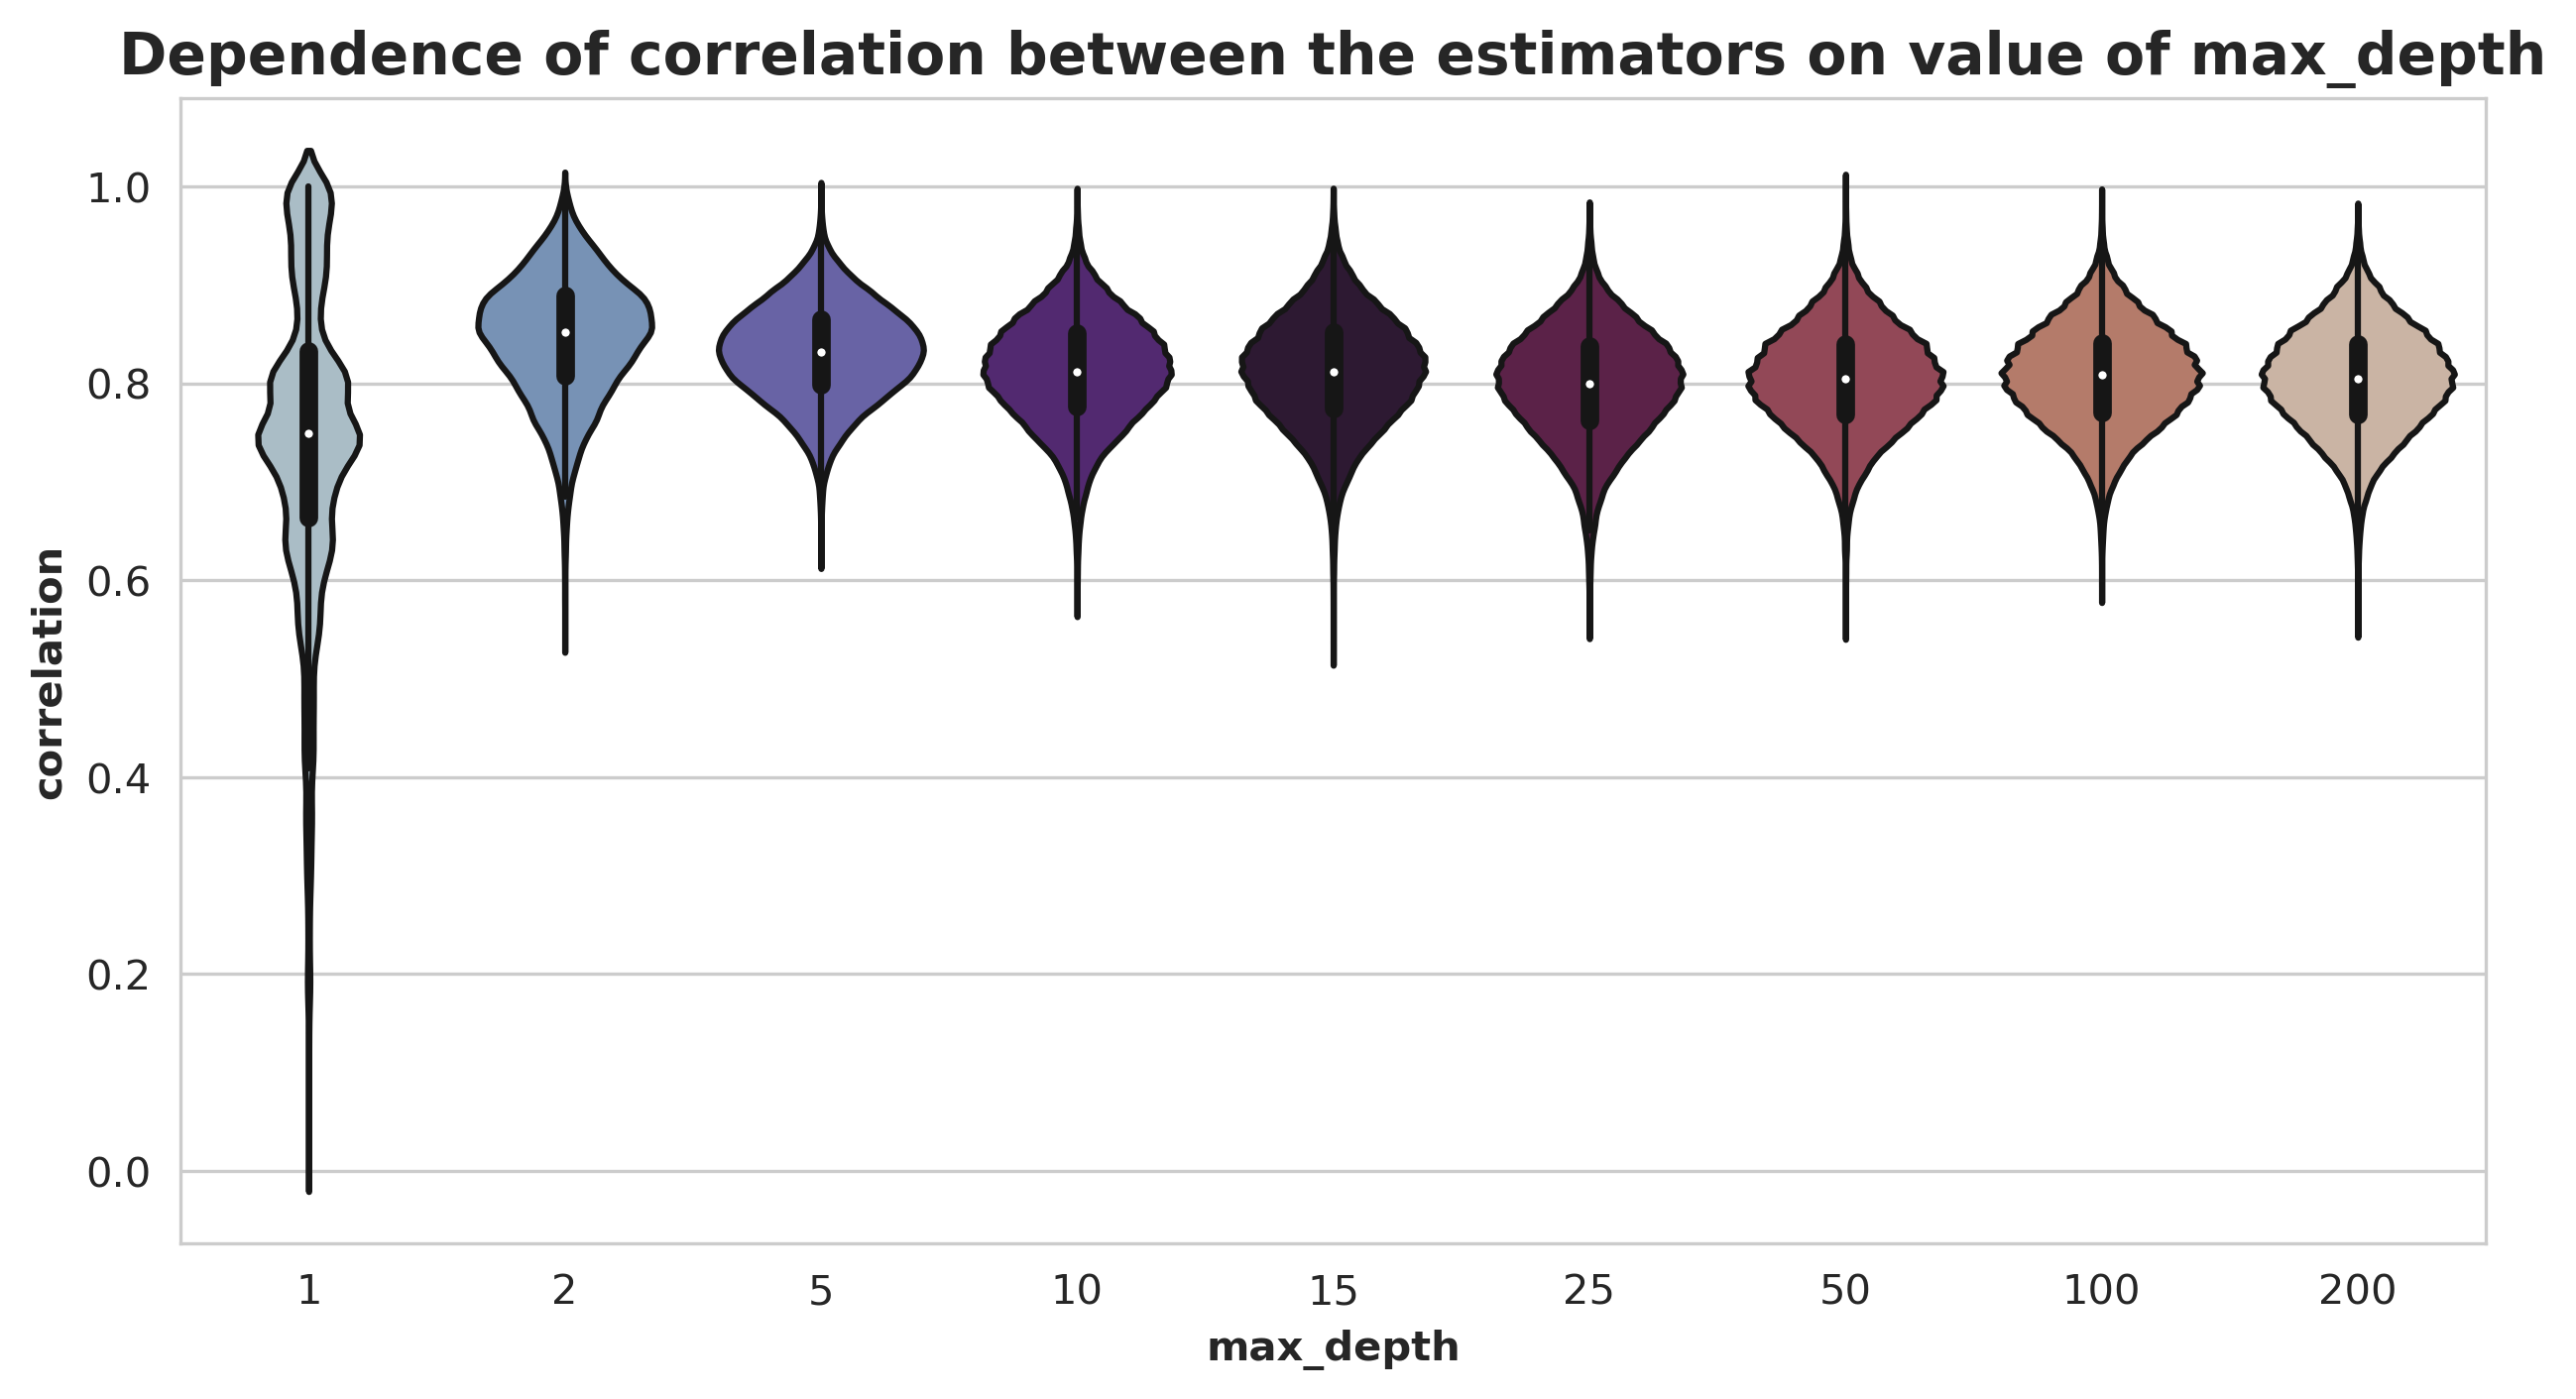

In [106]:
max_depth_df = pd.DataFrame(max_depth_dict)

fig, ax = plt.subplots(figsize=(10,5), dpi=300)
sns.violinplot(data=max_depth_df, palette="twilight", ax=ax)
ax.set_title("Dependence of correlation between the estimators on value of max_depth", 
             fontsize=14, fontweight="bold")
ax.set_xlabel("max_depth", fontweight="bold")
ax.set_ylabel("correlation", fontweight="bold");

Опишите ваши наблюдения:

* the larger the `max_features` parameter, the stronger the correlation of estimators, but with the values of parameter $\gt 10$, it reaches a plateau;
* varying `max_depth` parameter, we also reach a plateau (with value of parameter $\ge 5$), with low values, the correlation between estimators may be higher. The most strange correlation distribution is observed for `math_depth = 1`

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.89**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [4]:
# ! gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("heart.csv")

In [5]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
178   43    1   0       120   177    0        0      120      1      2.5   
298   57    0   0       140   241    0        1      123      1      0.2   
201   60    1   0       125   258    0        0      141      1      2.8   
246   56    0   0       134   409    0        0      150      1      1.9   
153   66    0   2       146   278    0        0      152      0      0.0   

     slope  ca  thal  
178      1   0     3  
298      1   0     3  
201      1   1     3  
246      1   2     3  
153      1   1     2

Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [7]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [8]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier(estimators = base_models, voting="hard")
voting_soft = VotingClassifier(estimators = base_models, voting="soft")
## END YOUR CODE HERE ##
    
scores_dict = {'model': [], 'f1_score':[]}
for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]:
    scores_dict['model'].append(model.__class__.__name__)
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    scores_dict['f1_score'].append(scores.mean());

[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


In [9]:
scores_df = pd.DataFrame(scores_dict)
scores_df.sort_values(by="f1_score", ascending=False, inplace=True)
scores_df.reset_index(drop=True, inplace=True)
scores_df

model  f1_score
0       LogisticRegression  0.850007
1         VotingClassifier  0.845511
2          XGBRFClassifier  0.842683
3                      SVC  0.840310
4         VotingClassifier  0.839580
5       CatBoostClassifier  0.834272
6   RandomForestClassifier  0.832875
7     ExtraTreesClassifier  0.828175
8            XGBClassifier  0.820158
9           LGBMClassifier  0.817011
10              GaussianNB  0.814068
11          LGBMClassifier  0.813248
12  DecisionTreeClassifier  0.797997
13                     SVC  0.697312
14    KNeighborsClassifier  0.649331

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [10]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))
    return corrs

In [13]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [12]:
voting_hard.fit(X_train, y_train);
voting_soft.fit(X_train, y_train);

In [13]:
corrs_soft = base_model_pair_correlation_for_voting_clf(voting_soft, X_train)
corrs_hard = base_model_pair_correlation_for_voting_clf(voting_hard, X_train)

In [14]:
# voting_type = ["soft", "hard"]
# votings= [corrs_soft, corrs_hard]

for v_type, corrs in zip(["soft"], [corrs_soft]):
    print(f'\n--------{v_type}--------')
    for el in corrs:
        if el[2] > 0.95:
            print(f'{el[0].__class__.__name__, el[1].__class__.__name__} corr_score: {el[2]}')


--------soft--------
('RandomForestClassifier', 'ExtraTreesClassifier') corr_score: 0.9755705702834903
('RandomForestClassifier', 'KNeighborsClassifier') corr_score: 0.9755705702834903
('RandomForestClassifier', 'CatBoostClassifier') corr_score: 0.9916646204862017
('RandomForestClassifier', 'LGBMClassifier') corr_score: 0.9896757313382186
('RandomForestClassifier', 'XGBClassifier') corr_score: 0.9848970642667053
('RandomForestClassifier', 'XGBRFClassifier') corr_score: 0.9640270483865033
('ExtraTreesClassifier', 'KNeighborsClassifier') corr_score: 0.9999999999999989
('ExtraTreesClassifier', 'CatBoostClassifier') corr_score: 0.9770581899010482
('ExtraTreesClassifier', 'LGBMClassifier') corr_score: 0.9848420743994735
('ExtraTreesClassifier', 'XGBClassifier') corr_score: 0.9968823812305806
('KNeighborsClassifier', 'CatBoostClassifier') corr_score: 0.9770581899010482
('KNeighborsClassifier', 'LGBMClassifier') corr_score: 0.9848420743994735
('KNeighborsClassifier', 'XGBClassifier') corr_sc

In [19]:
def drop_model_from_ensemble(models_to_drop, X, y):
    scores_dict = {'f1_score': [[], []]}
    model_names = []
    for model in models_to_drop:
        model_names.append(model[1].__class__.__name__)
        base_models_copy = base_models.copy()
        base_models_copy.remove(model)

        voting_soft = VotingClassifier(estimators=base_models_copy, voting='soft')
        voting_hard = VotingClassifier(estimators=base_models_copy, voting='hard')

        soft_scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
        hard_scores = cross_val_score(voting_hard, X_train, y_train, cv=3, scoring="f1")
        scores_dict['f1_score'][0].append(soft_scores.mean())
        scores_dict['f1_score'][1].append(hard_scores.mean())

    scores_dict['f1_score'] = scores_dict['f1_score'][0] + scores_dict['f1_score'][1]
            
    mult_index = pd.MultiIndex.from_product([['soft', 'hard'], model_names], names=["voting", "w/o_model"])
    scores_df = pd.DataFrame(scores_dict, index=mult_index)
    return scores_df

In [51]:
est_to_drop = [("KNN", knn), ("ETC", etc), ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("SVC_LIN", svc_lin), ("CAT", cat), ("RF", rf)]

ensemble_wo1 = drop_model_from_ensemble(est_to_drop, X_train, y_train)

In [52]:
ensemble_wo1.sort_values(by='f1_score', ascending=False)

f1_score
voting w/o_model                       
soft   KNeighborsClassifier    0.853950
       ExtraTreesClassifier    0.850363
hard   CatBoostClassifier      0.846445
soft   LGBMClassifier          0.845511
       XGBRFClassifier         0.845511
       SVC                     0.845511
       RandomForestClassifier  0.845511
hard   XGBClassifier           0.843194
       KNeighborsClassifier    0.842832
soft   CatBoostClassifier      0.842336
hard   SVC                     0.841645
       RandomForestClassifier  0.841645
       LGBMClassifier          0.839580
       XGBRFClassifier         0.838413
soft   XGBClassifier           0.838296
hard   ExtraTreesClassifier    0.834799

In [34]:
def drop_n_models_from_ensemble(models_to_drop, X, y, n_models):
    scores_dict = {'f1_score': [[], []]}
    model_names = []
    model_combination = combinations(models_to_drop, n_models)
    for models in model_combination:
        base_models_copy = base_models.copy()
        model_names.append(f'{[model[1].__class__.__name__ for model in models]}')
        for i in range(n_models):
            base_models_copy.remove(models[i])

        voting_soft = VotingClassifier(estimators=base_models_copy, voting='soft')
        voting_hard = VotingClassifier(estimators=base_models_copy, voting='hard')

        soft_scores = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
        hard_scores = cross_val_score(voting_hard, X_train, y_train, cv=3, scoring="f1")
        scores_dict['f1_score'][0].append(soft_scores.mean())
        scores_dict['f1_score'][1].append(hard_scores.mean())

    scores_dict['f1_score'] = scores_dict['f1_score'][0] + scores_dict['f1_score'][1]
            
    mult_index = pd.MultiIndex.from_product([['soft', 'hard'], model_names], names=["voting", "w/o_models"])
    scores_df = pd.DataFrame(scores_dict, index=mult_index)
    return scores_df

In [53]:
est_to_drop = [("KNN", knn), ("ETC", etc), ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("SVC_LIN", svc_lin), ("CAT", cat), ("RF", rf)]
ensemble_wo2 = drop_n_models_from_ensemble(est_to_drop, X_train, y_train, 2)

In [55]:
ensemble_wo2.sort_values(by="f1_score", ascending=False)

f1_score
voting w/o_models                                                  
hard   ['ExtraTreesClassifier', 'RandomForestClassifier']  0.858348
       ['CatBoostClassifier', 'RandomForestClassifier']    0.857574
soft   ['ExtraTreesClassifier', 'LGBMClassifier']          0.855032
       ['ExtraTreesClassifier', 'RandomForestClassifier']  0.855032
       ['ExtraTreesClassifier', 'XGBRFClassifier']         0.855032
hard   ['KNeighborsClassifier', 'CatBoostClassifier']      0.854191
       ['XGBRFClassifier', 'CatBoostClassifier']           0.853988
soft   ['KNeighborsClassifier', 'ExtraTreesClassifier']    0.853950
hard   ['KNeighborsClassifier', 'ExtraTreesClassifier']    0.853950
       ['XGBRFClassifier', 'RandomForestClassifier']       0.852706
soft   ['KNeighborsClassifier', 'LGBMClassifier']          0.850775
       ['KNeighborsClassifier', 'XGBRFClassifier']         0.850775
       ['KNeighborsClassifier', 'CatBoostClassifier']      0.850363
hard   ['KNeighborsClassifier', 'RandomForestClassifier']  0.850363
soft   ['LGBMClassifier', 'XGBRFClassifier']               0.850363
hard   ['ExtraTreesClassifier', 'CatBoostClassifier']      0.850363
soft   ['KNeighborsClassifier', 'RandomForestClassifier']  0.850363
       ['ExtraTreesClassifier', 'CatBoostClassifier']      0.850363
hard   ['LGBMClassifier', 'RandomForestClassifier']        0.850180
       ['LGBMClassifier', 'XGBRFClassifier']               0.850180
soft   ['ExtraTreesClassifier', 'SVC']                     0.850180
hard   ['ExtraTreesClassifier', 'LGBMClassifier']          0.850180
       ['KNeighborsClassifier', 'XGBRFClassifier']         0.849444
soft   ['KNeighborsClassifier', 'SVC']                     0.849081
hard   ['XGBClassifier', 'XGBRFClassifier']                0.848189
soft   ['KNeighborsClassifier', 'XGBClassifier']           0.846735
hard   ['SVC', 'RandomForestClassifier']                   0.846445
       ['ExtraTreesClassifier', 'XGBRFClassifier']         0.845511
       ['LGBMClassifier', 'CatBoostClassifier']            0.845511
soft   ['SVC', 'RandomForestClassifier']                   0.845511
       ['SVC', 'CatBoostClassifier']                       0.845511
       ['XGBRFClassifier', 'CatBoostClassifier']           0.845511
       ['XGBRFClassifier', 'SVC']                          0.845511
       ['LGBMClassifier', 'RandomForestClassifier']        0.845511
       ['LGBMClassifier', 'CatBoostClassifier']            0.845511
       ['LGBMClassifier', 'SVC']                           0.845511
       ['XGBRFClassifier', 'RandomForestClassifier']       0.845511
hard   ['XGBClassifier', 'CatBoostClassifier']             0.845014
       ['ExtraTreesClassifier', 'XGBClassifier']           0.844086
       ['XGBClassifier', 'SVC']                            0.843194
       ['SVC', 'CatBoostClassifier']                       0.842893
       ['KNeighborsClassifier', 'SVC']                     0.842832
       ['KNeighborsClassifier', 'XGBClassifier']           0.842336
soft   ['CatBoostClassifier', 'RandomForestClassifier']    0.842336
       ['XGBClassifier', 'RandomForestClassifier']         0.841930
       ['ExtraTreesClassifier', 'XGBClassifier']           0.841471
hard   ['KNeighborsClassifier', 'LGBMClassifier']          0.841005
       ['XGBClassifier', 'RandomForestClassifier']         0.840984
       ['LGBMClassifier', 'SVC']                           0.840697
soft   ['XGBClassifier', 'XGBRFClassifier']                0.840696
       ['XGBClassifier', 'SVC']                            0.840534
hard   ['XGBRFClassifier', 'SVC']                          0.839642
soft   ['LGBMClassifier', 'XGBClassifier']                 0.837072
hard   ['LGBMClassifier', 'XGBClassifier']                 0.836028
       ['ExtraTreesClassifier', 'SVC']                     0.836028
soft   ['XGBClassifier', 'CatBoostClassifier']             0.833898

In [ ]:
est_to_drop = [("KNN", knn), ("ETC", etc), ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("SVC_LIN", svc_lin), ("CAT", cat), ("RF", rf)]

ensemble_wo3 = drop_n_models_from_ensemble(est_to_drop, X_train, y_train, 3)

In [57]:
ensemble_wo3.sort_values(by="f1_score", ascending=False)

f1_score
voting w/o_models                                                  
soft   ['KNeighborsClassifier', 'ExtraTreesClassifier'...  0.857201
hard   ['ExtraTreesClassifier', 'XGBRFClassifier', 'Ra...  0.856419
       ['KNeighborsClassifier', 'XGBRFClassifier', 'Ca...  0.856308
       ['KNeighborsClassifier', 'ExtraTreesClassifier'...  0.856026
       ['ExtraTreesClassifier', 'CatBoostClassifier', ...  0.856026
...                                                             ...
       ['ExtraTreesClassifier', 'XGBClassifier', 'SVC']    0.838413
soft   ['LGBMClassifier', 'XGBClassifier', 'RandomFore...  0.838296
hard   ['KNeighborsClassifier', 'ExtraTreesClassifier'...  0.838032
       ['XGBClassifier', 'XGBRFClassifier', 'SVC']         0.837429
       ['KNeighborsClassifier', 'LGBMClassifier', 'XGB...  0.836028

[112 rows x 1 columns]

In [64]:
est_to_drop = [("KNN", knn), ("ETC", etc), ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("SVC_LIN", svc_lin), ("CAT", cat), ("RF", rf)]

ensemble_wo4 = drop_n_models_from_ensemble(est_to_drop, X_train, y_train, 4)

In [65]:
ensemble_wo4.sort_values(by="f1_score", ascending=False)

f1_score
voting w/o_models                                                  
hard   ['KNeighborsClassifier', 'XGBRFClassifier', 'Ca...  0.862321
       ['KNeighborsClassifier', 'ExtraTreesClassifier'...  0.861982
soft   ['ExtraTreesClassifier', 'LGBMClassifier', 'XGB...  0.859592
hard   ['KNeighborsClassifier', 'ExtraTreesClassifier'...  0.859430
       ['KNeighborsClassifier', 'XGBClassifier', 'CatB...  0.858720
...                                                             ...
       ['ExtraTreesClassifier', 'LGBMClassifier', 'XGB...  0.837235
       ['LGBMClassifier', 'XGBClassifier', 'SVC', 'Cat...  0.836180
       ['ExtraTreesClassifier', 'XGBClassifier', 'XGBR...  0.836180
       ['ExtraTreesClassifier', 'XGBClassifier', 'SVC'...  0.836180
       ['KNeighborsClassifier', 'LGBMClassifier', 'XGB...  0.836028

[140 rows x 1 columns]

In [15]:
base_models_new = [("SVC_LIN", svc_lin),
                ('RF', rf),
                ("LGBM", lgbm), 
                ("LR", lr), 
                ("NB", nb)
                ]

voting_soft = VotingClassifier(estimators=base_models_new, voting='soft')
voting_hard = VotingClassifier(estimators=base_models_new, voting='hard')

voting_hard.fit(X_train, y_train)
voting_soft.fit(X_train, y_train)

y_pred_soft = voting_soft.predict(X_test)
y_pred_hard = voting_hard.predict(X_test)

f1_score_soft = f1_score(y_test, y_pred_soft)
f1_score_hard = f1_score(y_test, y_pred_hard)

print(f'Ensemble, voting soft f1_score: {f1_score_soft}')
print(f'Ensemble, voting hard f1_score: {f1_score_hard}')

Ensemble, voting soft f1_score: 0.8712871287128713
Ensemble, voting hard f1_score: 0.8910891089108911


For voting in 'hard' mode and ensemble with SVC (linear), RandomForest, LGBM, LinearRegression,and GaussianNB, I obtained f1_score for test target classification > 0.89.

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [11]:
data = pd.read_csv("churn.csv")
data.head()

State  Account Length  Area Code     Phone Int'l Plan VMail Plan  \
0    KS             128        415  382-4657         no        yes   
1    OH             107        415  371-7191         no        yes   
2    NJ             137        415  358-1921         no         no   
3    OH              84        408  375-9999        yes         no   
4    OK              75        415  330-6626        yes         no   

   VMail Message  Day Mins  Day Calls  Day Charge  ...  Eve Calls  Eve Charge  \
0             25     265.1        110       45.07  ...         99       16.78   
1             26     161.6        123       27.47  ...        103       16.62   
2              0     243.4        114       41.38  ...        110       10.30   
3              0     299.4         71       50.90  ...         88        5.26   
4              0     166.7        113       28.34  ...        122       12.61   

   Night Mins  Night Calls  Night Charge  Intl Mins  Intl Calls  Intl Charge  \
0       244.7           91         11.01       10.0           3         2.70   
1       254.4          103         11.45       13.7           3         3.70   
2       162.6          104          7.32       12.2           5         3.29   
3       196.9           89          8.86        6.6           7         1.78   
4       186.9          121          8.41       10.1           3         2.73   

   CustServ Calls  Churn?  
0               1  False.  
1               1  False.  
2               0  False.  
3               2  False.  
4               3  False.  

[5 rows x 21 columns]

#### EDA

1) Let's obtain overall description for Dataset

In [12]:
# description for dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [13]:
# Dataset size
data.shape

(3333, 21)

We have 3333 observations, 20 features and target **Churn?**.

2) Let's take a look on mean and std for features

In [14]:
data.describe()

Account Length    Area Code  VMail Message     Day Mins    Day Calls  \
count     3333.000000  3333.000000    3333.000000  3333.000000  3333.000000   
mean       101.064806   437.182418       8.099010   179.775098   100.435644   
std         39.822106    42.371290      13.688365    54.467389    20.069084   
min          1.000000   408.000000       0.000000     0.000000     0.000000   
25%         74.000000   408.000000       0.000000   143.700000    87.000000   
50%        101.000000   415.000000       0.000000   179.400000   101.000000   
75%        127.000000   510.000000      20.000000   216.400000   114.000000   
max        243.000000   510.000000      51.000000   350.800000   165.000000   

        Day Charge     Eve Mins    Eve Calls   Eve Charge   Night Mins  \
count  3333.000000  3333.000000  3333.000000  3333.000000  3333.000000   
mean     30.562307   200.980348   100.114311    17.083540   200.872037   
std       9.259435    50.713844    19.922625     4.310668    50.573847   
min       0.000000     0.000000     0.000000     0.000000    23.200000   
25%      24.430000   166.600000    87.000000    14.160000   167.000000   
50%      30.500000   201.400000   100.000000    17.120000   201.200000   
75%      36.790000   235.300000   114.000000    20.000000   235.300000   
max      59.640000   363.700000   170.000000    30.910000   395.000000   

       Night Calls  Night Charge    Intl Mins   Intl Calls  Intl Charge  \
count  3333.000000   3333.000000  3333.000000  3333.000000  3333.000000   
mean    100.107711      9.039325    10.237294     4.479448     2.764581   
std      19.568609      2.275873     2.791840     2.461214     0.753773   
min      33.000000      1.040000     0.000000     0.000000     0.000000   
25%      87.000000      7.520000     8.500000     3.000000     2.300000   
50%     100.000000      9.050000    10.300000     4.000000     2.780000   
75%     113.000000     10.590000    12.100000     6.000000     3.270000   
max     175.000000     17.770000    20.000000    20.000000     5.400000   

       CustServ Calls  
count     3333.000000  
mean         1.562856  
std          1.315491  
min          0.000000  
25%          1.000000  
50%          1.000000  
75%          2.000000  
max          9.000000

In [15]:
data.isnull().sum()

State             0
Account Length    0
Area Code         0
Phone             0
Int'l Plan        0
VMail Plan        0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
Churn?            0
dtype: int64

3. There are special symbols in feature names and white spaces... Let's remove them.

In [16]:
data.columns

Index(['State', 'Account Length', 'Area Code', 'Phone', 'Int'l Plan',
       'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge',
       'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls',
       'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge',
       'CustServ Calls', 'Churn?'],
      dtype='object')

In [17]:
data.columns = data.columns.str.replace(" ", "_")
data.columns = data.columns.str.replace("?", "")
data.columns = data.columns.str.replace("'", "")
data.head()

State  Account_Length  Area_Code     Phone Intl_Plan VMail_Plan  \
0    KS             128        415  382-4657        no        yes   
1    OH             107        415  371-7191        no        yes   
2    NJ             137        415  358-1921        no         no   
3    OH              84        408  375-9999       yes         no   
4    OK              75        415  330-6626       yes         no   

   VMail_Message  Day_Mins  Day_Calls  Day_Charge  ...  Eve_Calls  Eve_Charge  \
0             25     265.1        110       45.07  ...         99       16.78   
1             26     161.6        123       27.47  ...        103       16.62   
2              0     243.4        114       41.38  ...        110       10.30   
3              0     299.4         71       50.90  ...         88        5.26   
4              0     166.7        113       28.34  ...        122       12.61   

   Night_Mins  Night_Calls  Night_Charge  Intl_Mins  Intl_Calls  Intl_Charge  \
0       244.7           91         11.01       10.0           3         2.70   
1       254.4          103         11.45       13.7           3         3.70   
2       162.6          104          7.32       12.2           5         3.29   
3       196.9           89          8.86        6.6           7         1.78   
4       186.9          121          8.41       10.1           3         2.73   

   CustServ_Calls   Churn  
0               1  False.  
1               1  False.  
2               0  False.  
3               2  False.  
4               3  False.  

[5 rows x 21 columns]

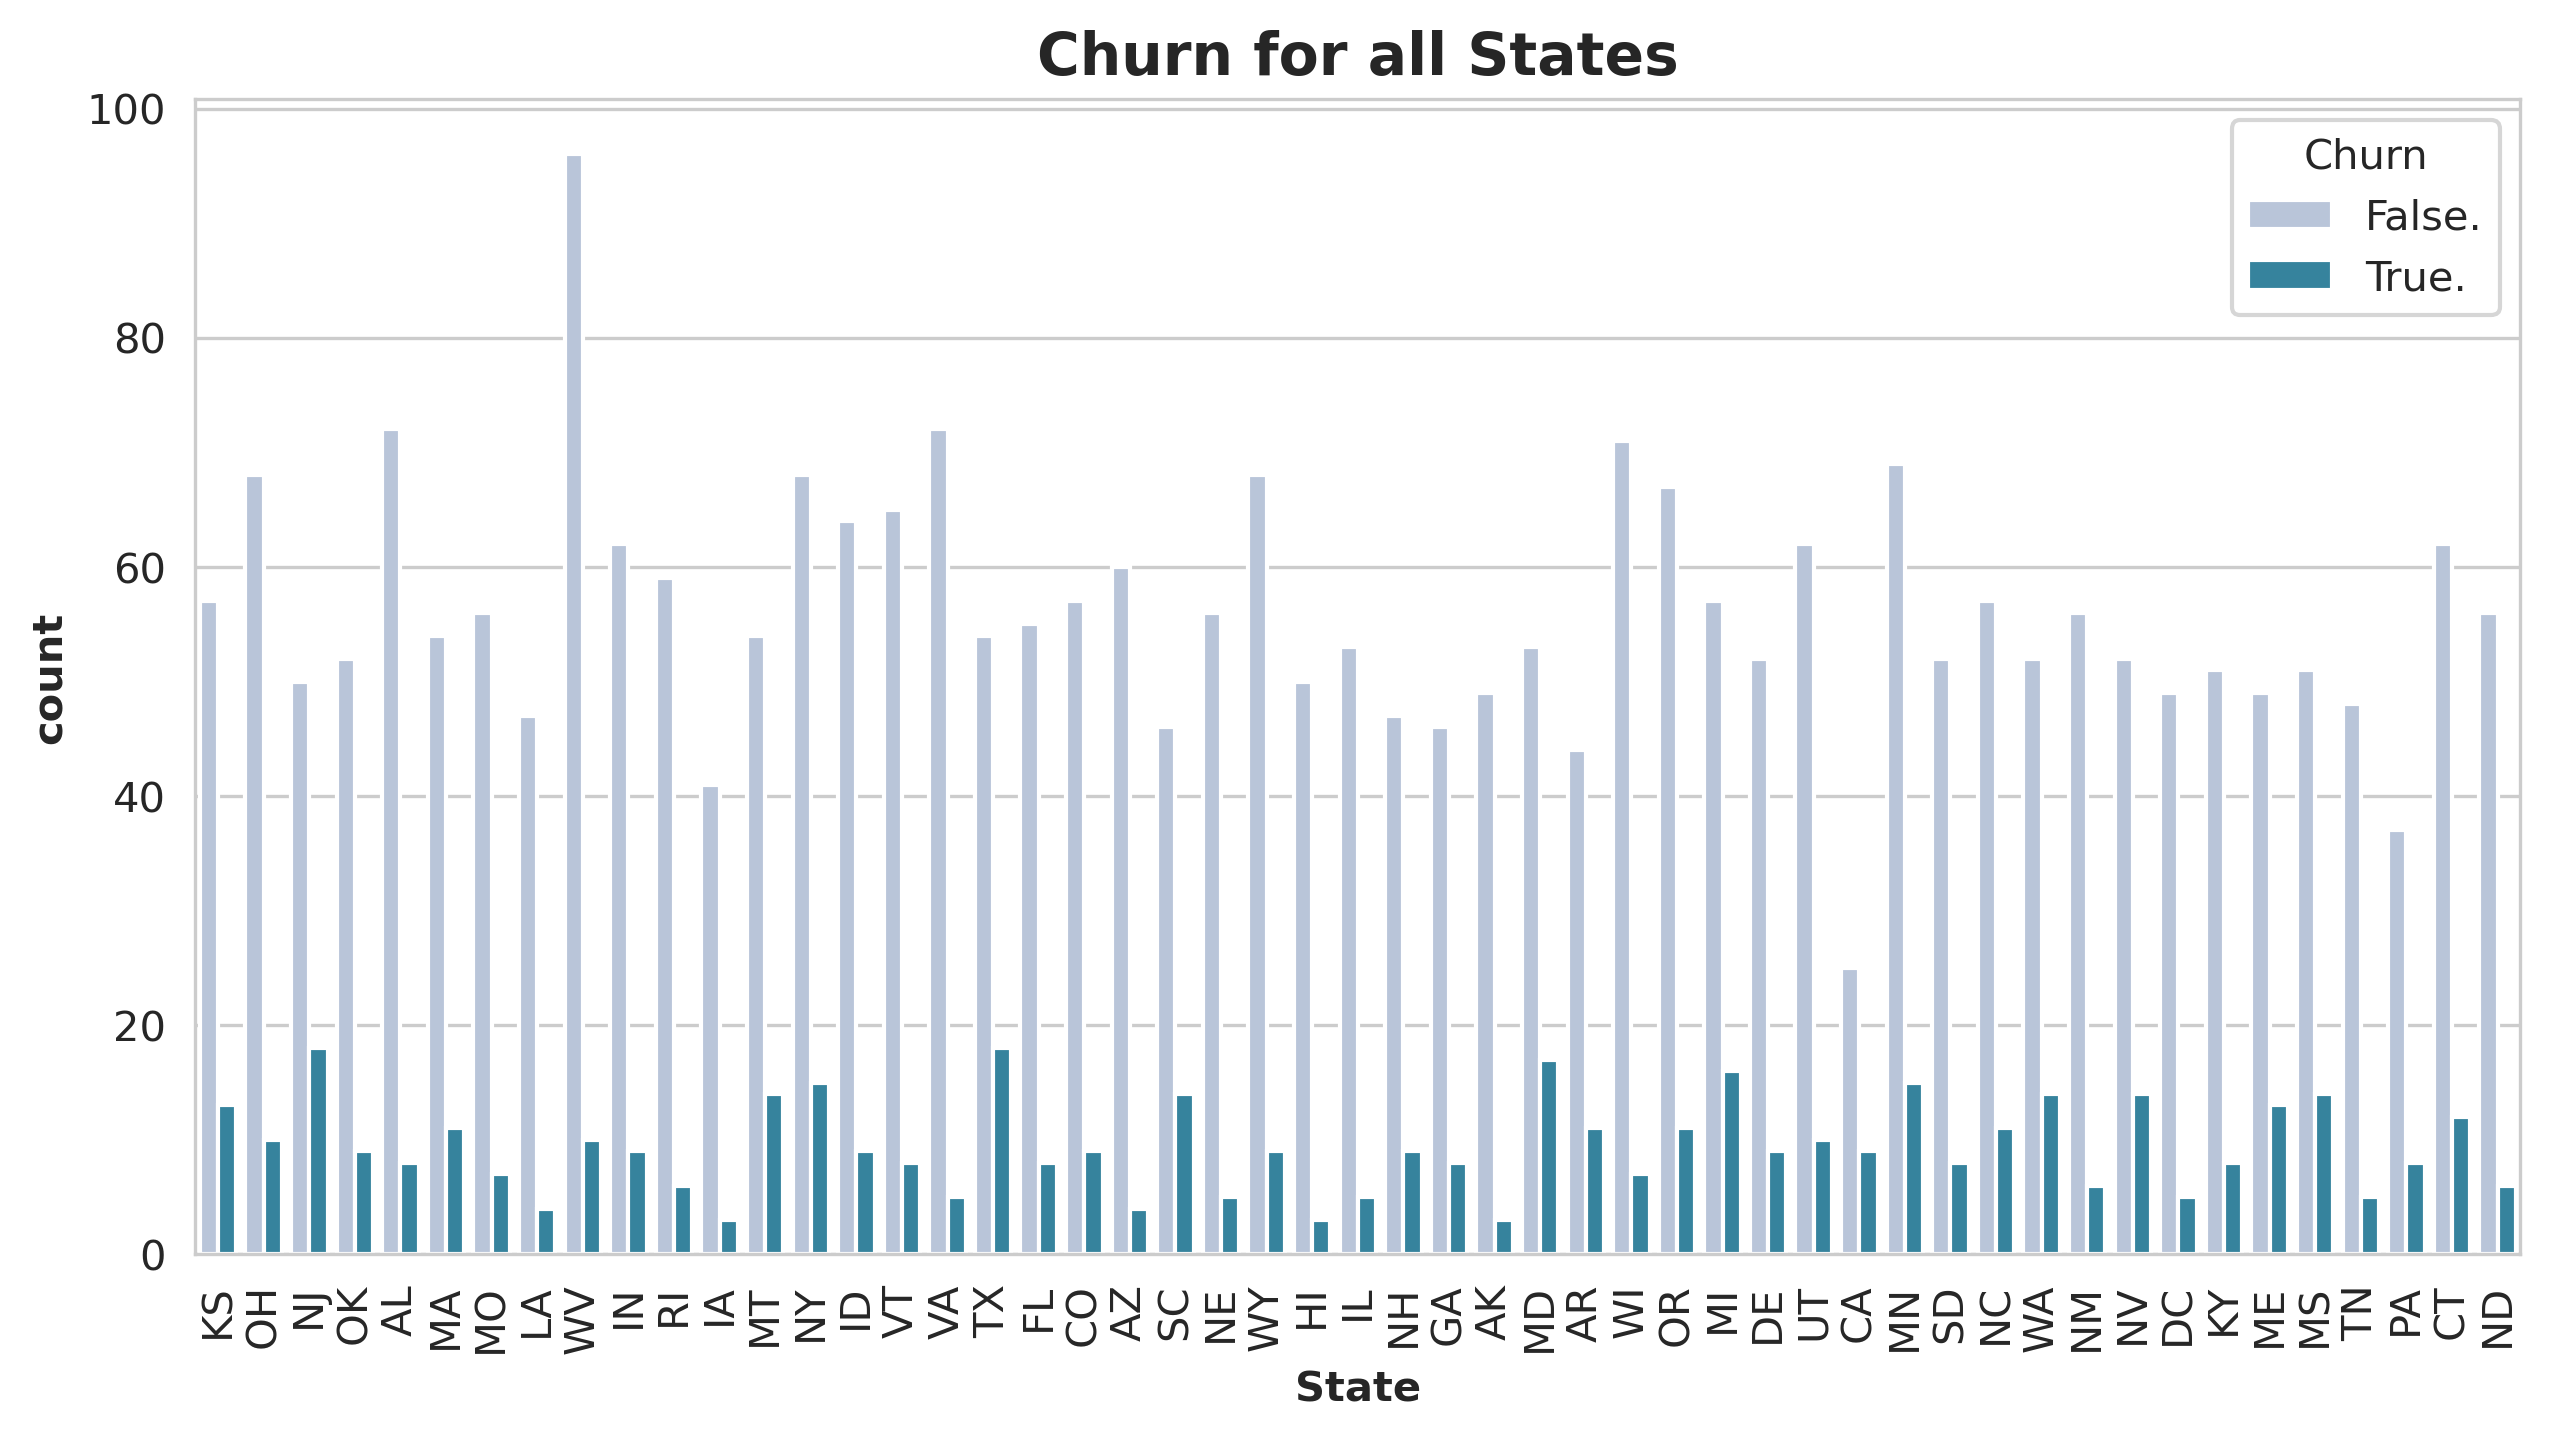

In [18]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
sns.countplot(x=data["State"], hue=data["Churn"], palette="PuBuGn")
plt.xticks(rotation=90)
ax.set_xlabel("State", fontweight="bold")
ax.set_ylabel("count", fontweight="bold")
ax.set_title("Churn for all States", fontsize=14, fontweight="bold");

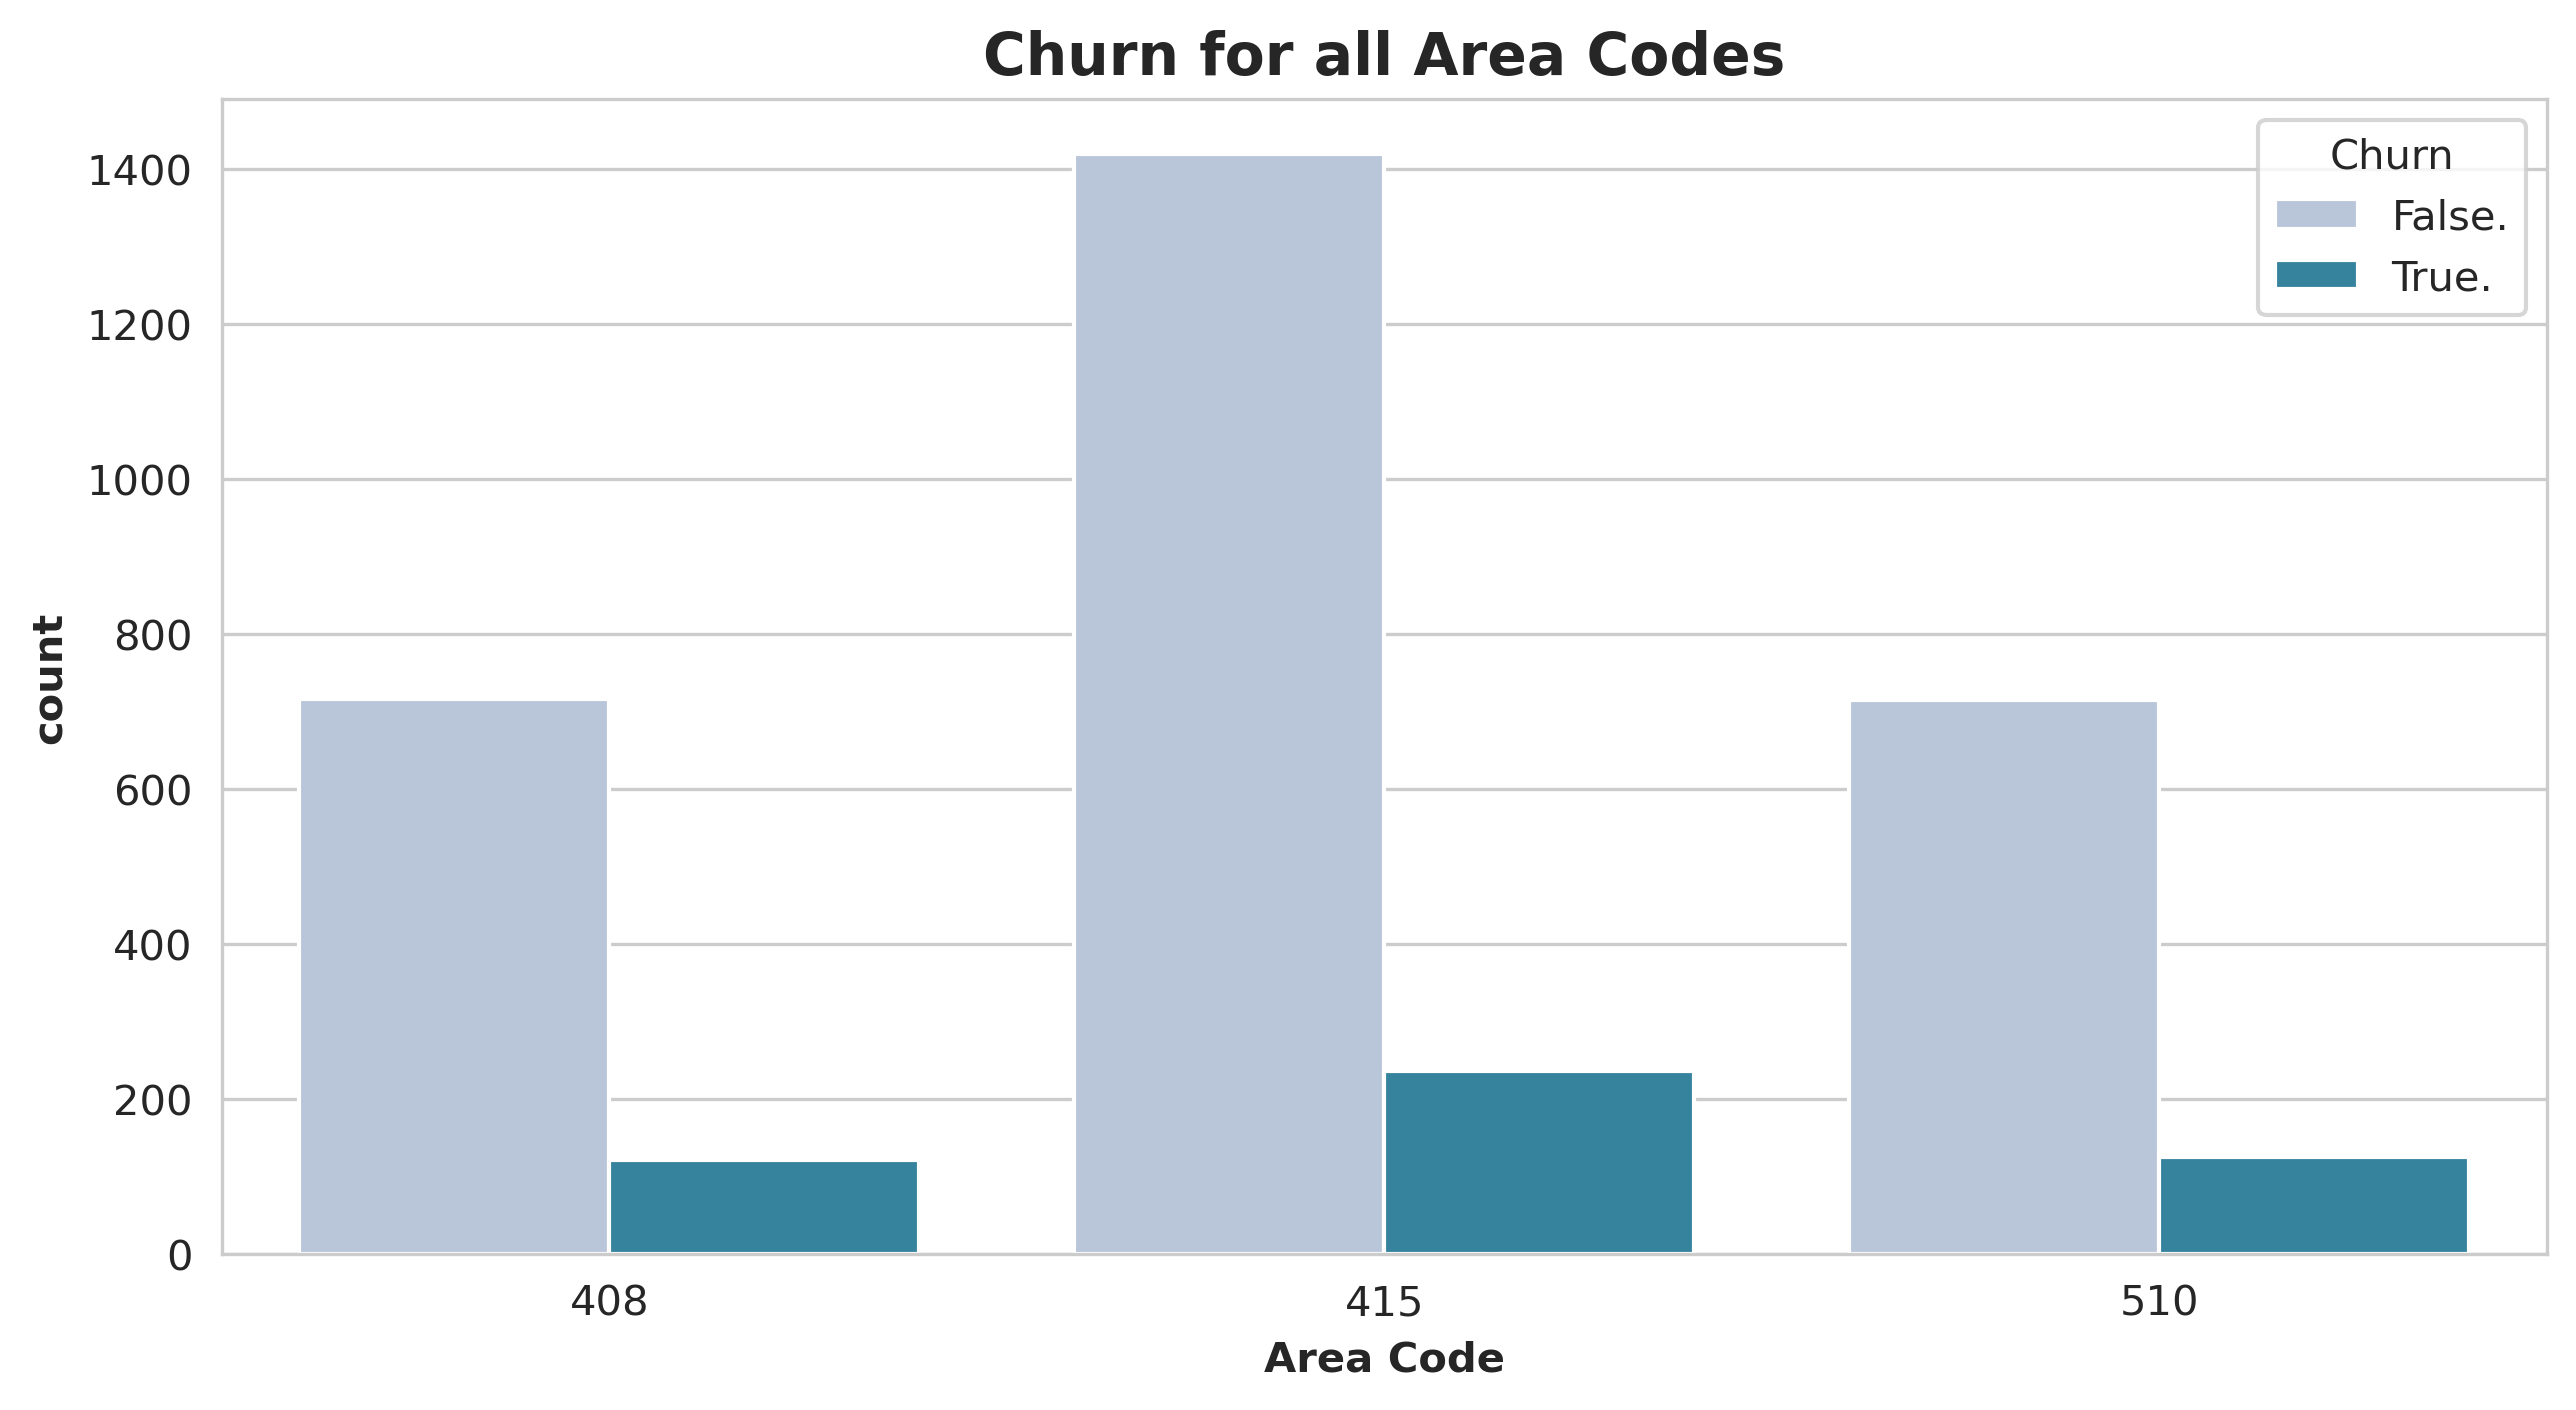

In [19]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
sns.countplot(x=data["Area_Code"], hue=data["Churn"], palette="PuBuGn")
ax.set_xlabel("Area Code", fontweight="bold")
ax.set_ylabel("count", fontweight="bold")
ax.set_title("Churn for all Area Codes", fontsize=14, fontweight="bold");

False.    2850
True.      483
Name: Churn, dtype: int64


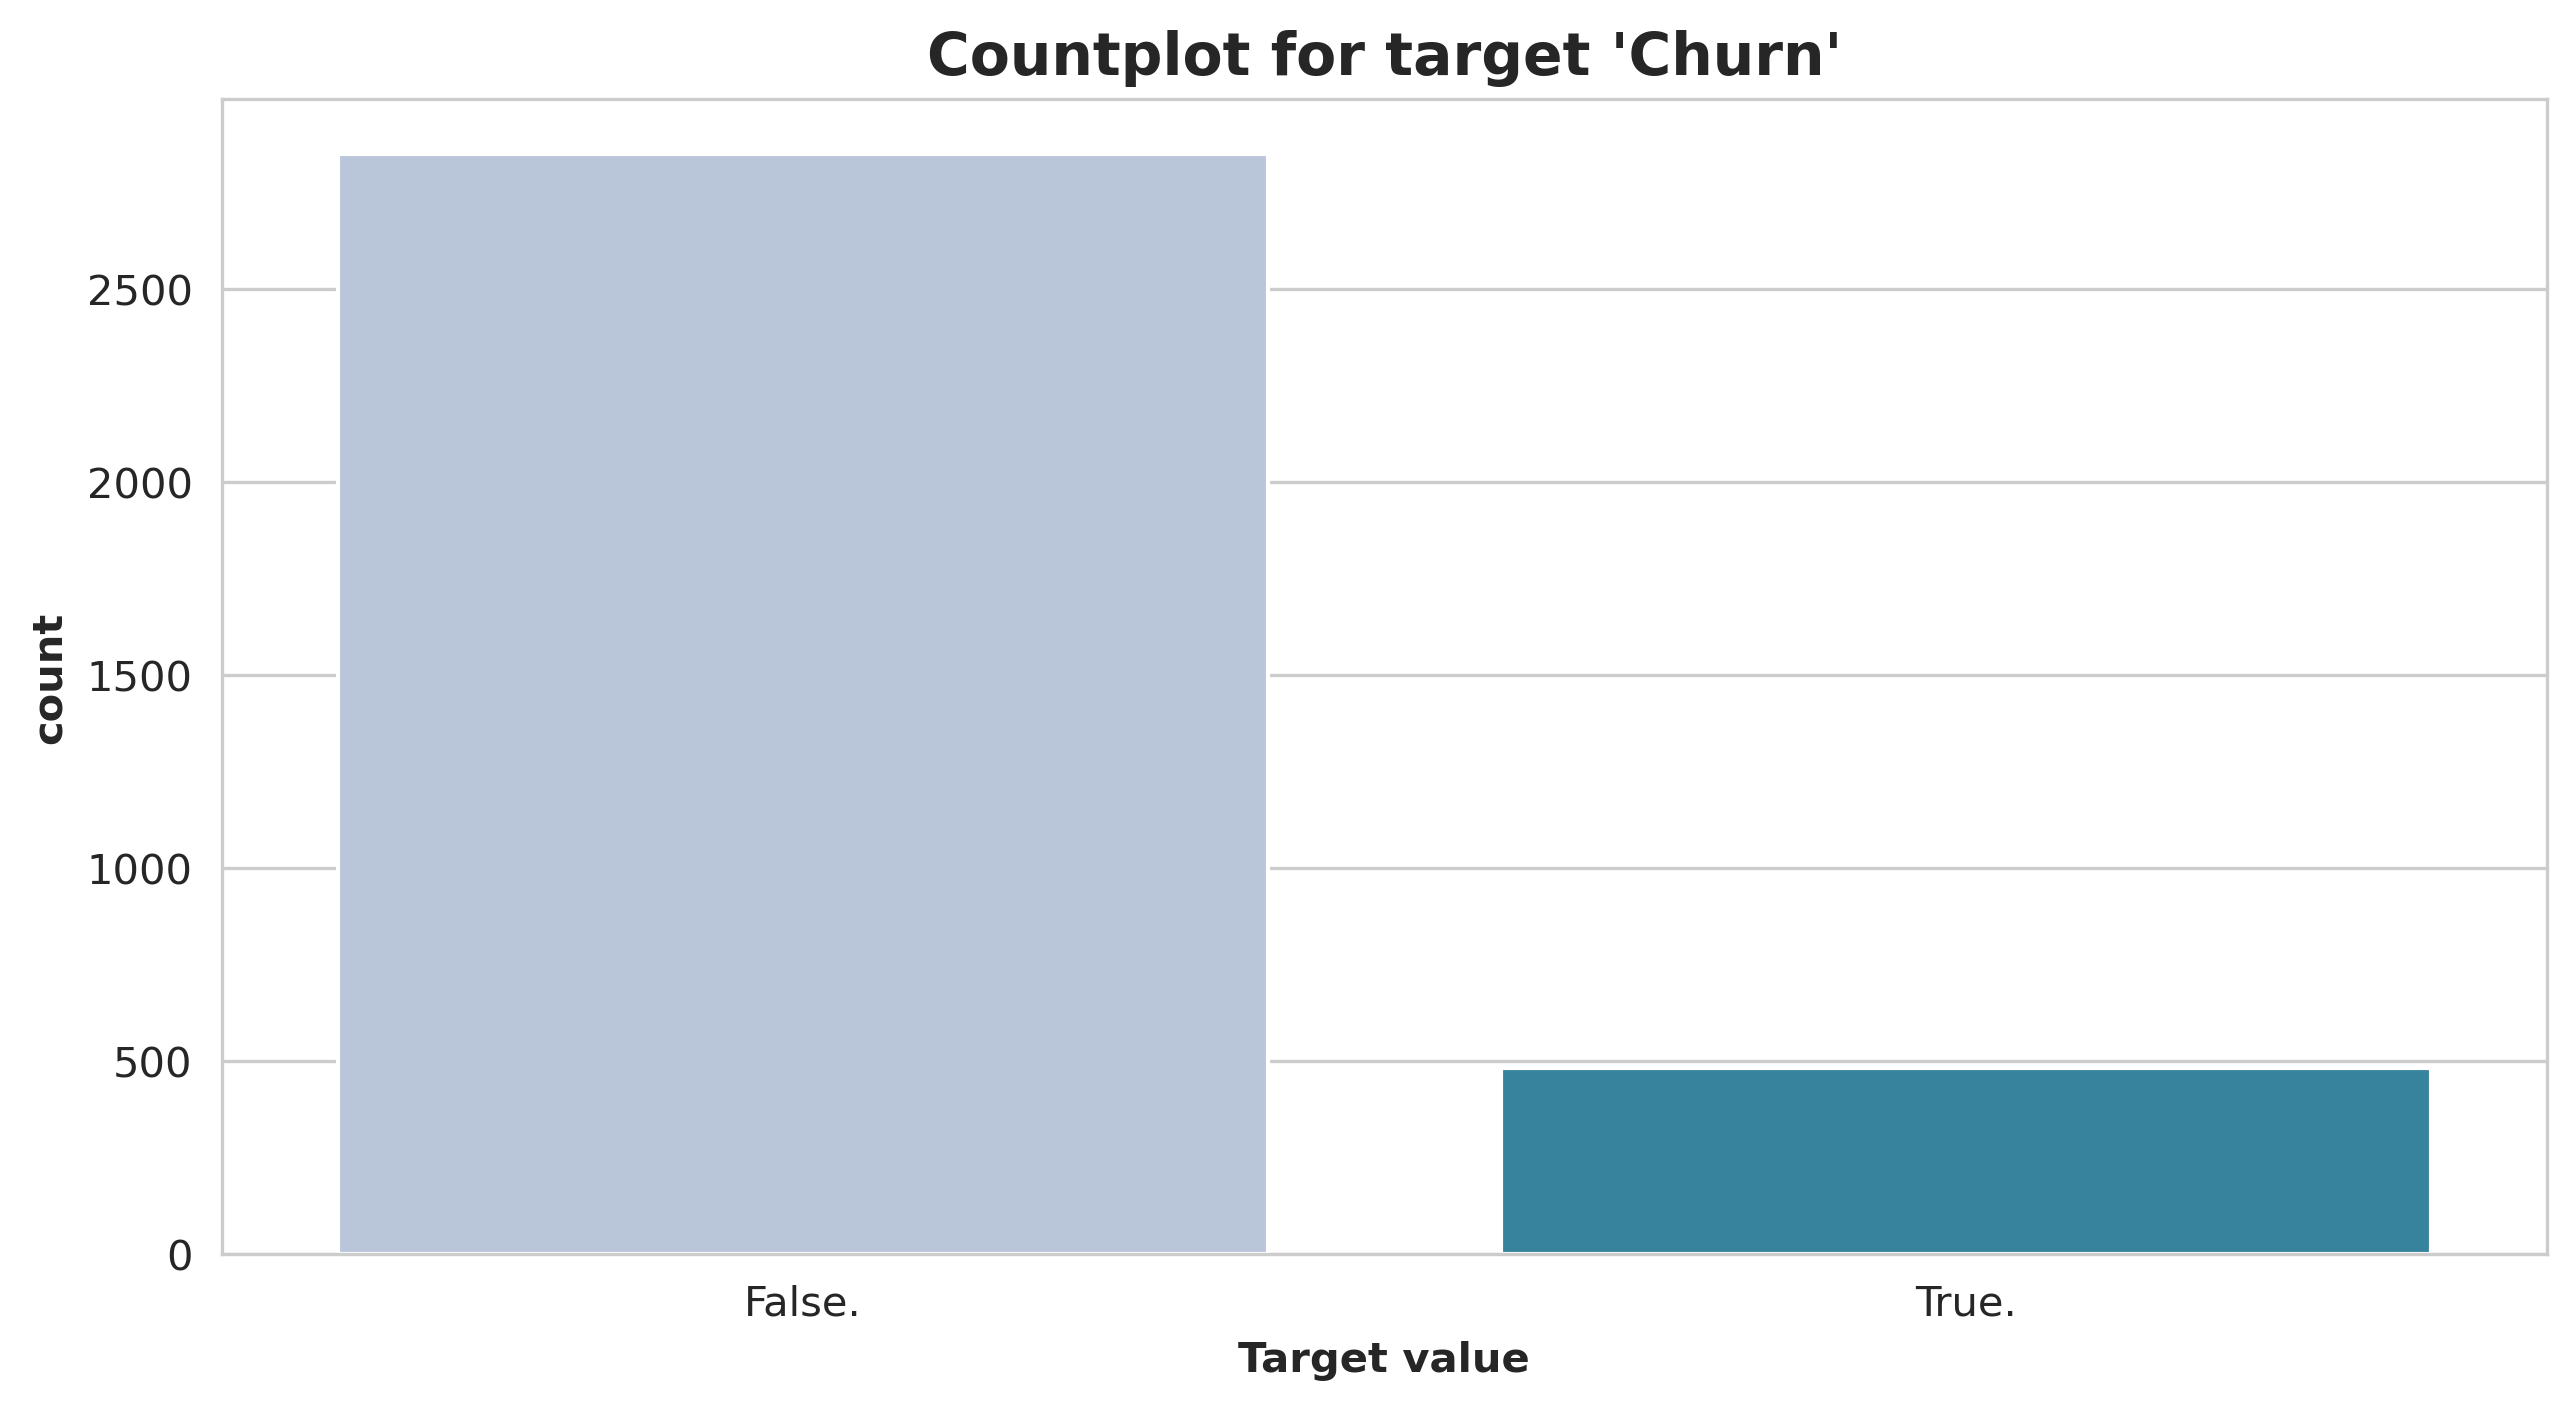

In [20]:
print(data["Churn"].value_counts())

fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
sns.countplot(x=data["Churn"], palette="PuBuGn")
ax.set_xlabel("Target value", fontweight="bold")
ax.set_ylabel("count", fontweight="bold")
ax.set_title("Countplot for target 'Churn'", fontsize=14, fontweight="bold");

Target is definitely disbalanced. I will keep this in mind.

4. Let's replace strange bools (ended with dots) with 0 or 1 for target "Churn".

In [21]:
data["Churn"].replace({'False.': 0, 'True.': 1}, inplace=True)
print(data["Churn"].value_counts())

0    2850
1     483
Name: Churn, dtype: int64


5. Let's replace *Intl_Plan* and *VMail_Plan* with 0 or 1.

In [22]:
data['Intl_Plan'] = data['Intl_Plan'].apply(lambda x: 1 if x=="yes" else 0)
data['VMail_Plan'] = data['VMail_Plan'].apply(lambda x: 1 if x=="yes" else 0)
print(data["Intl_Plan"].value_counts())
print(data["VMail_Plan"].value_counts())

0    3010
1     323
Name: Intl_Plan, dtype: int64
0    2411
1     922
Name: VMail_Plan, dtype: int64


6) Let's check whether our features correlates with each other and target.

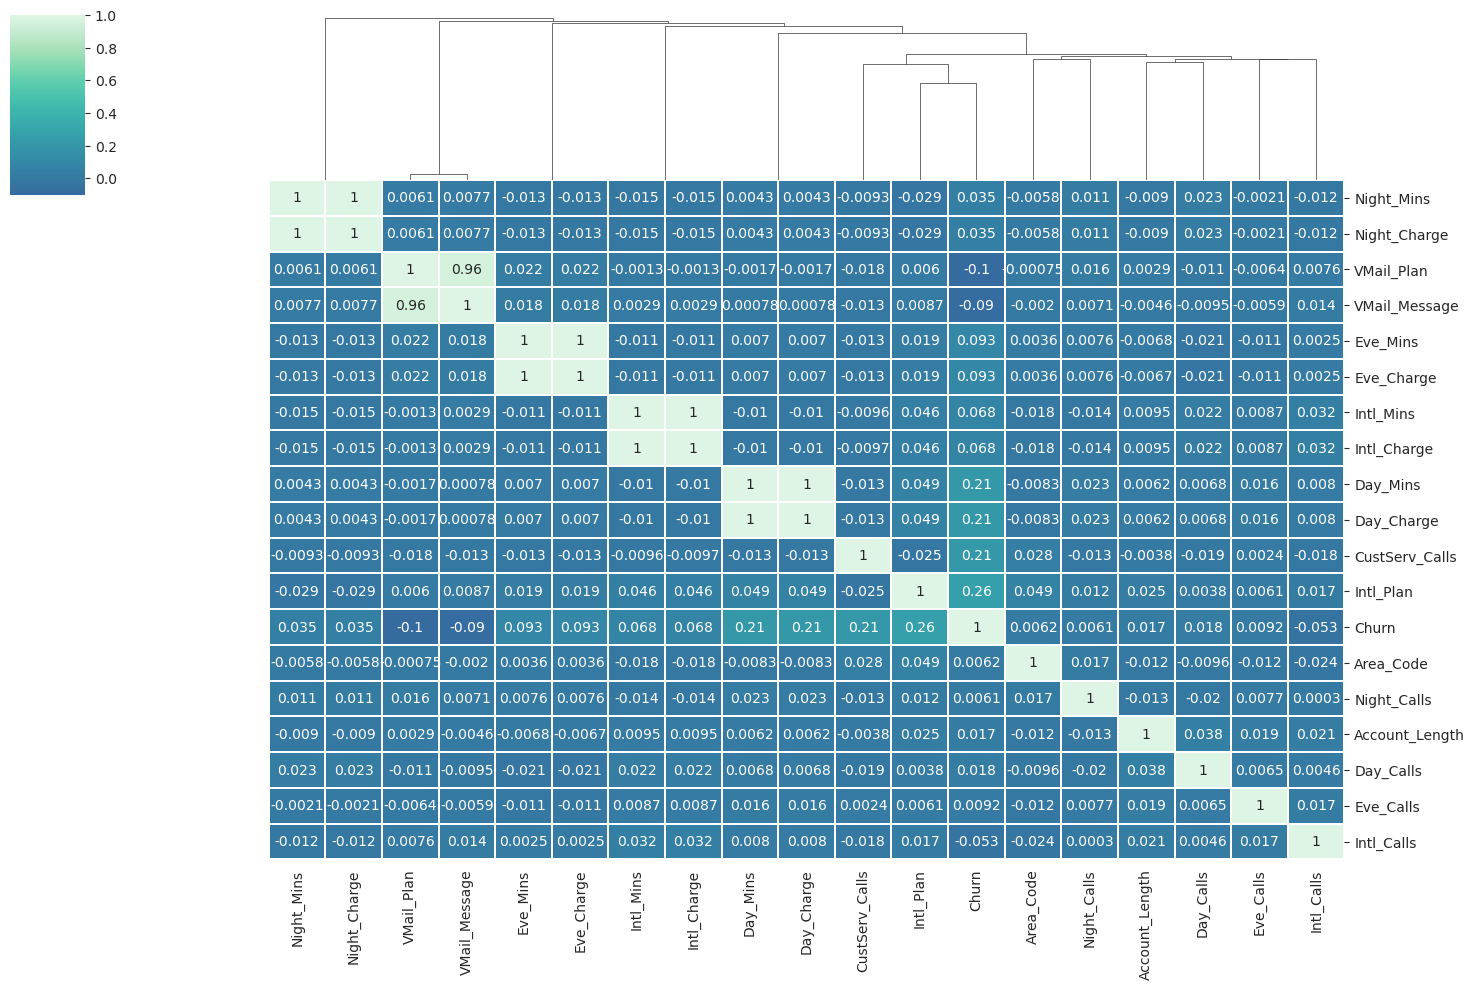

In [23]:
corr = data.corr()
cg = sns.clustermap(corr, center=0, linewidths=.1, annot = True, 
                    figsize=(15, 10), cmap="mako")
cg.ax_row_dendrogram.set_visible(False)
plt.show();

In [24]:
abs(corr["Churn"]).sort_values(ascending=False)

Churn             1.000000
Intl_Plan         0.259852
CustServ_Calls    0.208750
Day_Mins          0.205151
Day_Charge        0.205151
VMail_Plan        0.102148
Eve_Mins          0.092796
Eve_Charge        0.092786
VMail_Message     0.089728
Intl_Charge       0.068259
Intl_Mins         0.068239
Intl_Calls        0.052844
Night_Charge      0.035496
Night_Mins        0.035493
Day_Calls         0.018459
Account_Length    0.016541
Eve_Calls         0.009233
Area_Code         0.006174
Night_Calls       0.006141
Name: Churn, dtype: float64

7. Let's check whether all *Phone* numbers are unique.

In [25]:
data["Phone"].unique().shape

(3333,)

So, I decided:

1) to drop *Phone*, *Area_Code*, and *State* features. It seems that they could not be helpful for target prediction;
2) to drop one of the highly correlated feature from pairs, they are *Night_Charge*, *Eve_Charge*, *Intl_Charge*, *Day_Charge*. *VMail_Plan* and *VMail_Message* are logic features, keeping them;
3) to try to balance target **Churn**

In [51]:
data_chosen = data.drop(["Phone", "Area_Code", "Night_Charge", "Eve_Charge", "Intl_Charge", "Day_Charge", "State"], axis=1)

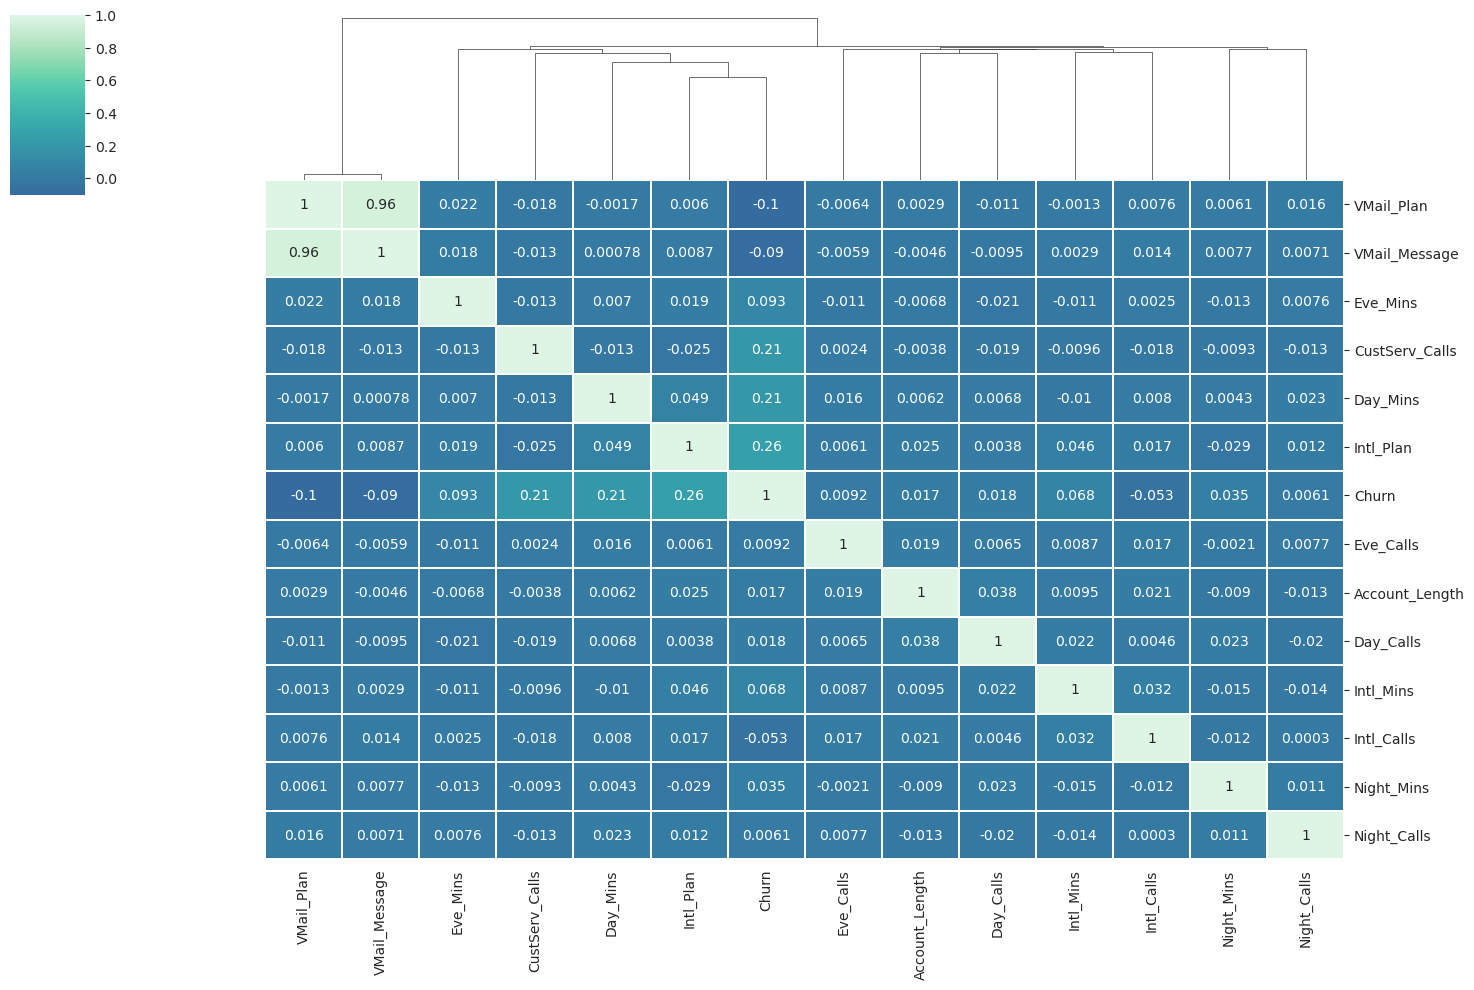

In [52]:
corr = data_chosen.corr()
cg = sns.clustermap(corr, center=0, linewidths=.1, annot = True, 
                    figsize=(15, 10), cmap="mako")
cg.ax_row_dendrogram.set_visible(False)
plt.show();

8) Let's vizualize dictribution for numeric features

In [28]:
data.columns

Index(['State', 'Account_Length', 'Area_Code', 'Phone', 'Intl_Plan',
       'VMail_Plan', 'VMail_Message', 'Day_Mins', 'Day_Calls', 'Day_Charge',
       'Eve_Mins', 'Eve_Calls', 'Eve_Charge', 'Night_Mins', 'Night_Calls',
       'Night_Charge', 'Intl_Mins', 'Intl_Calls', 'Intl_Charge',
       'CustServ_Calls', 'Churn'],
      dtype='object')

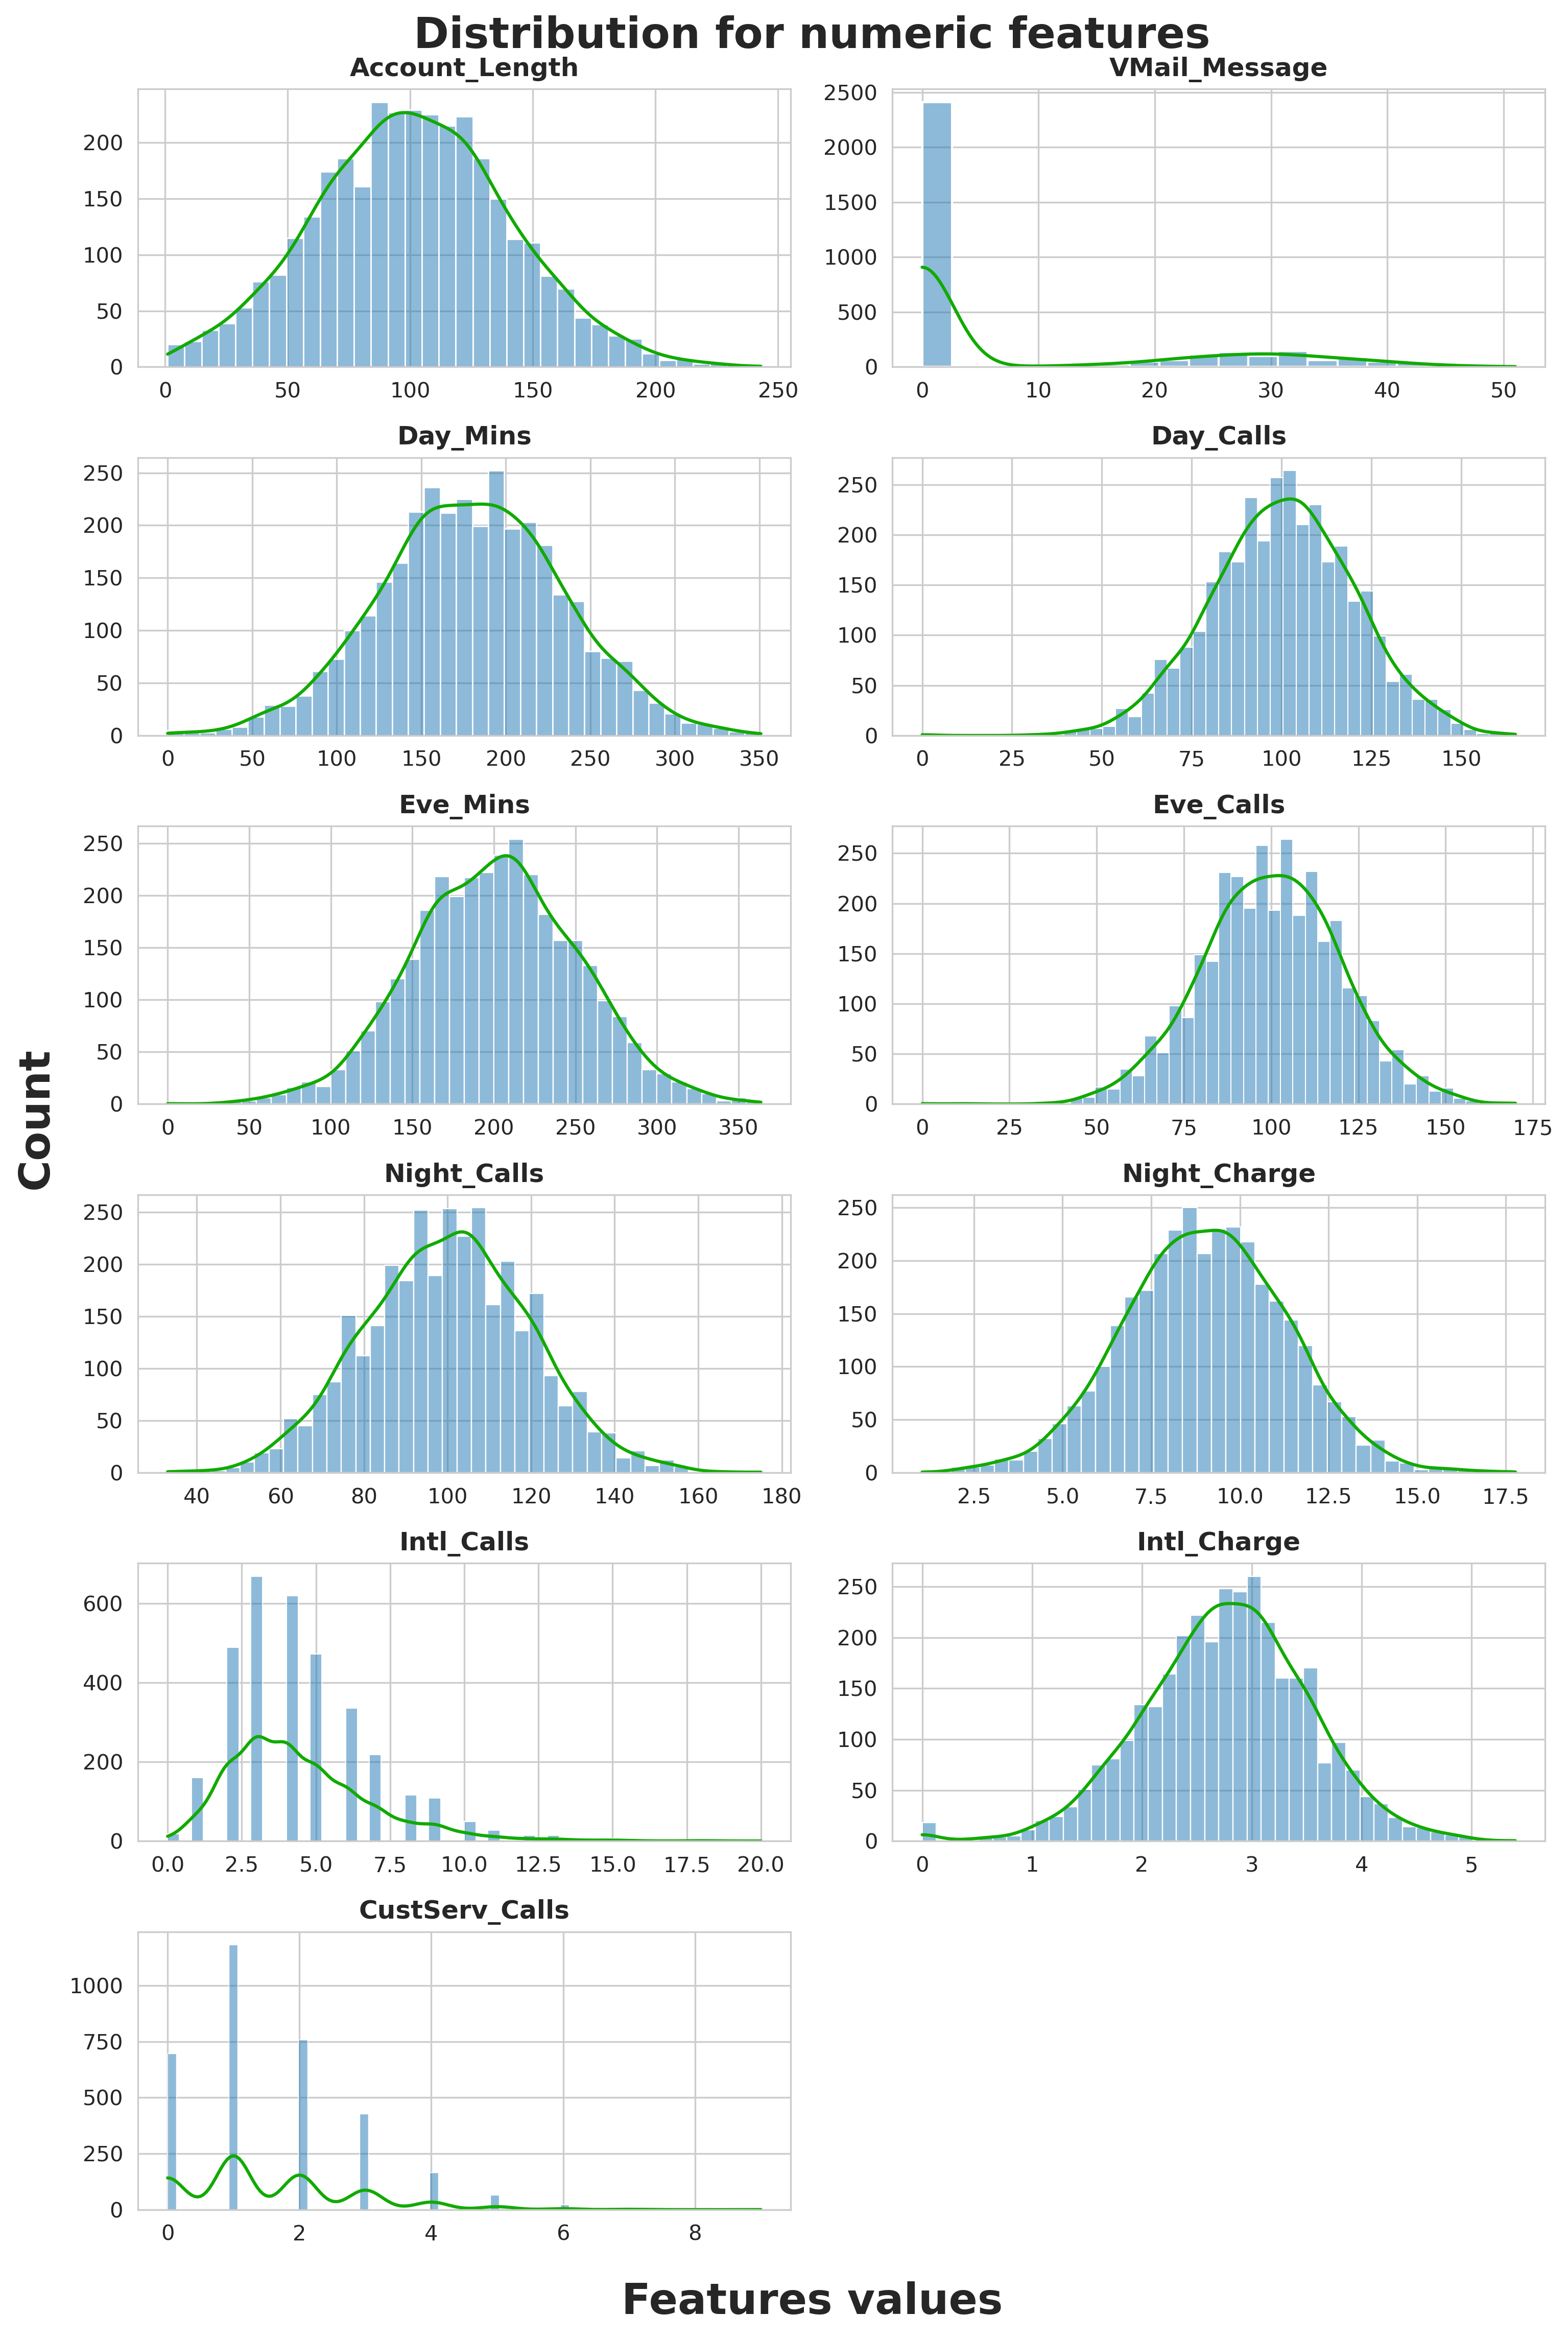

In [53]:
numeric_data = data[['Account_Length', 'VMail_Message', 'Day_Mins', 'Day_Calls', 'Eve_Mins','Eve_Calls',
                    'Night_Calls', 'Night_Charge', 'Intl_Calls', 'Intl_Charge', 'CustServ_Calls']] 

## histplot for numeric features
fig, axes = plt.subplots(ncols=2, nrows=6, figsize=(10, 15), dpi=300)

for i, ax in zip(range(11), axes.flat):
    sns.histplot(numeric_data.iloc[:, i], kde=True, ax=ax)
    ax.set(xlabel='', ylabel='')
    ax.set_title(numeric_data.columns[i], fontsize=12, fontweight='bold')
    ax.lines[0].set_color("#1a0")
    
fig.suptitle("Distribution for numeric features", fontsize=20, fontweight="bold")
fig.text(0.5, -0.02, 'Features values', ha='center', 
         fontsize=20, fontweight='bold')
fig.text(-0.02, 0.5, 'Count', va='center', 
         rotation='vertical', fontsize=20, fontweight='bold')
fig.delaxes(axes[5][1])
plt.tight_layout()
plt.show();

#### Model construction

In [54]:
X = data_chosen.drop(['Churn'], axis=1)
y = data_chosen['Churn']

# spliting train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=SEED)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2233, 13), (2233,), (1100, 13), (1100,))

In [55]:
data_chosen.columns

Index(['Account_Length', 'Intl_Plan', 'VMail_Plan', 'VMail_Message',
       'Day_Mins', 'Day_Calls', 'Eve_Mins', 'Eve_Calls', 'Night_Mins',
       'Night_Calls', 'Intl_Mins', 'Intl_Calls', 'CustServ_Calls', 'Churn'],
      dtype='object')

In [56]:
xgb = xgboost.XGBClassifier(random_state=SEED, verbosity = 0)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)

base_models = [("XGB", xgb), ("XGB_RF", xgb_rf), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("CAT", cat)]

numeric_features = ['Account_Length', 'VMail_Message', 'Day_Mins', 'Day_Calls', 
                    'Eve_Mins', 'Eve_Calls', 'Night_Mins', 'Night_Calls', 
                    'Intl_Mins', 'Intl_Calls', 'CustServ_Calls']
bool_features = ['Intl_Plan', 'VMail_Plan']
categ_feature = ["State"]

preproccessor = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), numeric_features),
])

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

metrics = [accuracy_score, precision_score, recall_score, f1_score]

In [57]:
def build_base_models(base_models, X_train, X_test, y_train, y_test):
    for i, model in enumerate(base_models):
        pipeline = make_pipeline(preproccessor, model[1])
        pipeline.fit(X_train, y_train)
        scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring="f1")
        print(f'\n{model[1].__class__.__name__} cross val f1-score: {scores.mean()}')

        y_pred = pipeline.predict(X_test)
        y_score = pipeline.predict_proba(X_test)

        for metric in metrics:
            if accuracy_score:
                print(f'{metric.__name__}: {metric(y_test, y_pred)}')
            else:
                print(f'{metric.__name__}: {metric(y_test, y_pred, average="macro")}')

        print(classification_report(y_test, y_pred))

        conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=pipeline[1].classes_)    
        axes1.flat[i].set_title(f'Confusion matrix for {model[1].__class__.__name__}', fontsize=10, fontweight='bold')
        ConfusionMatrixDisplay(conf_mat, display_labels=pipeline[1].classes_).plot(ax = axes1.flat[i], cmap="summer")


        axes2.flat[i].set_title(f'ROC curve for {model[1].__class__.__name__}', size=10, weight='bold')
        RocCurveDisplay.from_estimator(pipeline, X_test, y_test, color="#1a0", ax=axes2.flat[i])
        axes2.flat[i].plot([0, 1], color='b', linestyle=(0, (3, 10, 1, 10)))


XGBClassifier cross val f1-score: 0.6606082104996158
accuracy_score: 0.9254545454545454
precision_score: 0.8532110091743119
recall_score: 0.5849056603773585
f1_score: 0.6940298507462686
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       941
           1       0.85      0.58      0.69       159

    accuracy                           0.93      1100
   macro avg       0.89      0.78      0.83      1100
weighted avg       0.92      0.93      0.92      1100


XGBRFClassifier cross val f1-score: 0.636164419105033
accuracy_score: 0.9190909090909091
precision_score: 0.8431372549019608
recall_score: 0.5408805031446541
f1_score: 0.6590038314176245
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       941
           1       0.84      0.54      0.66       159

    accuracy                           0.92      1100
   macro avg       0.88      0.76      0.81      1100
weighted avg       0.91   

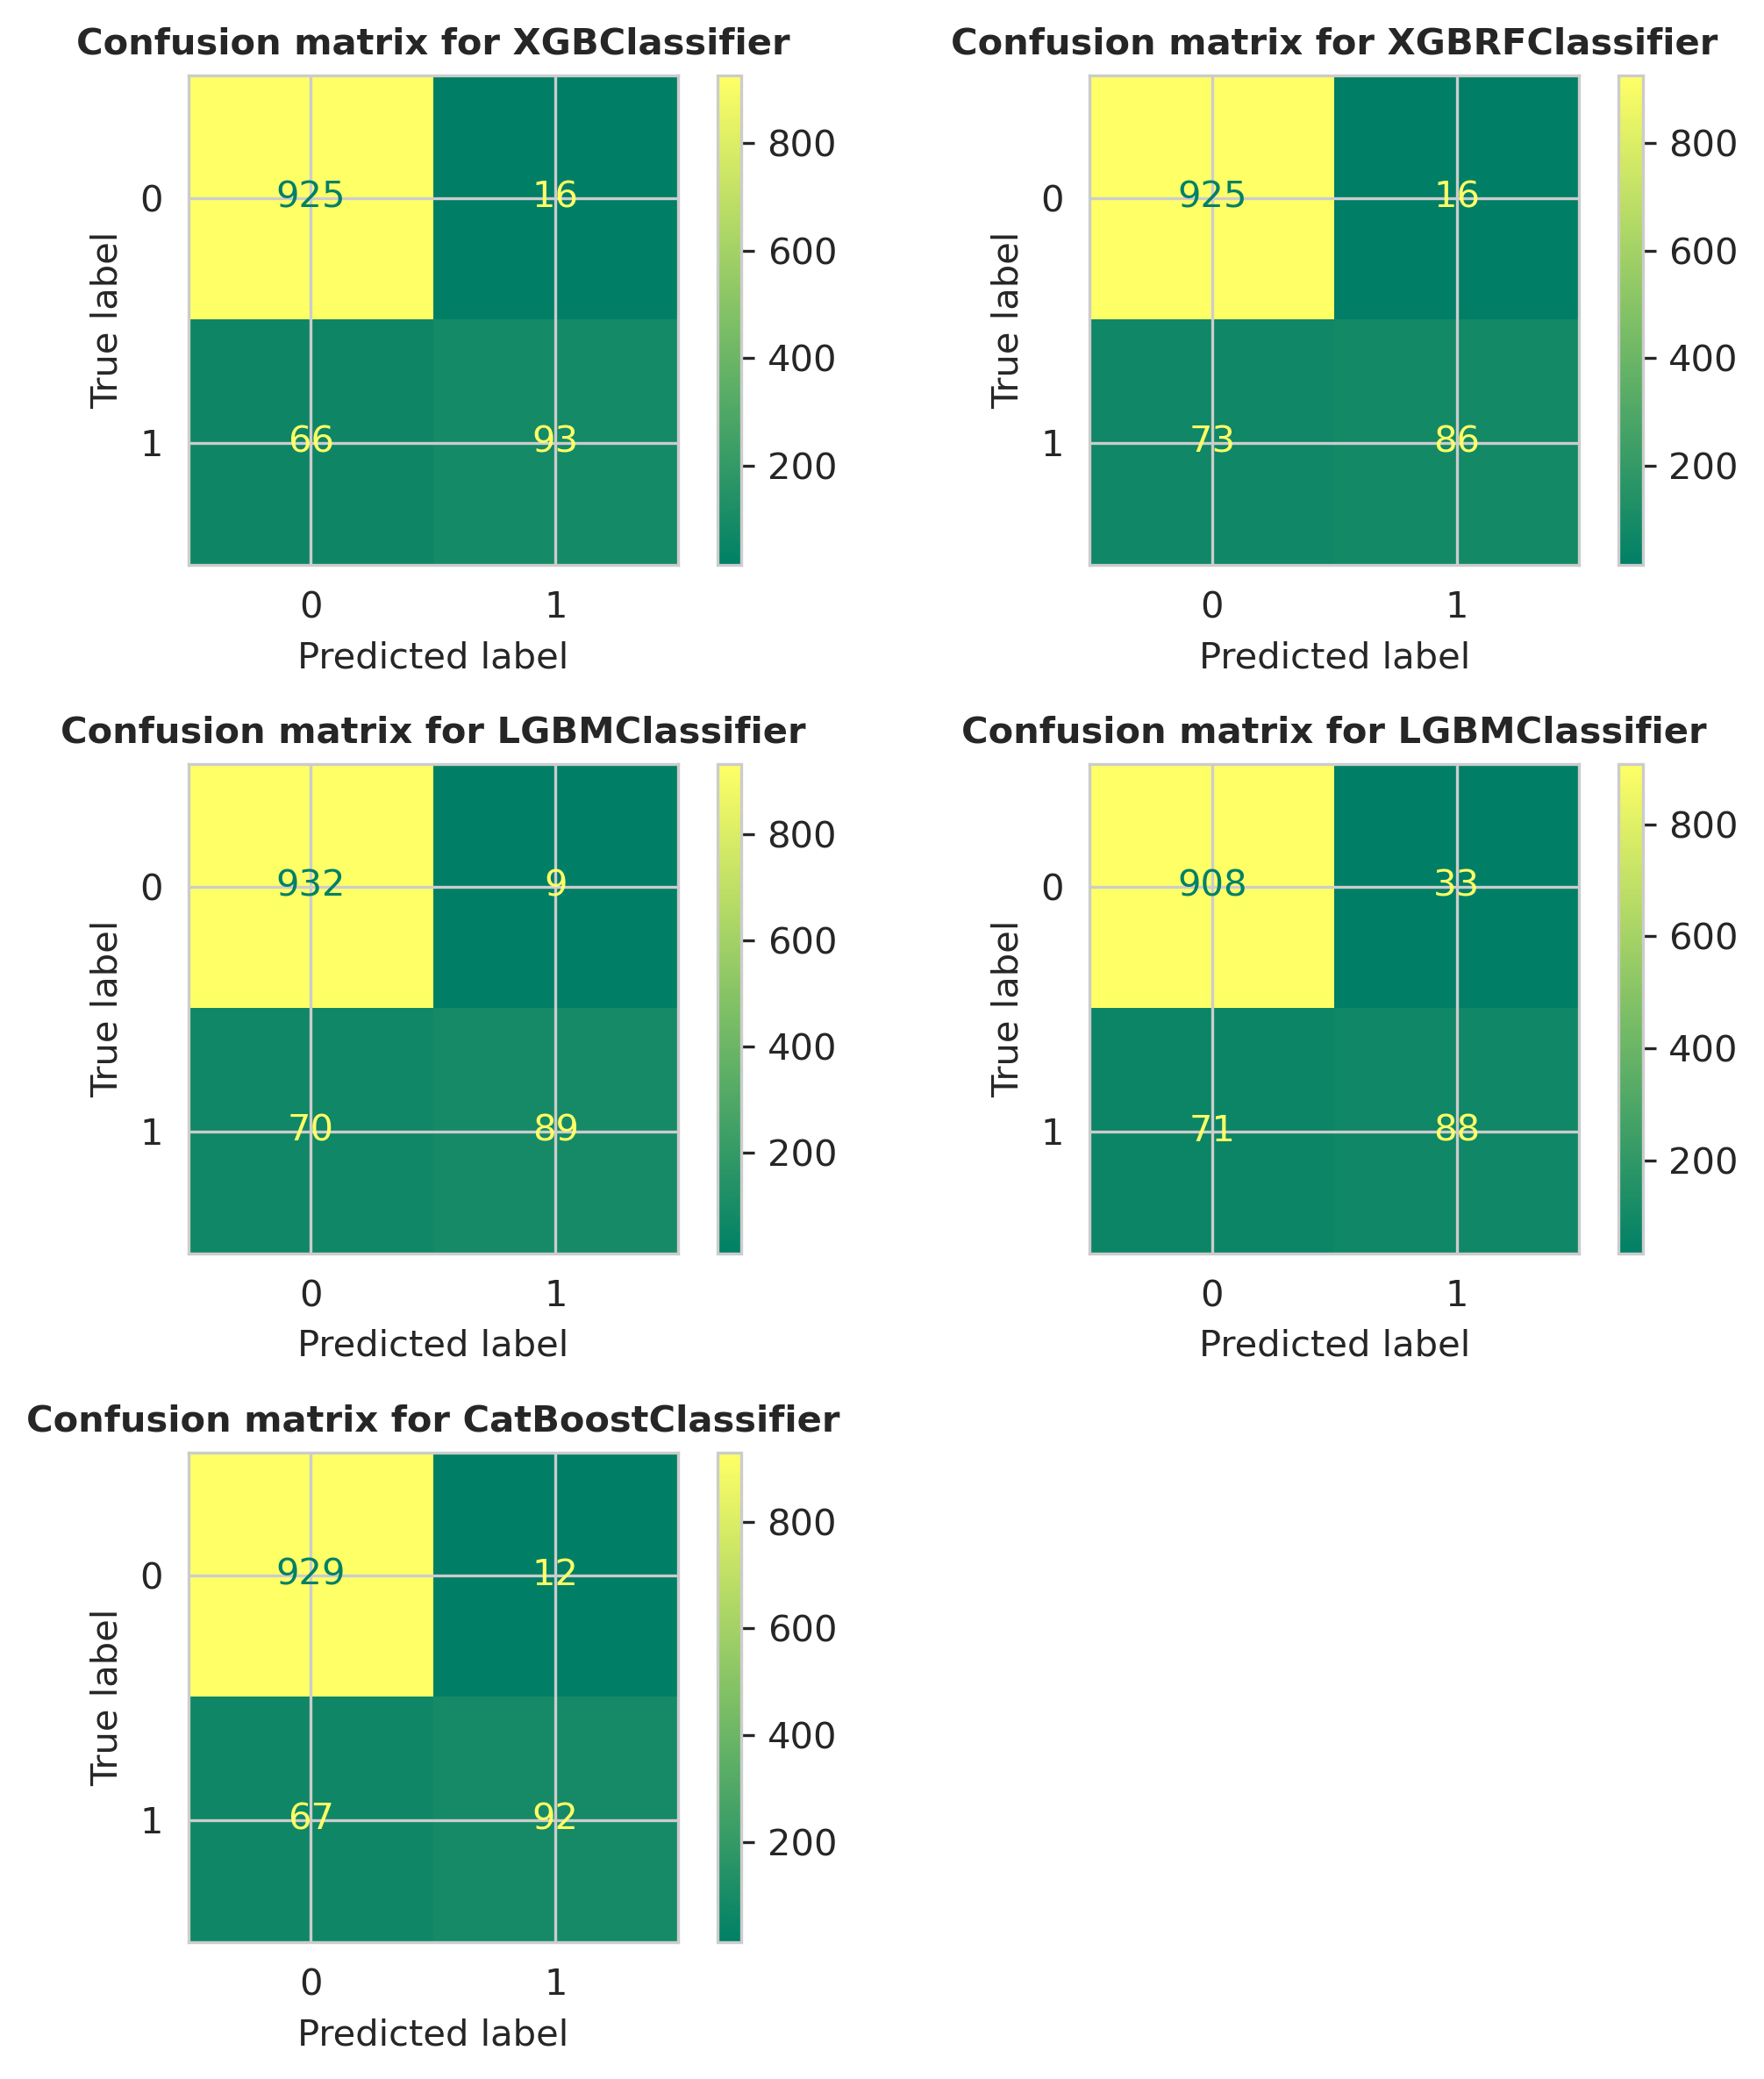

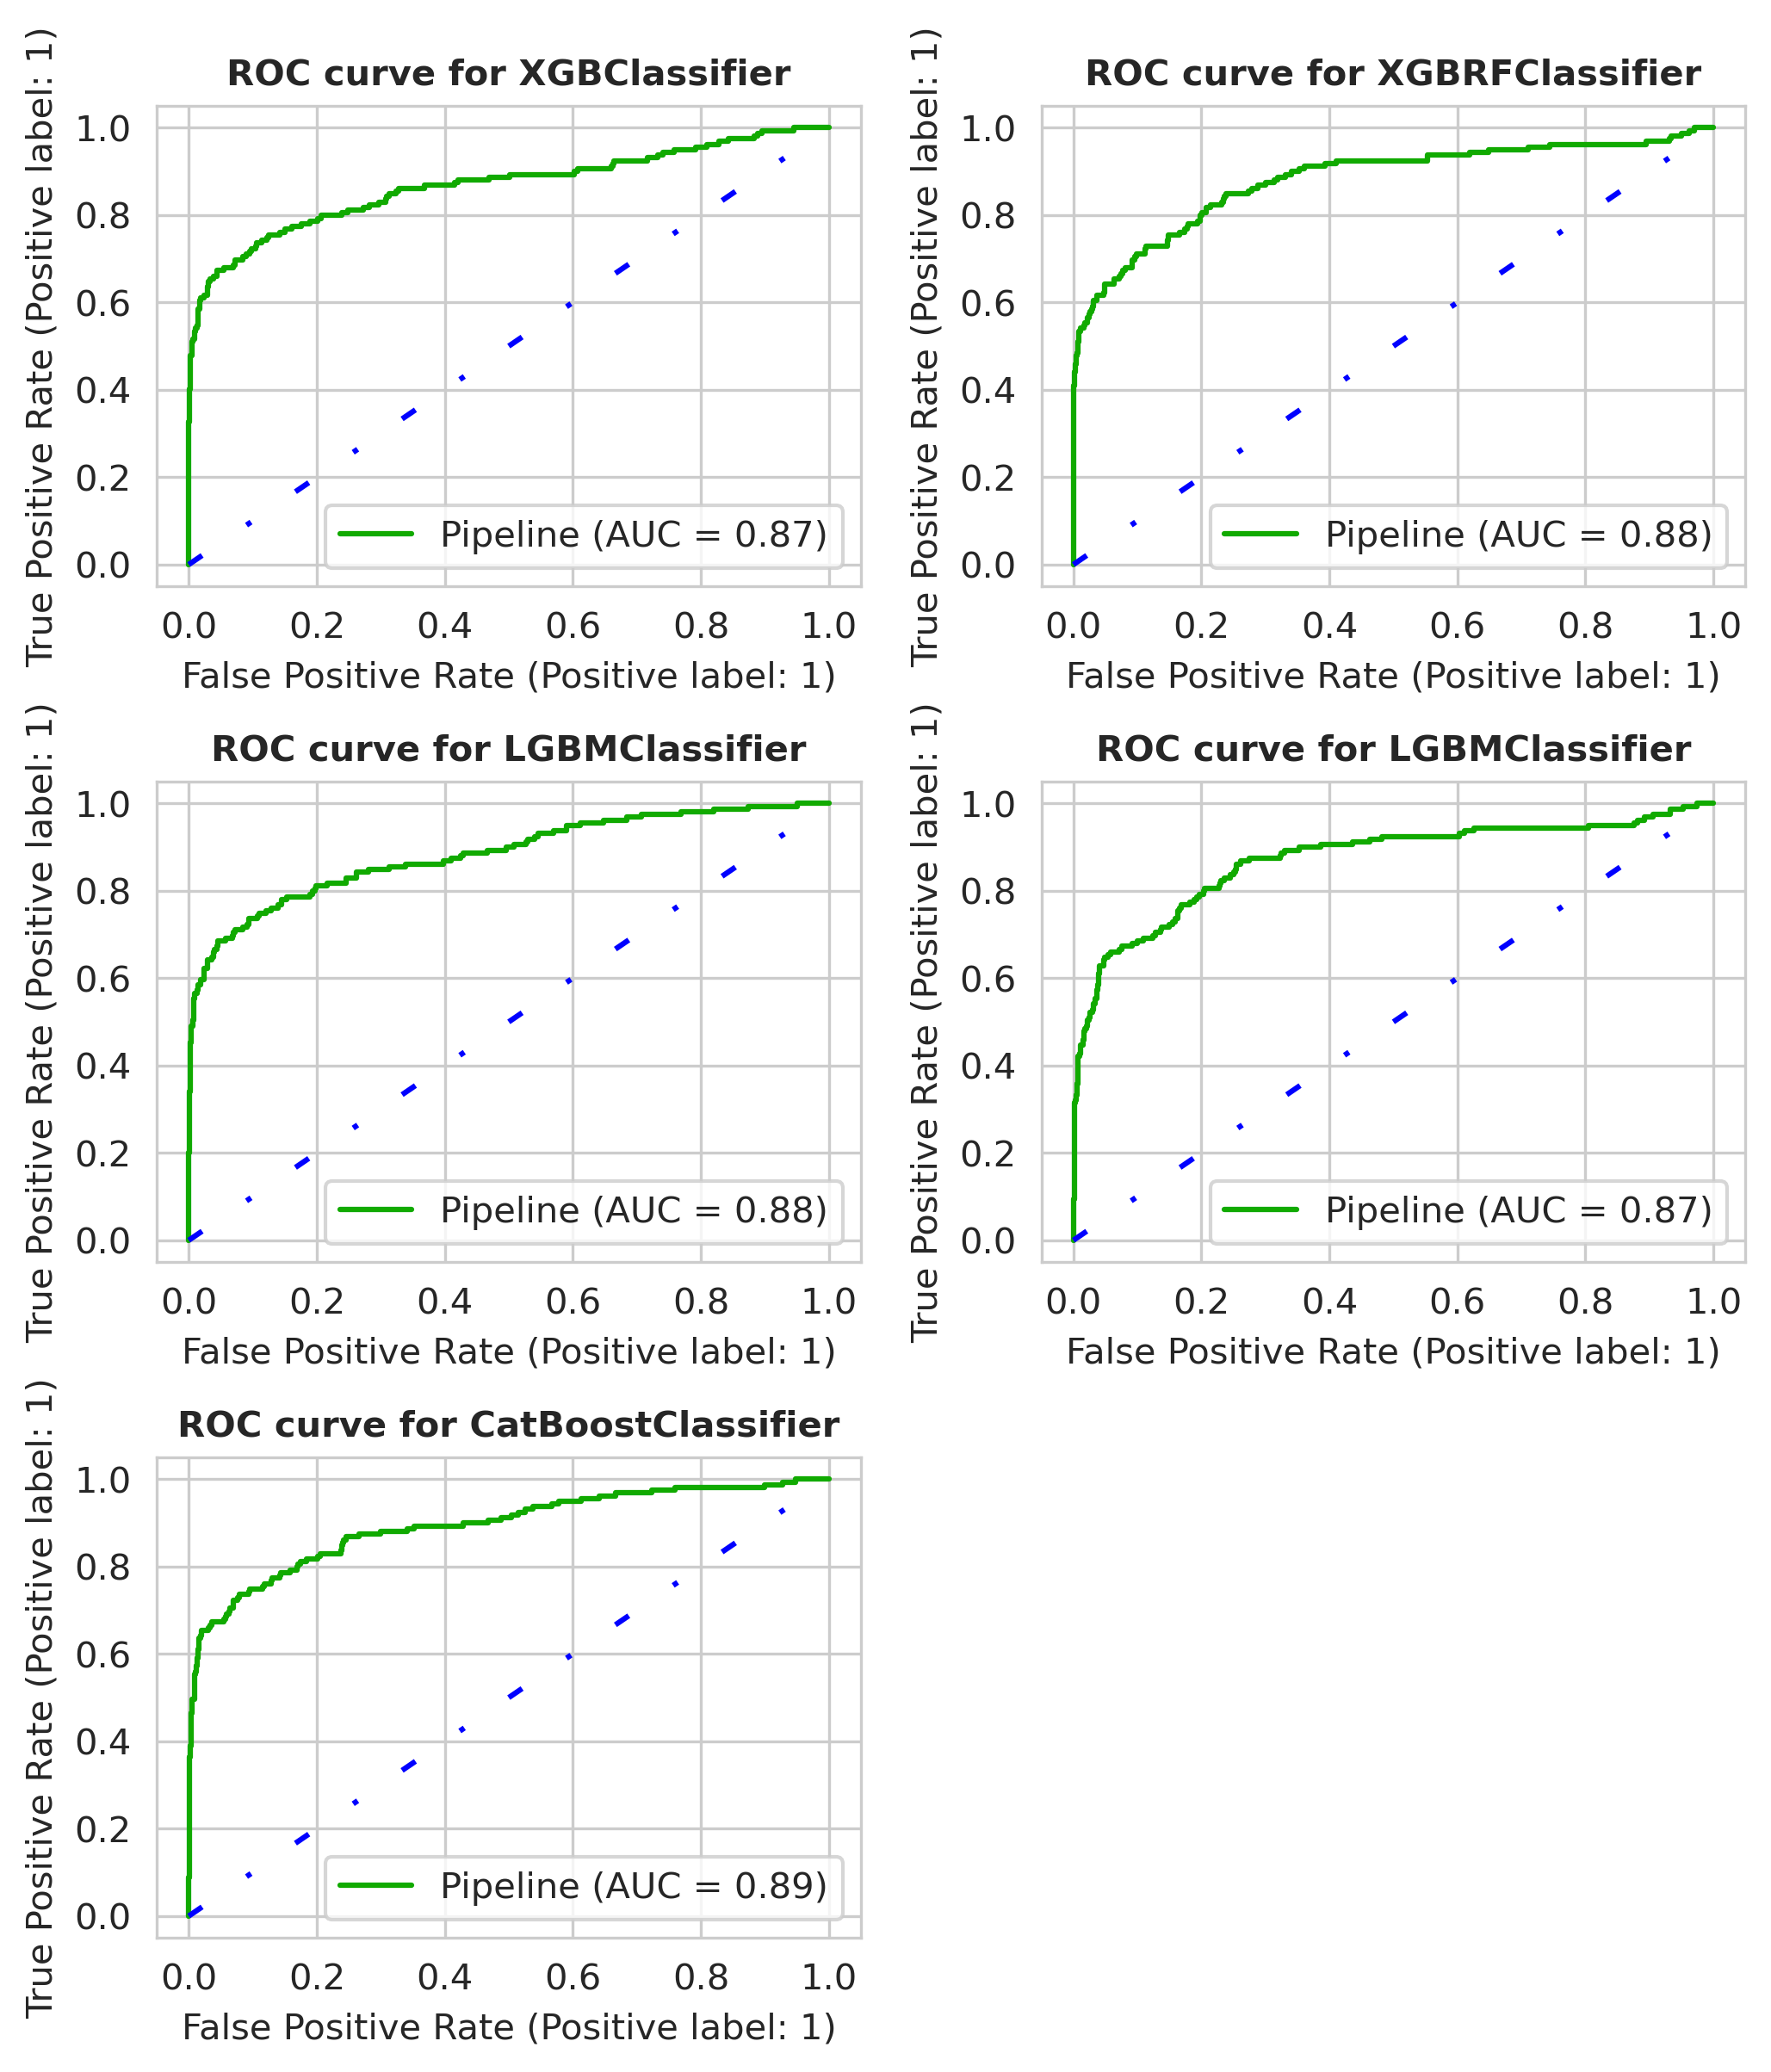

In [58]:
fig1, axes1 = plt.subplots(ncols=2, nrows=3, figsize=(7, 8), dpi=300)
fig2, axes2 = plt.subplots(ncols=2, nrows=3, figsize=(7, 8), dpi=300)

build_base_models(base_models, X_train, X_test, y_train, y_test)

fig1.delaxes(axes1[2][1])
fig2.delaxes(axes2[2][1])
fig1.tight_layout()
fig2.tight_layout()
plt.show();

I have chosen two models for further analysis: `XGBRFClassifier` and `CatBoostClassifier`. It is time to deal with inbalanced classes. I decided to try two methods: *oversampling the smallest class* via `SMOTE` and *class weighting* by specifying `class_weight` parameter for classification models.

##### Oversampling the smallest class via `SMOTE`

In [60]:
over_sampler = RandomOverSampler(sampling_strategy=1, random_state=SEED)
X_res, y_res = over_sampler.fit_resample(X_train, y_train)
print(f"Training target statistics before RandomOverSampler:\n{y_train.value_counts()}")
print(f"Training target statistics after RandomOverSampler:\n{y_res.value_counts()}")

Training target statistics before RandomOverSampler:
0    1909
1     324
Name: Churn, dtype: int64
Training target statistics after RandomOverSampler:
0    1909
1    1909
Name: Churn, dtype: int64



XGBClassifier cross val f1-score: 0.9806735160641236
accuracy_score: 0.92
precision_score: 0.7669172932330827
recall_score: 0.6415094339622641
f1_score: 0.6986301369863013
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       941
           1       0.77      0.64      0.70       159

    accuracy                           0.92      1100
   macro avg       0.85      0.80      0.83      1100
weighted avg       0.92      0.92      0.92      1100


XGBRFClassifier cross val f1-score: 0.8486191401068691
accuracy_score: 0.8836363636363637
precision_score: 0.5778894472361809
recall_score: 0.7232704402515723
f1_score: 0.6424581005586592
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       941
           1       0.58      0.72      0.64       159

    accuracy                           0.88      1100
   macro avg       0.76      0.82      0.79      1100
weighted avg       0.90      0.88      

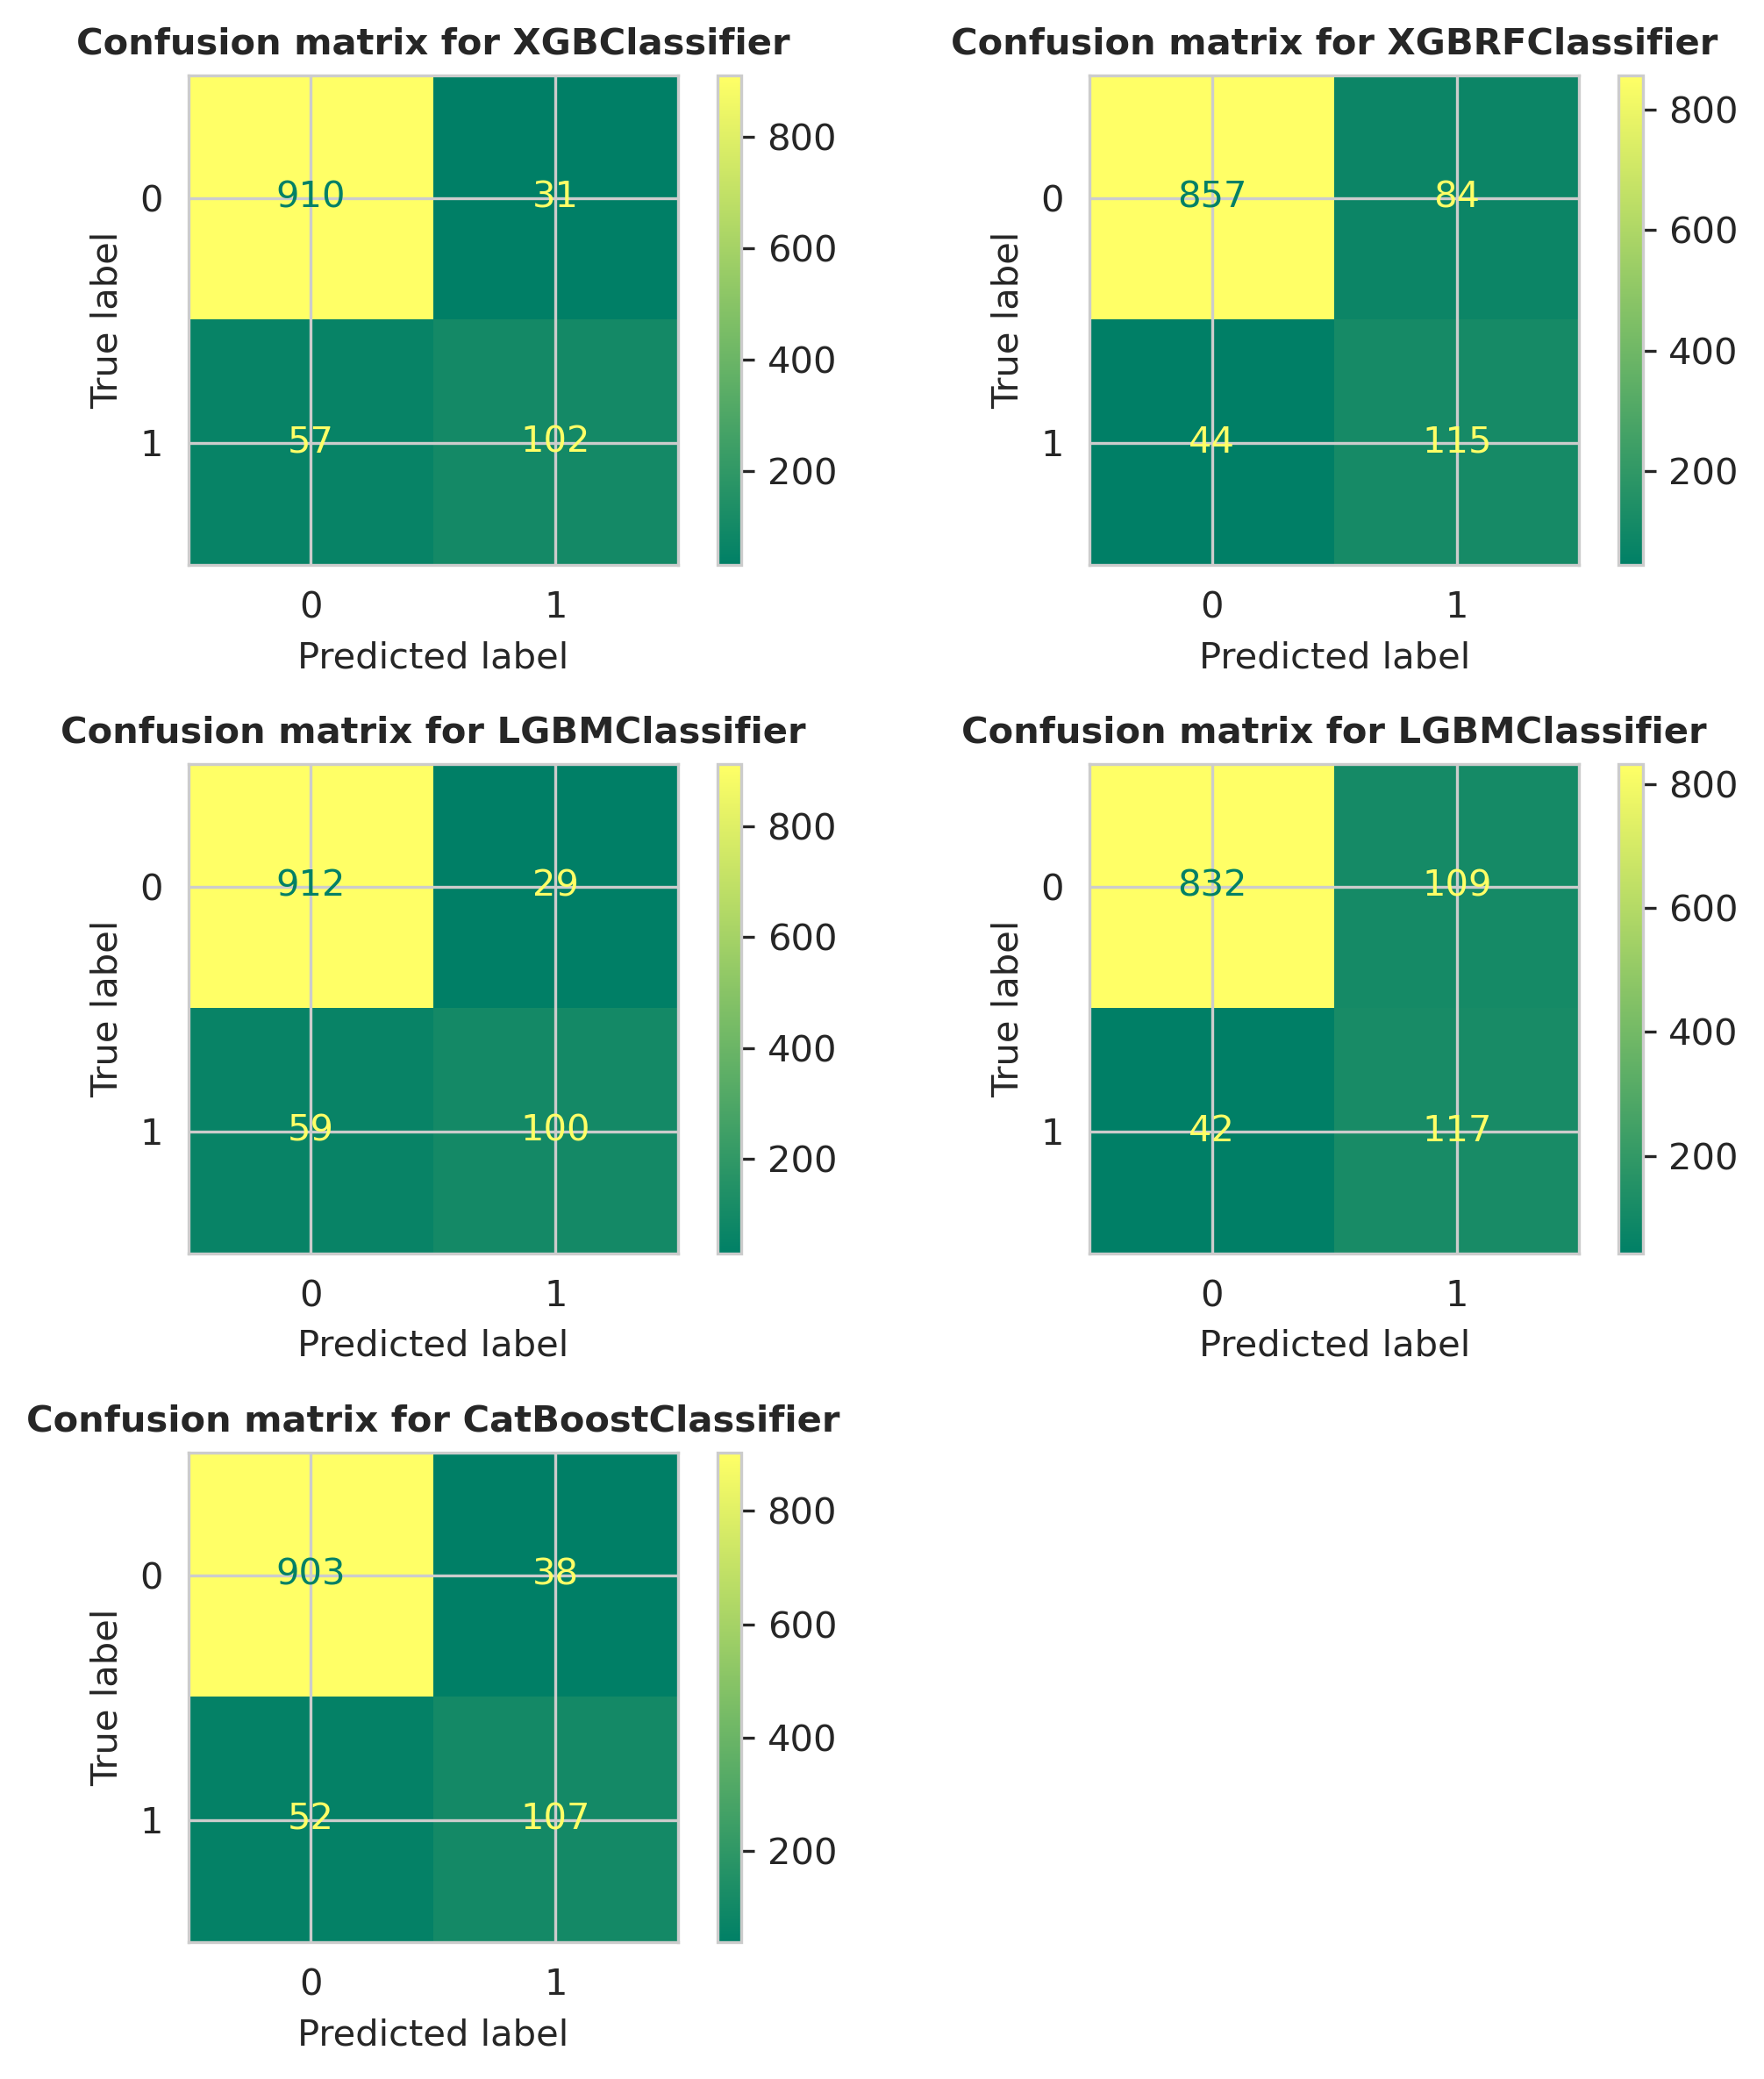

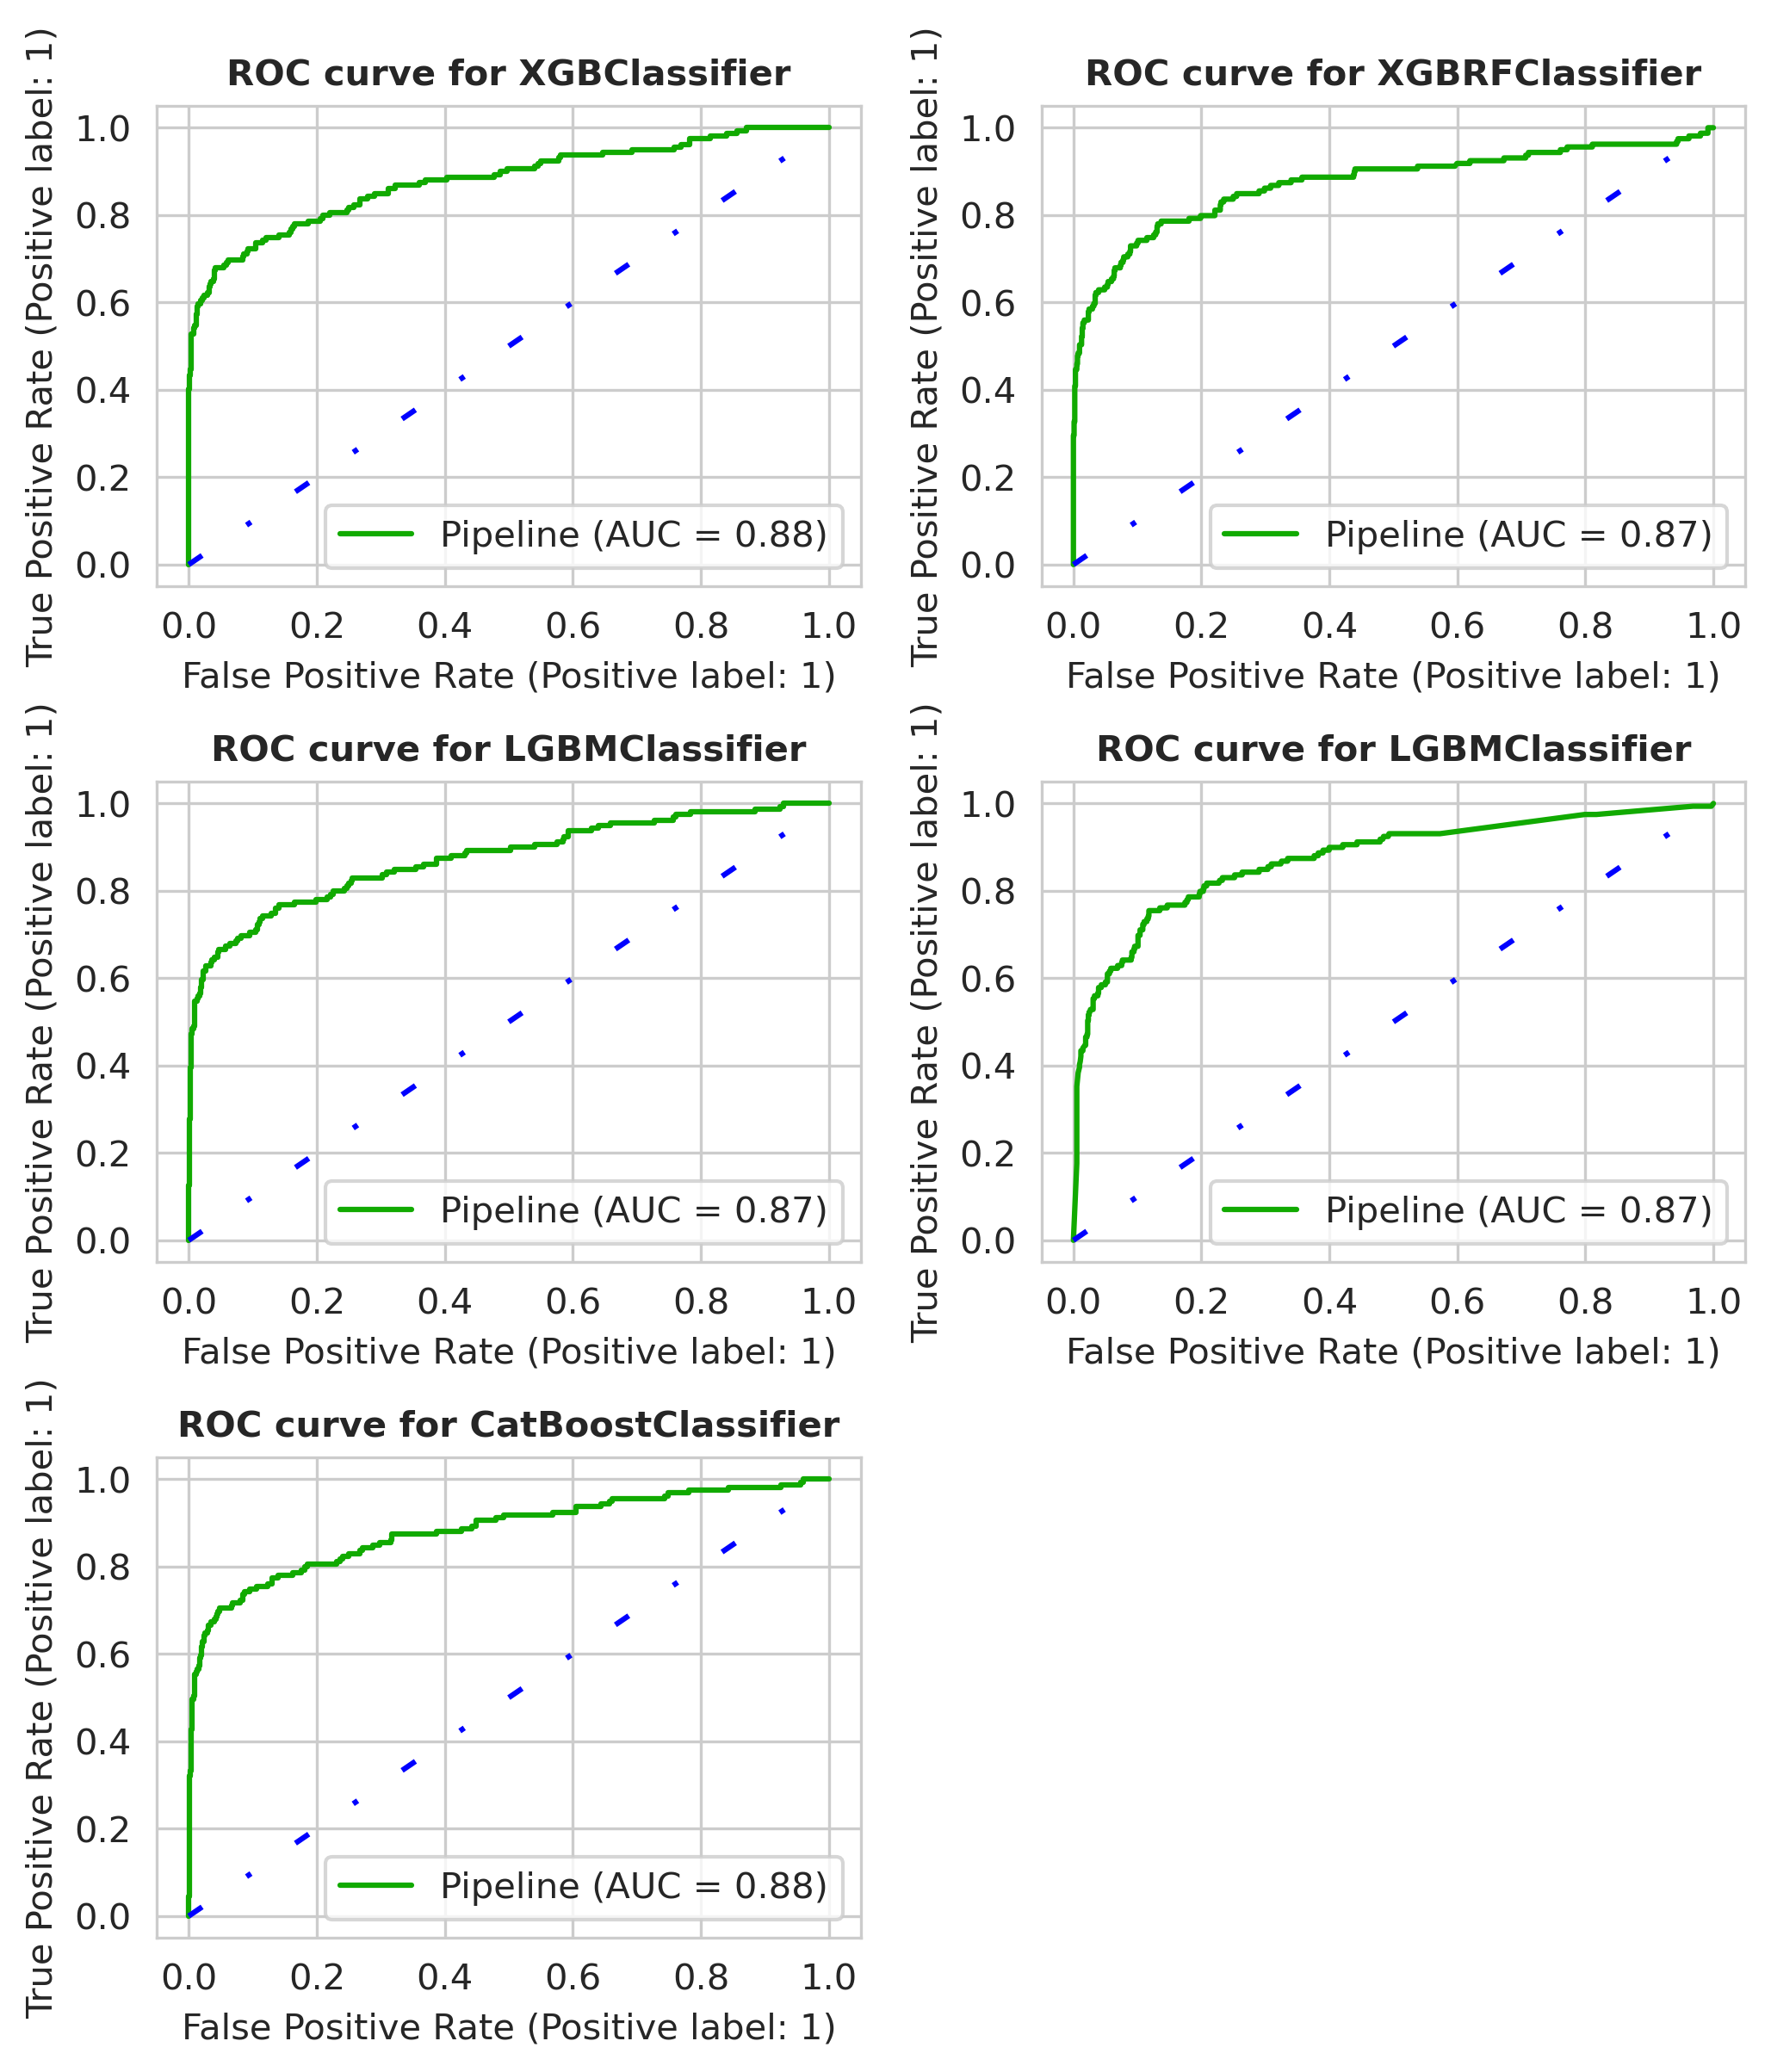

In [61]:
fig1, axes1 = plt.subplots(ncols=2, nrows=3, figsize=(7, 8), dpi=300)
fig2, axes2 = plt.subplots(ncols=2, nrows=3, figsize=(7, 8), dpi=300)

build_base_models(base_models, X_res, X_test, y_res, y_test)

fig1.delaxes(axes1[2][1])
fig2.delaxes(axes2[2][1])
fig1.tight_layout()
fig2.tight_layout()
plt.show();


XGBRFClassifier cross val f1-score: 0.8486191401068691
accuracy_score: 0.8836363636363637
precision_score: 0.5778894472361809
recall_score: 0.7232704402515723
f1_score: 0.6424581005586592
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       941
           1       0.58      0.72      0.64       159

    accuracy                           0.88      1100
   macro avg       0.76      0.82      0.79      1100
weighted avg       0.90      0.88      0.89      1100


CatBoostClassifier cross val f1-score: 0.9657041285878959
accuracy_score: 0.9181818181818182
precision_score: 0.7379310344827587
recall_score: 0.6729559748427673
f1_score: 0.7039473684210527
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       941
           1       0.74      0.67      0.70       159

    accuracy                           0.92      1100
   macro avg       0.84      0.82      0.83      1100
weighted avg       0

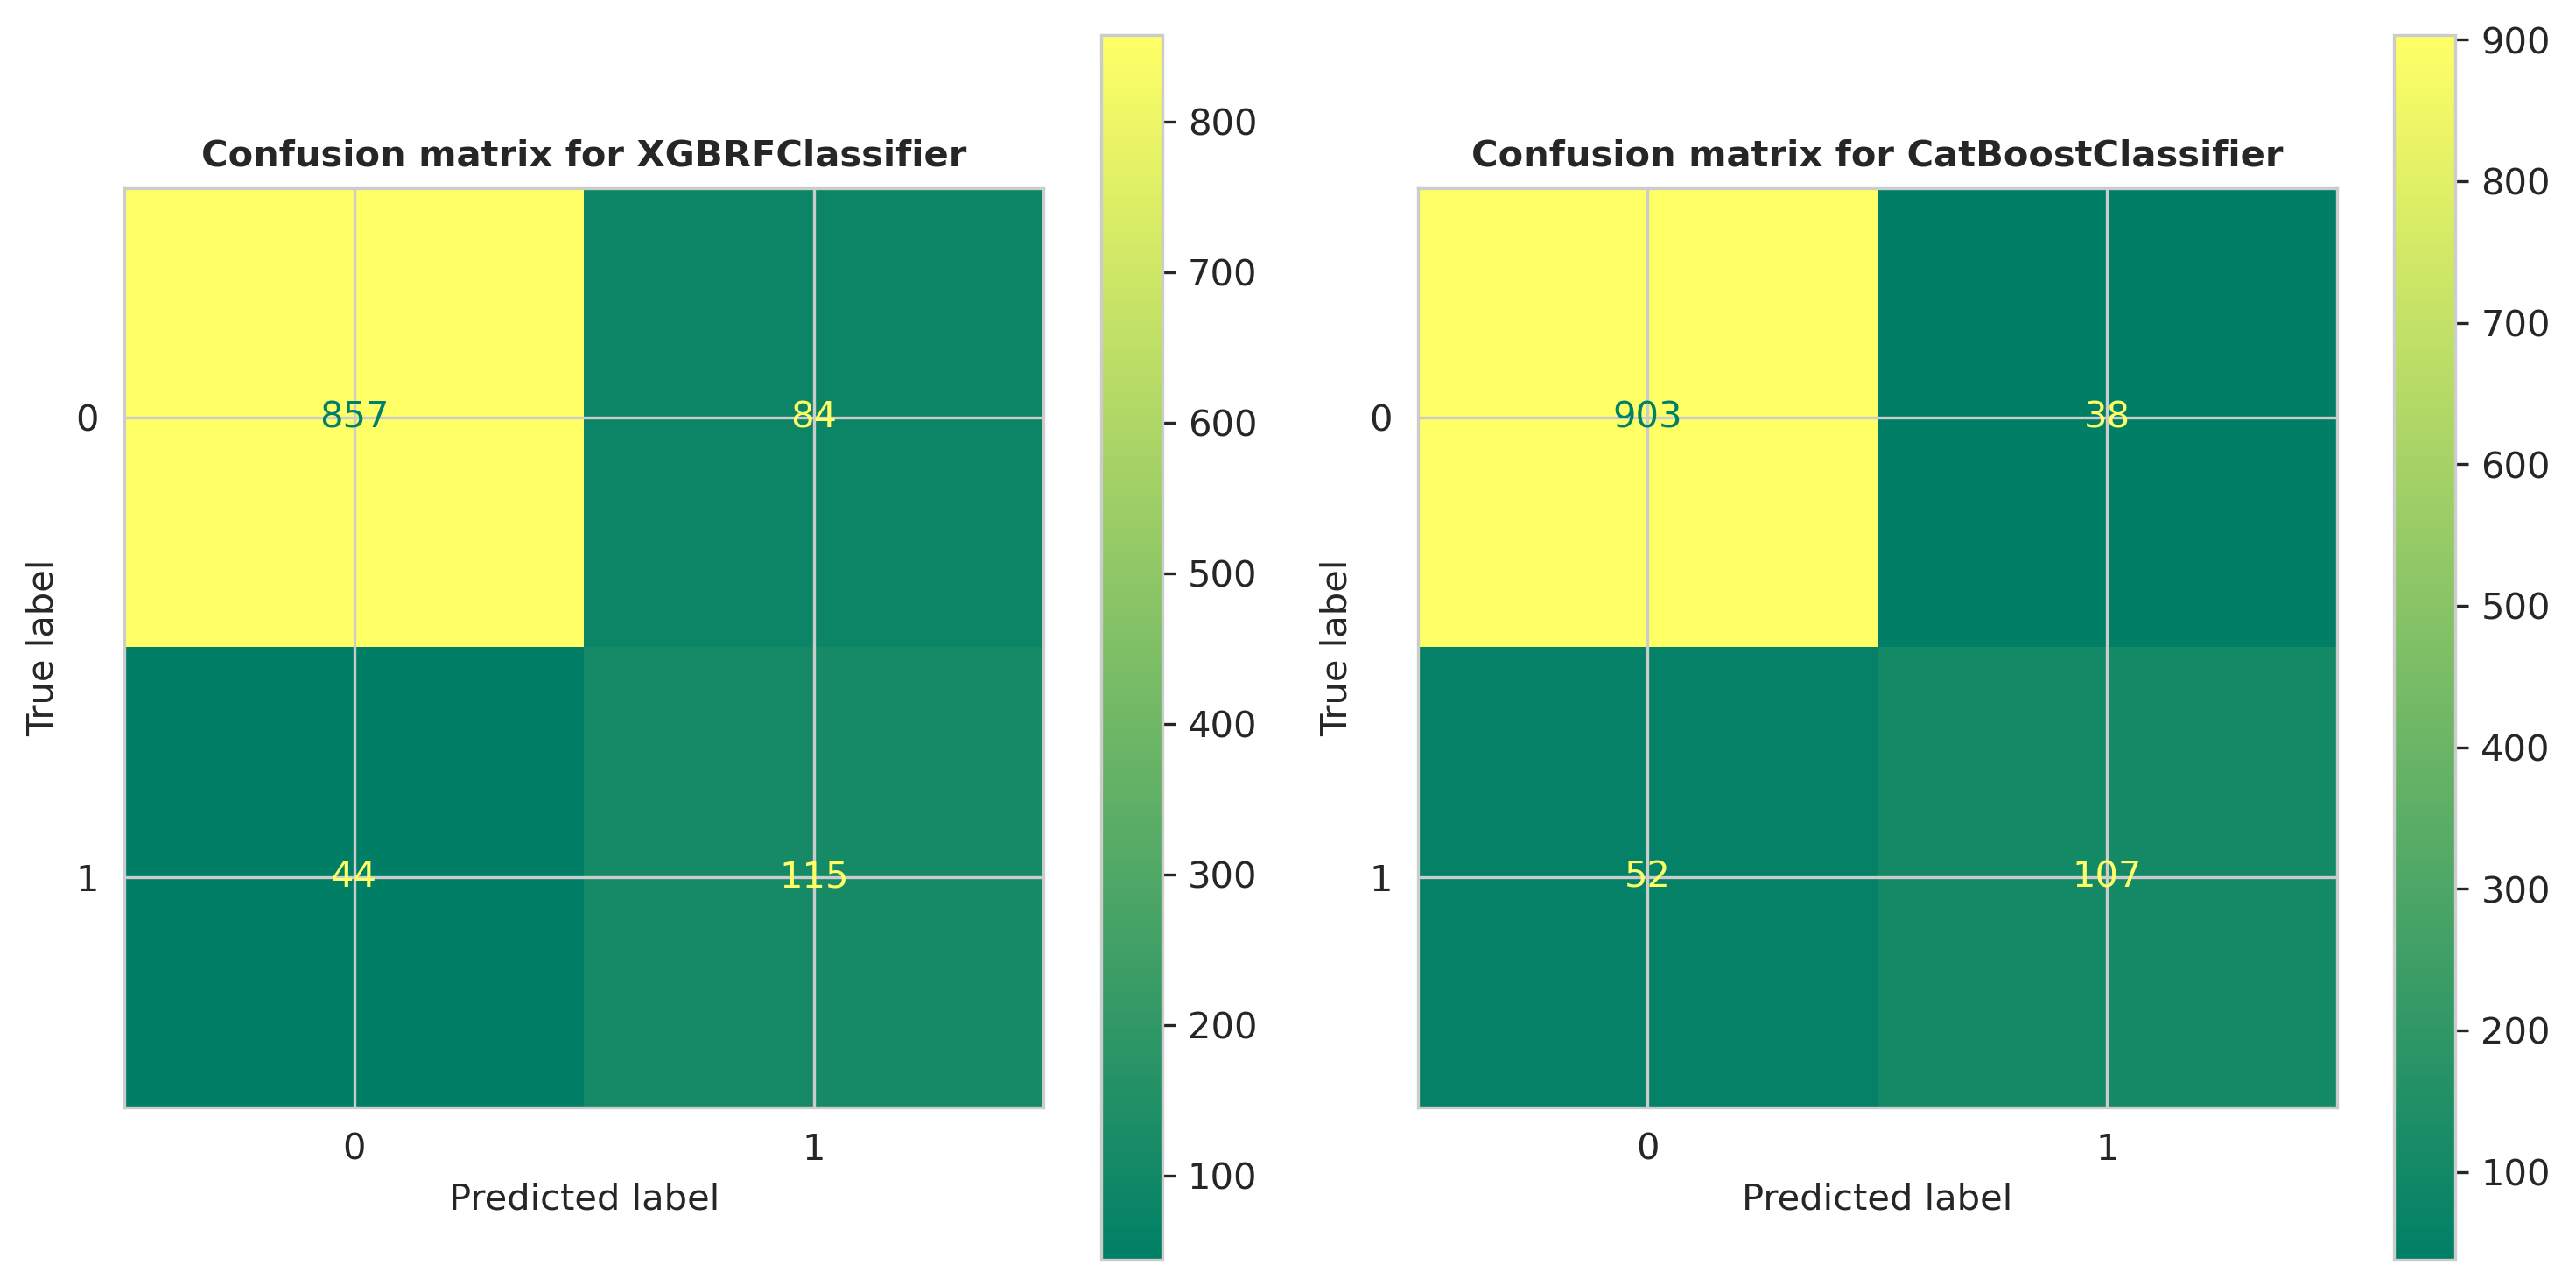

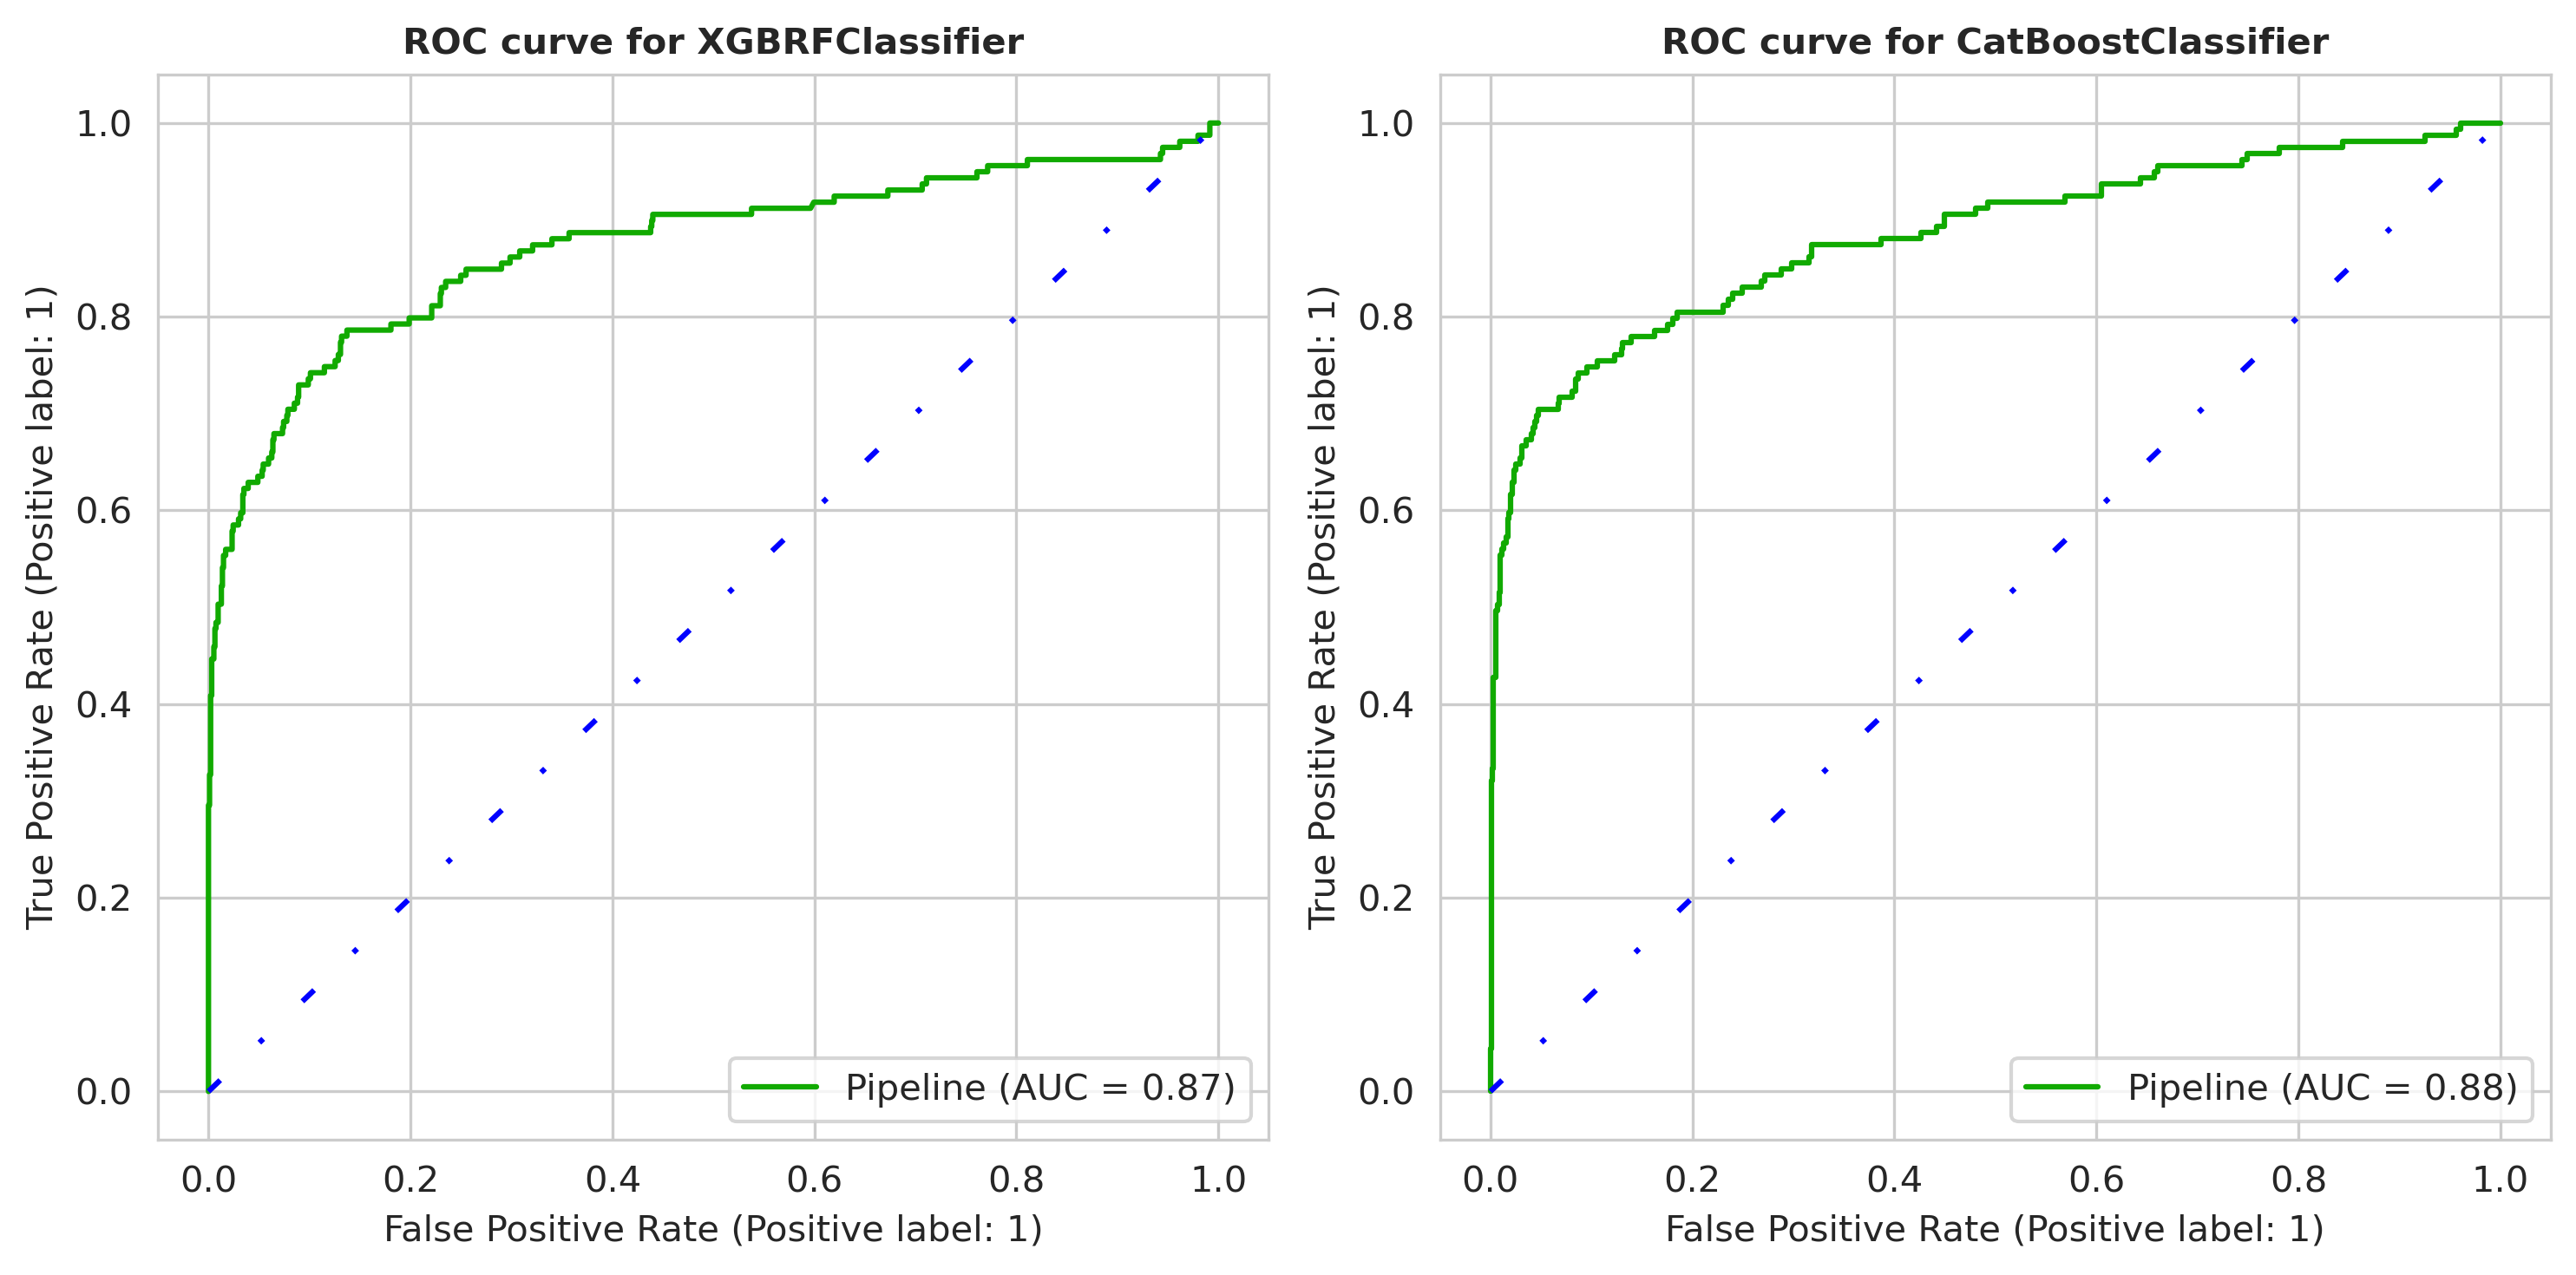

In [47]:
models = [("XGB_RF", xgb_rf), ("CAT", cat)]

fig1, axes1 = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), dpi=300)
fig2, axes2 = plt.subplots(ncols=2, nrows=1, figsize=(10, 5), dpi=300)
build_base_models(models, X_res, X_test, y_res, y_test)
fig1.tight_layout()
fig2.tight_layout()
plt.show();

In [73]:
def tuning_model(model, param_grid, X_res, X_test, y_res, y_test):
    pipeline = make_pipeline(preproccessor, model)
    grid_pipeline = GridSearchCV(pipeline, param_grid=param_grid, cv=cv, scoring='f1_macro', n_jobs=-1)
    grid_pipeline.fit(X_res, y_res)
    print(grid_pipeline.best_estimator_)
    print(grid_pipeline.best_params_)
    print(grid_pipeline.best_score_)
    
    y_pred = grid_pipeline.best_estimator_.predict(X_test)

    for metric in metrics:
        if accuracy_score:
            print(f'{metric.__name__}: {metric(y_test, y_pred)}')
        else:
            print(f'{metric.__name__}: {metric(y_test, y_pred, average="macro")}')

    print(classification_report(y_test, y_pred))

    fig, axes = plt.subplots(2, 1, dpi=300)
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)    
    axes[0].set_title(f'Confusion matrix for {pipeline[1].__class__.__name__}', fontsize=10, fontweight='bold')
    ConfusionMatrixDisplay(conf_mat).plot(ax = axes[0], cmap="summer")

    axes[1].set_title(f'ROC curve for {pipeline[1].__class__.__name__}', size=10, weight='bold')
    RocCurveDisplay.from_estimator(grid_pipeline.best_estimator_, X_test, y_test, color="#1a0", ax=axes[1])
    axes[1].plot([0, 1], color='b', linestyle=(0, (3, 10, 1, 10)))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['Account_Length',
                                                   'VMail_Message', 'Day_Mins',
                                                   'Day_Calls', 'Eve_Mins',
                                                   'Eve_Calls', 'Night_Mins',
                                                   'Night_Calls', 'Intl_Mins',
                                                   'Intl_Calls',
                                                   'CustServ_Calls'])])),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x7ff9d3c8a790>)])
{'catboostclassifier__learning_rate': 0.05, 'catboostclassifier__max_depth': 10, 'catboostclassifier__n_estimators': 300}
0.9845368879522123
accuracy_score: 0.9290909090909091
precision_score: 0.8521739130434782
recall_score: 0.6163522012578616

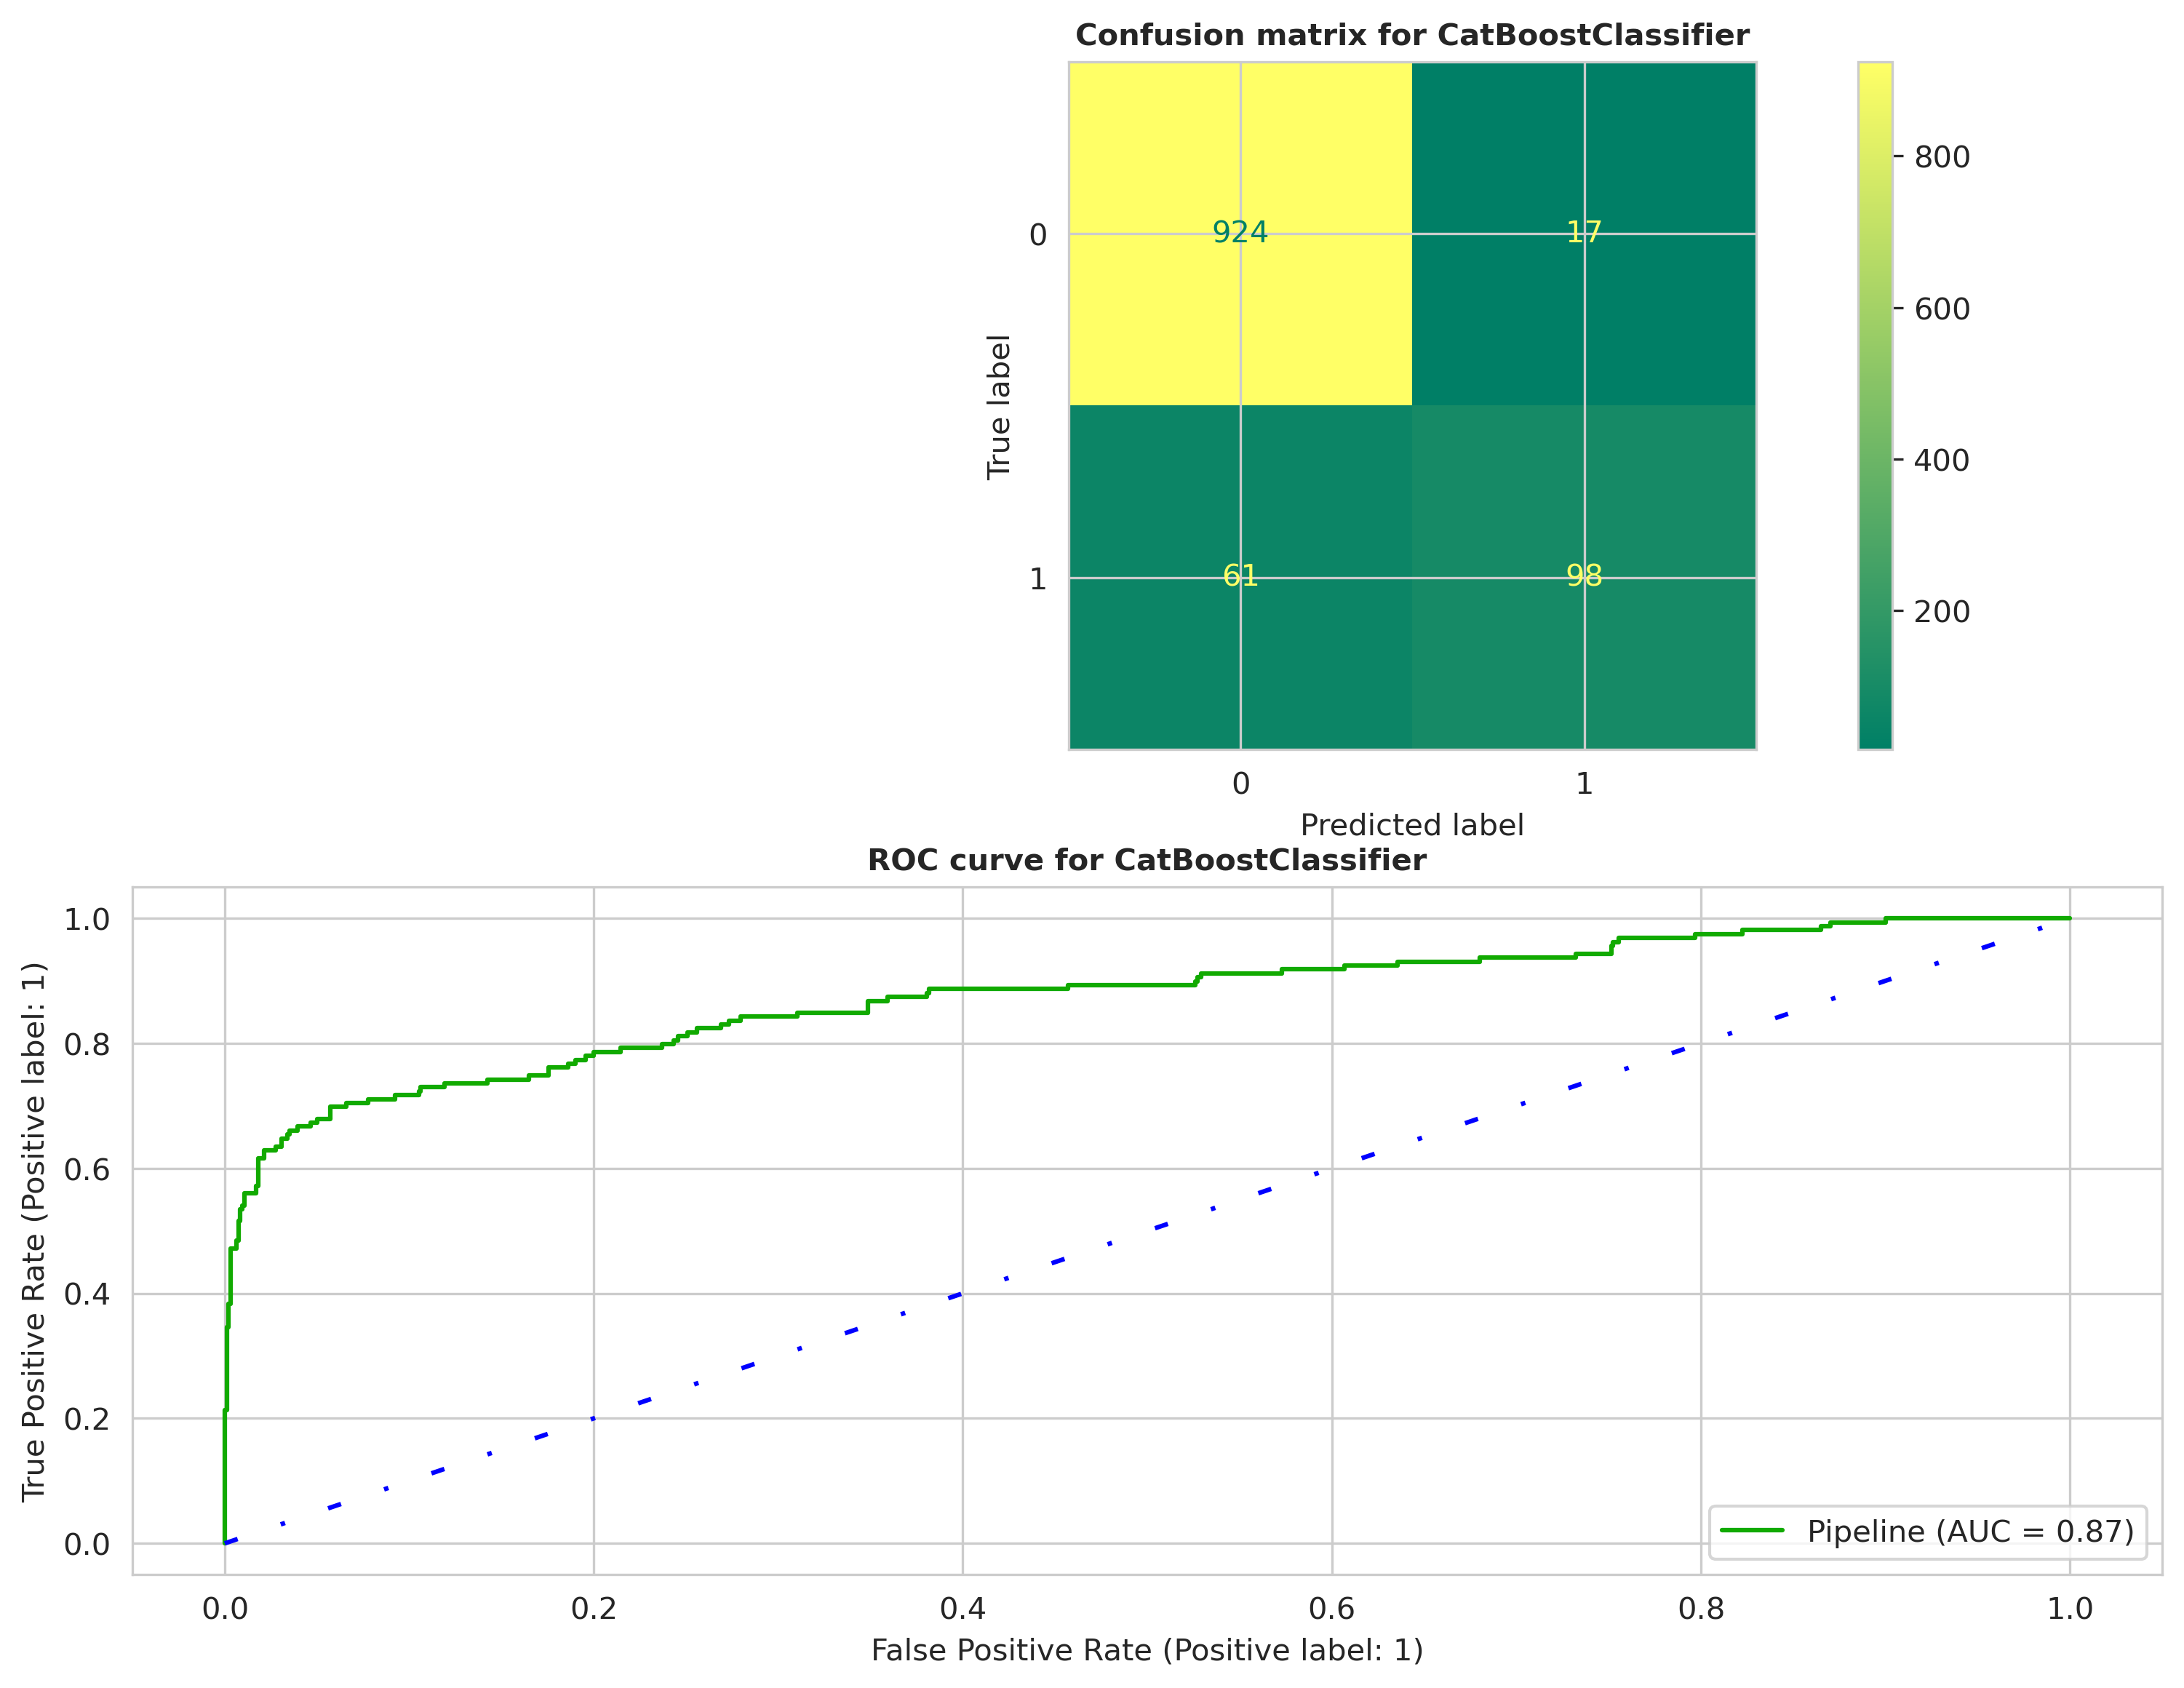

In [88]:
preproccessor = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), numeric_features),
])
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
metrics = [accuracy_score, precision_score, recall_score, f1_score]

cat_grid = {
        'catboostclassifier__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 1],
        'catboostclassifier__max_depth': [2, 3, 5, 8, 10], 
        'catboostclassifier__n_estimators': [100, 200, 300],
        # 'catboostclassifier__subsample': np.arange(0.5, 1.25, 0.25)
        }

tuning_model(cat, cat_grid, X_res, X_test, y_res, y_test)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['Account_Length',
                                                   'VMail_Message', 'Day_Mins',
                                                   'Day_Calls', 'Eve_Mins',
                                                   'Eve_Calls', 'Night_Mins',
                                                   'Night_Calls', 'Intl_Mins',
                                                   'Intl_Calls',
                                                   'CustServ_Calls'])])),
                ('xgbrfclassifier',
                 XGBRFClassifier(base_score=None, booster='gbtree',
                                 callbacks=None, colsample_bylevel...
                                 grow_policy=None, importance_type=None,
                                 interaction_constraints=None,
                                 learning_rate=0.01, 

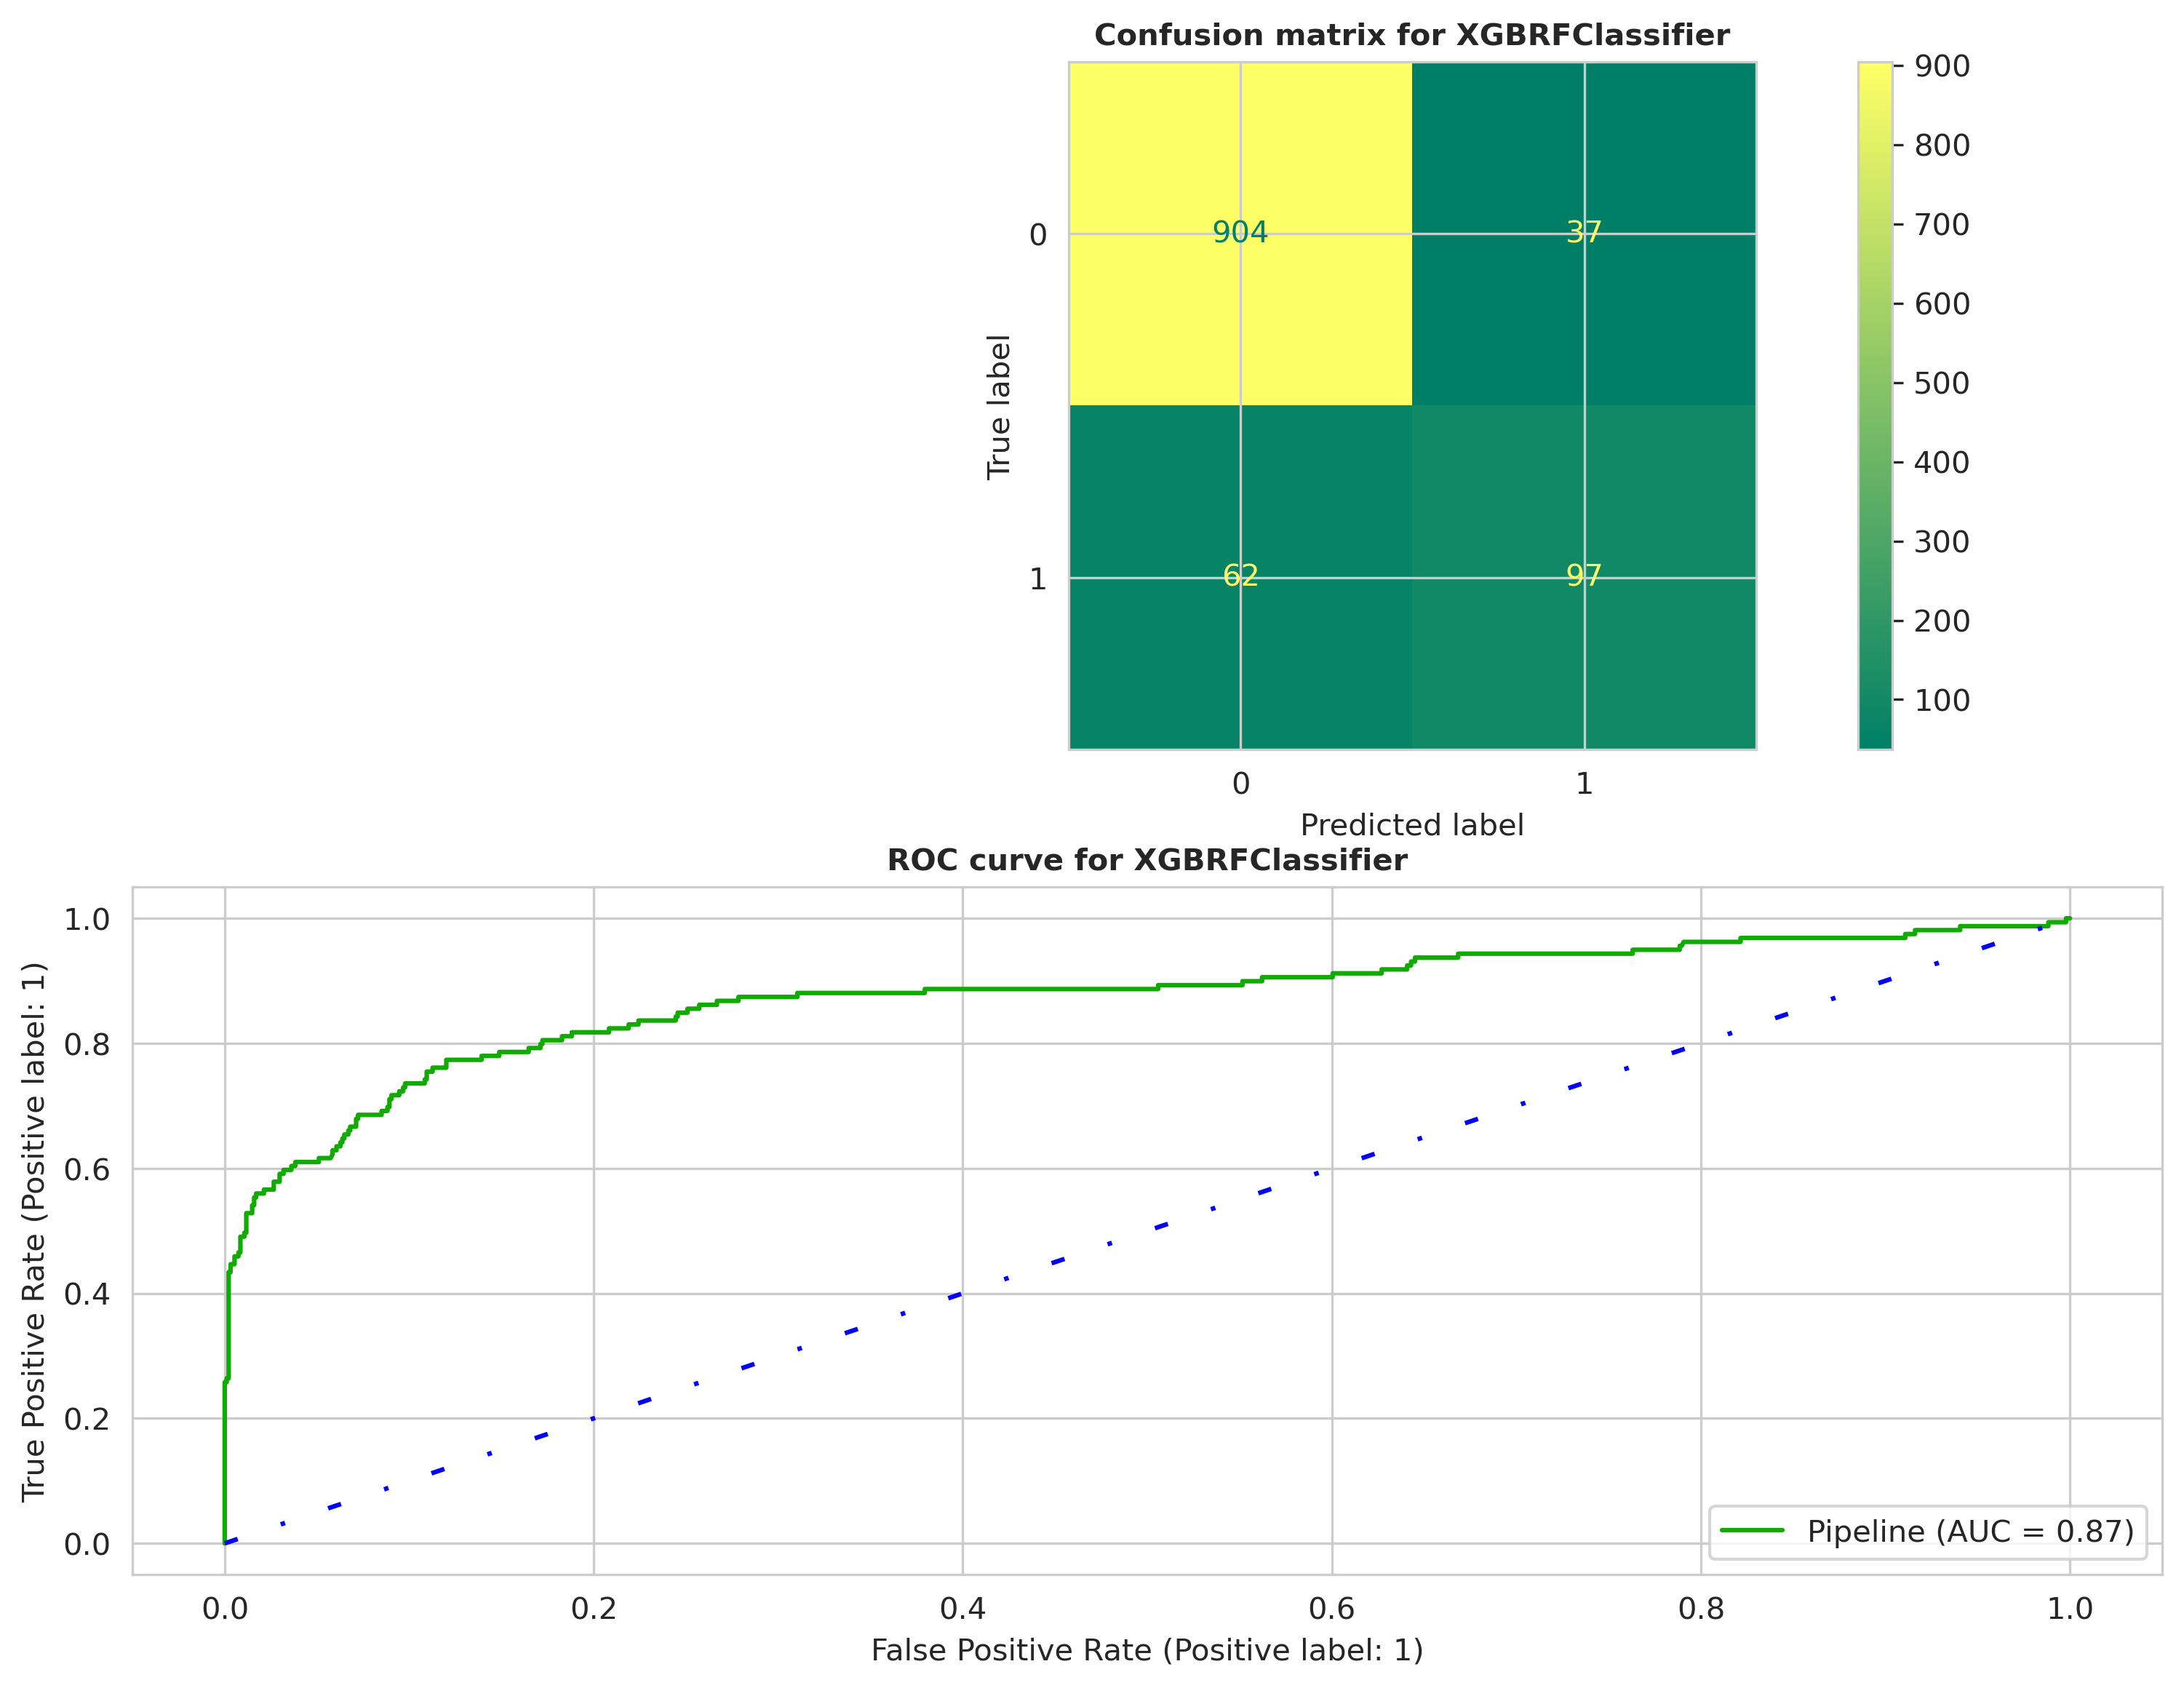

In [94]:
xgb_rf = xgboost.XGBRFClassifier(booster='gbtree', random_state=SEED)
param_grid_xgb = {
            'xgbrfclassifier__n_estimators': [100, 200, 300],
            "xgbrfclassifier__learning_rate": [0.01, 0.05, 0.10, 0.5, 1.0],
            "xgbrfclassifier__max_depth": [3, 5, 10],
            "xgbrfclassifier__min_child_weight": [1, 3, 5]
}

tuning_model(xgb_rf, param_grid_xgb, X_res, X_test, y_res, y_test)

##### Class Weighting

In [66]:
class_counts = y_train.value_counts()
ratio = int(class_counts[0] / class_counts[1])
ratio

5

accuracy_score: 0.9145454545454546
precision_score: 0.7124183006535948
recall_score: 0.6855345911949685
f1_score: 0.6987179487179487
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       941
           1       0.71      0.69      0.70       159

    accuracy                           0.91      1100
   macro avg       0.83      0.82      0.82      1100
weighted avg       0.91      0.91      0.91      1100



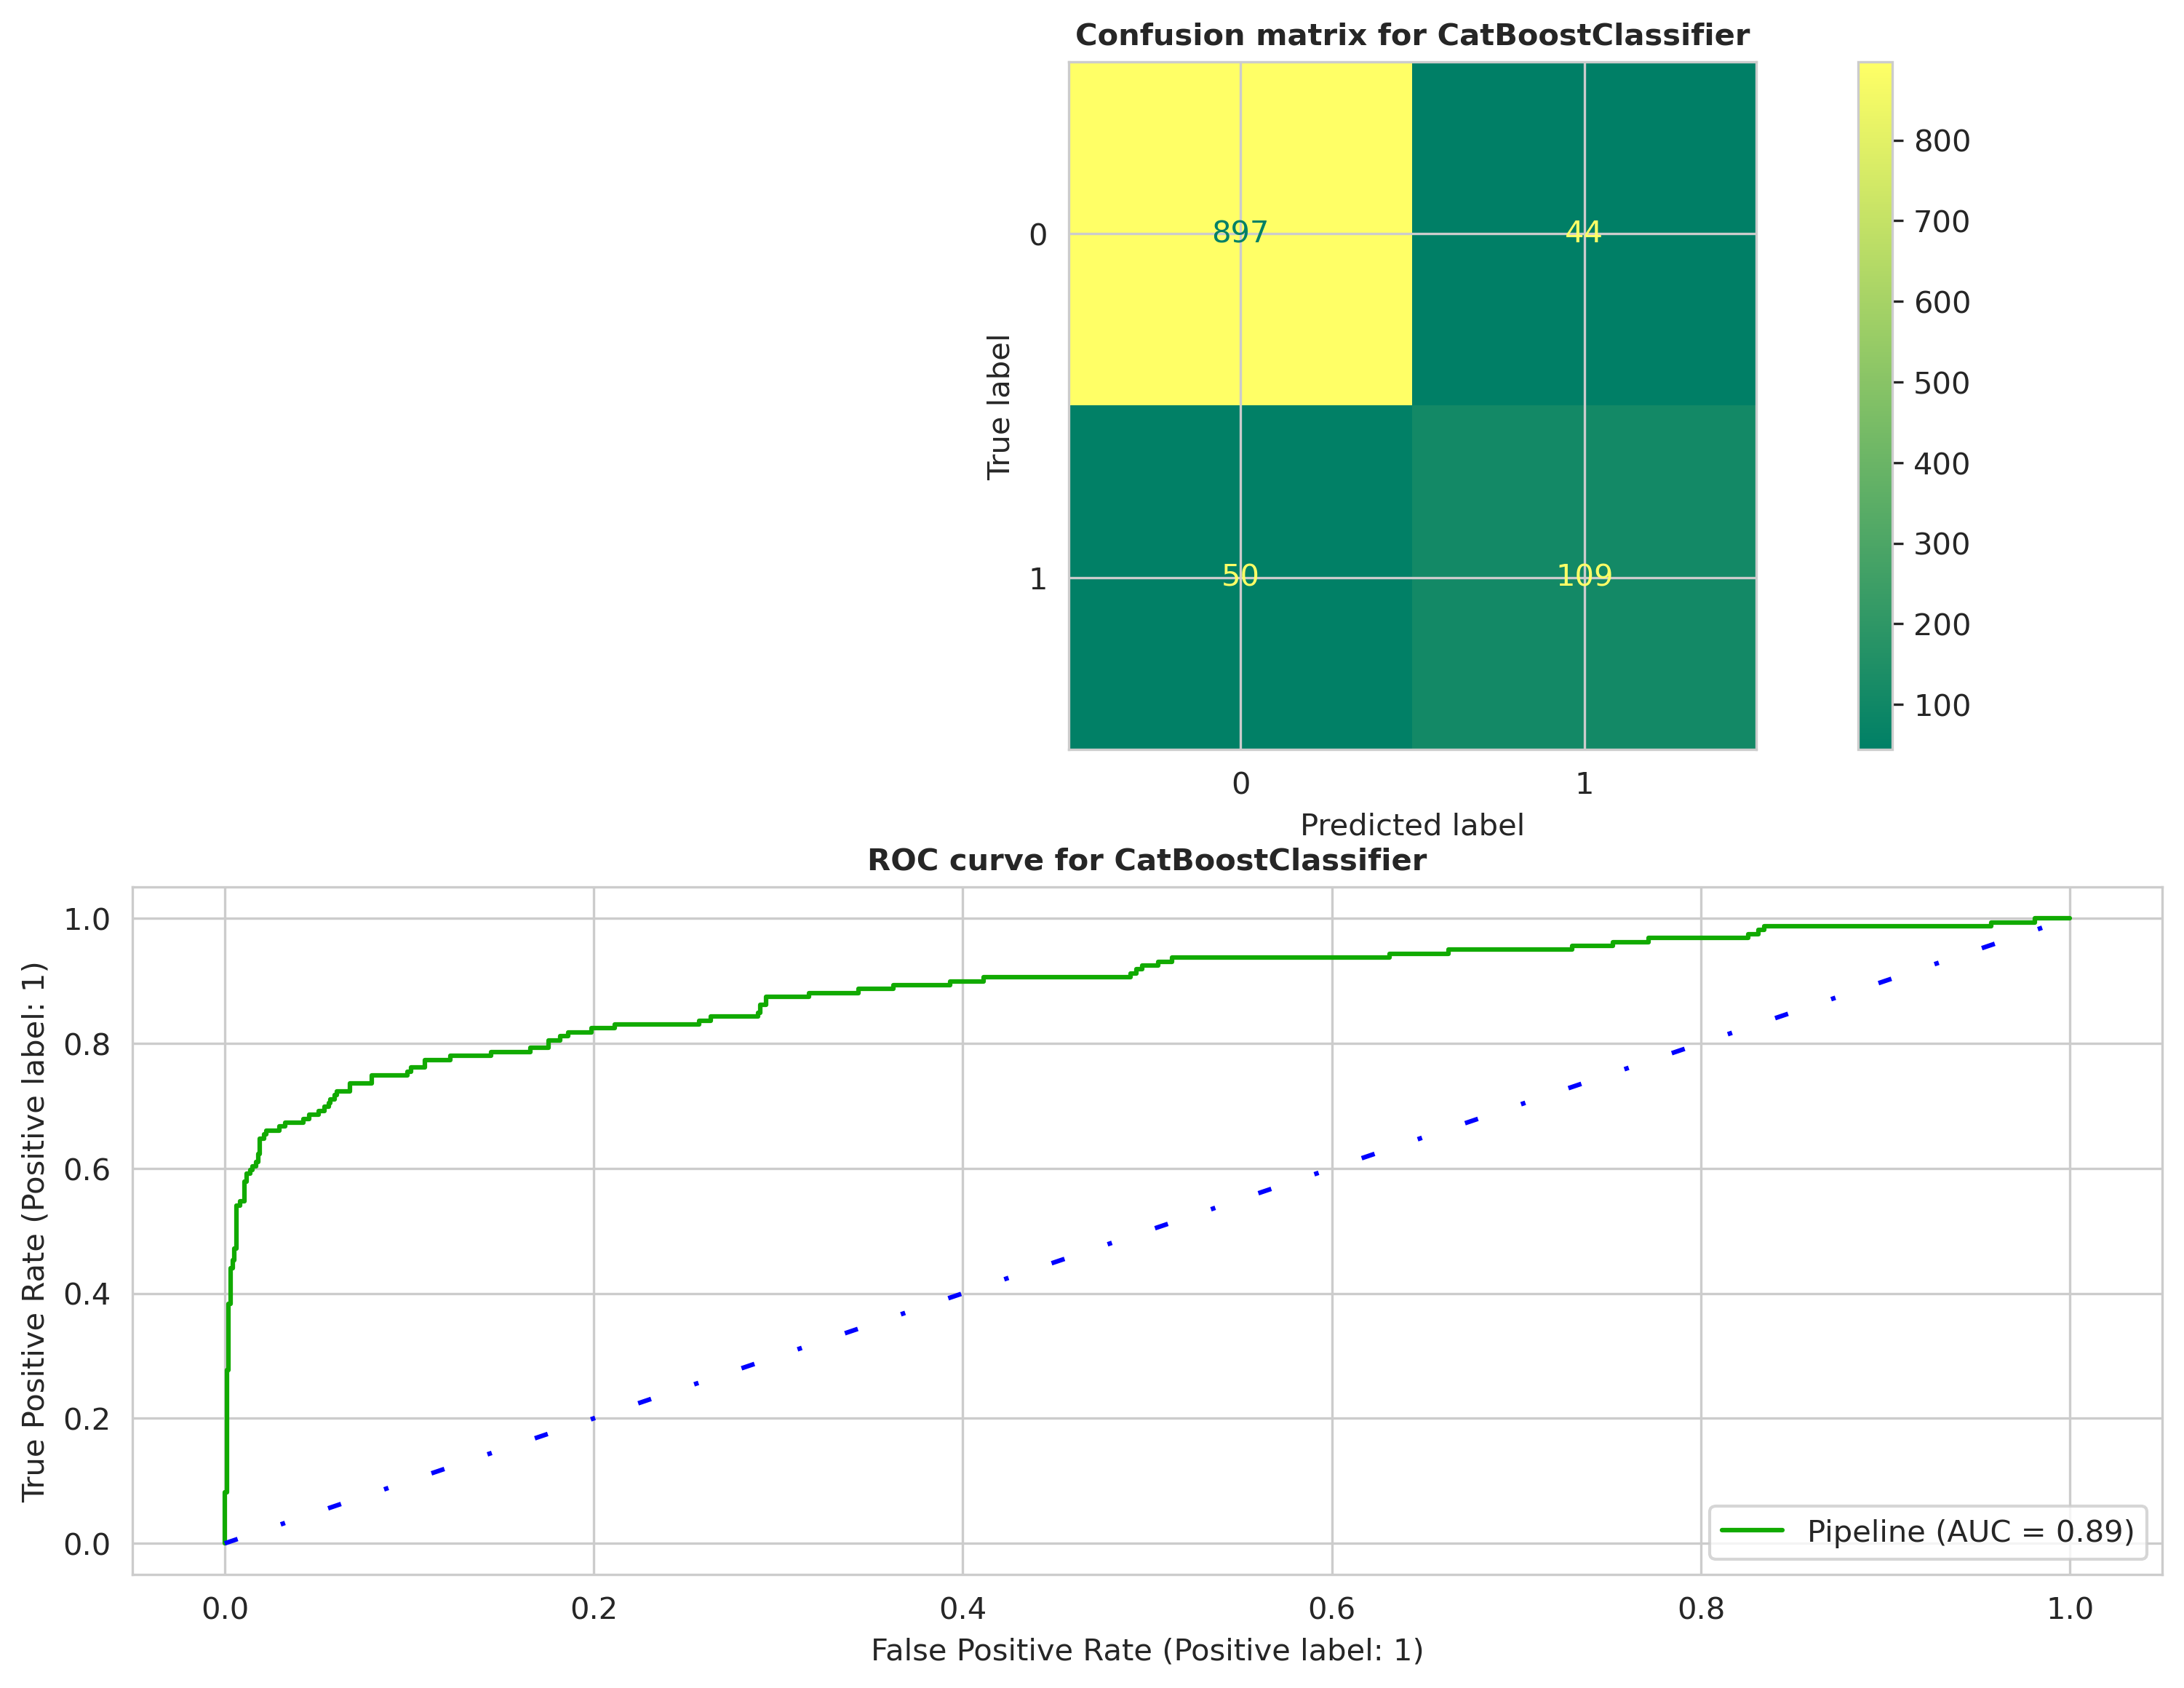

In [93]:
cat = catboost.CatBoostClassifier(learning_rate=0.01, class_weights={0: 1, 1: 5}, verbose=0, random_seed=SEED) 
pipeline = make_pipeline(preproccessor, cat)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

for metric in metrics:
    if accuracy_score:
        print(f'{metric.__name__}: {metric(y_test, y_pred)}')
    else:
        print(f'{metric.__name__}: {metric(y_test, y_pred, average="macro")}')
print(classification_report(y_test, y_pred))

fig, axes = plt.subplots(2, 1, dpi=300)
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)    
axes[0].set_title(f'Confusion matrix for {pipeline[1].__class__.__name__}', fontsize=10, fontweight='bold')
ConfusionMatrixDisplay(conf_mat).plot(ax = axes[0], cmap="summer")

axes[1].set_title(f'ROC curve for {pipeline[1].__class__.__name__}', size=10, weight='bold')
RocCurveDisplay.from_estimator(pipeline, X_test, y_test, color="#1a0", ax=axes[1])
axes[1].plot([0, 1], color='b', linestyle=(0, (3, 10, 1, 10)))

accuracy_score: 0.9172727272727272
precision_score: 0.7428571428571429
recall_score: 0.6540880503144654
f1_score: 0.6956521739130436
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       941
           1       0.74      0.65      0.70       159

    accuracy                           0.92      1100
   macro avg       0.84      0.81      0.82      1100
weighted avg       0.91      0.92      0.92      1100



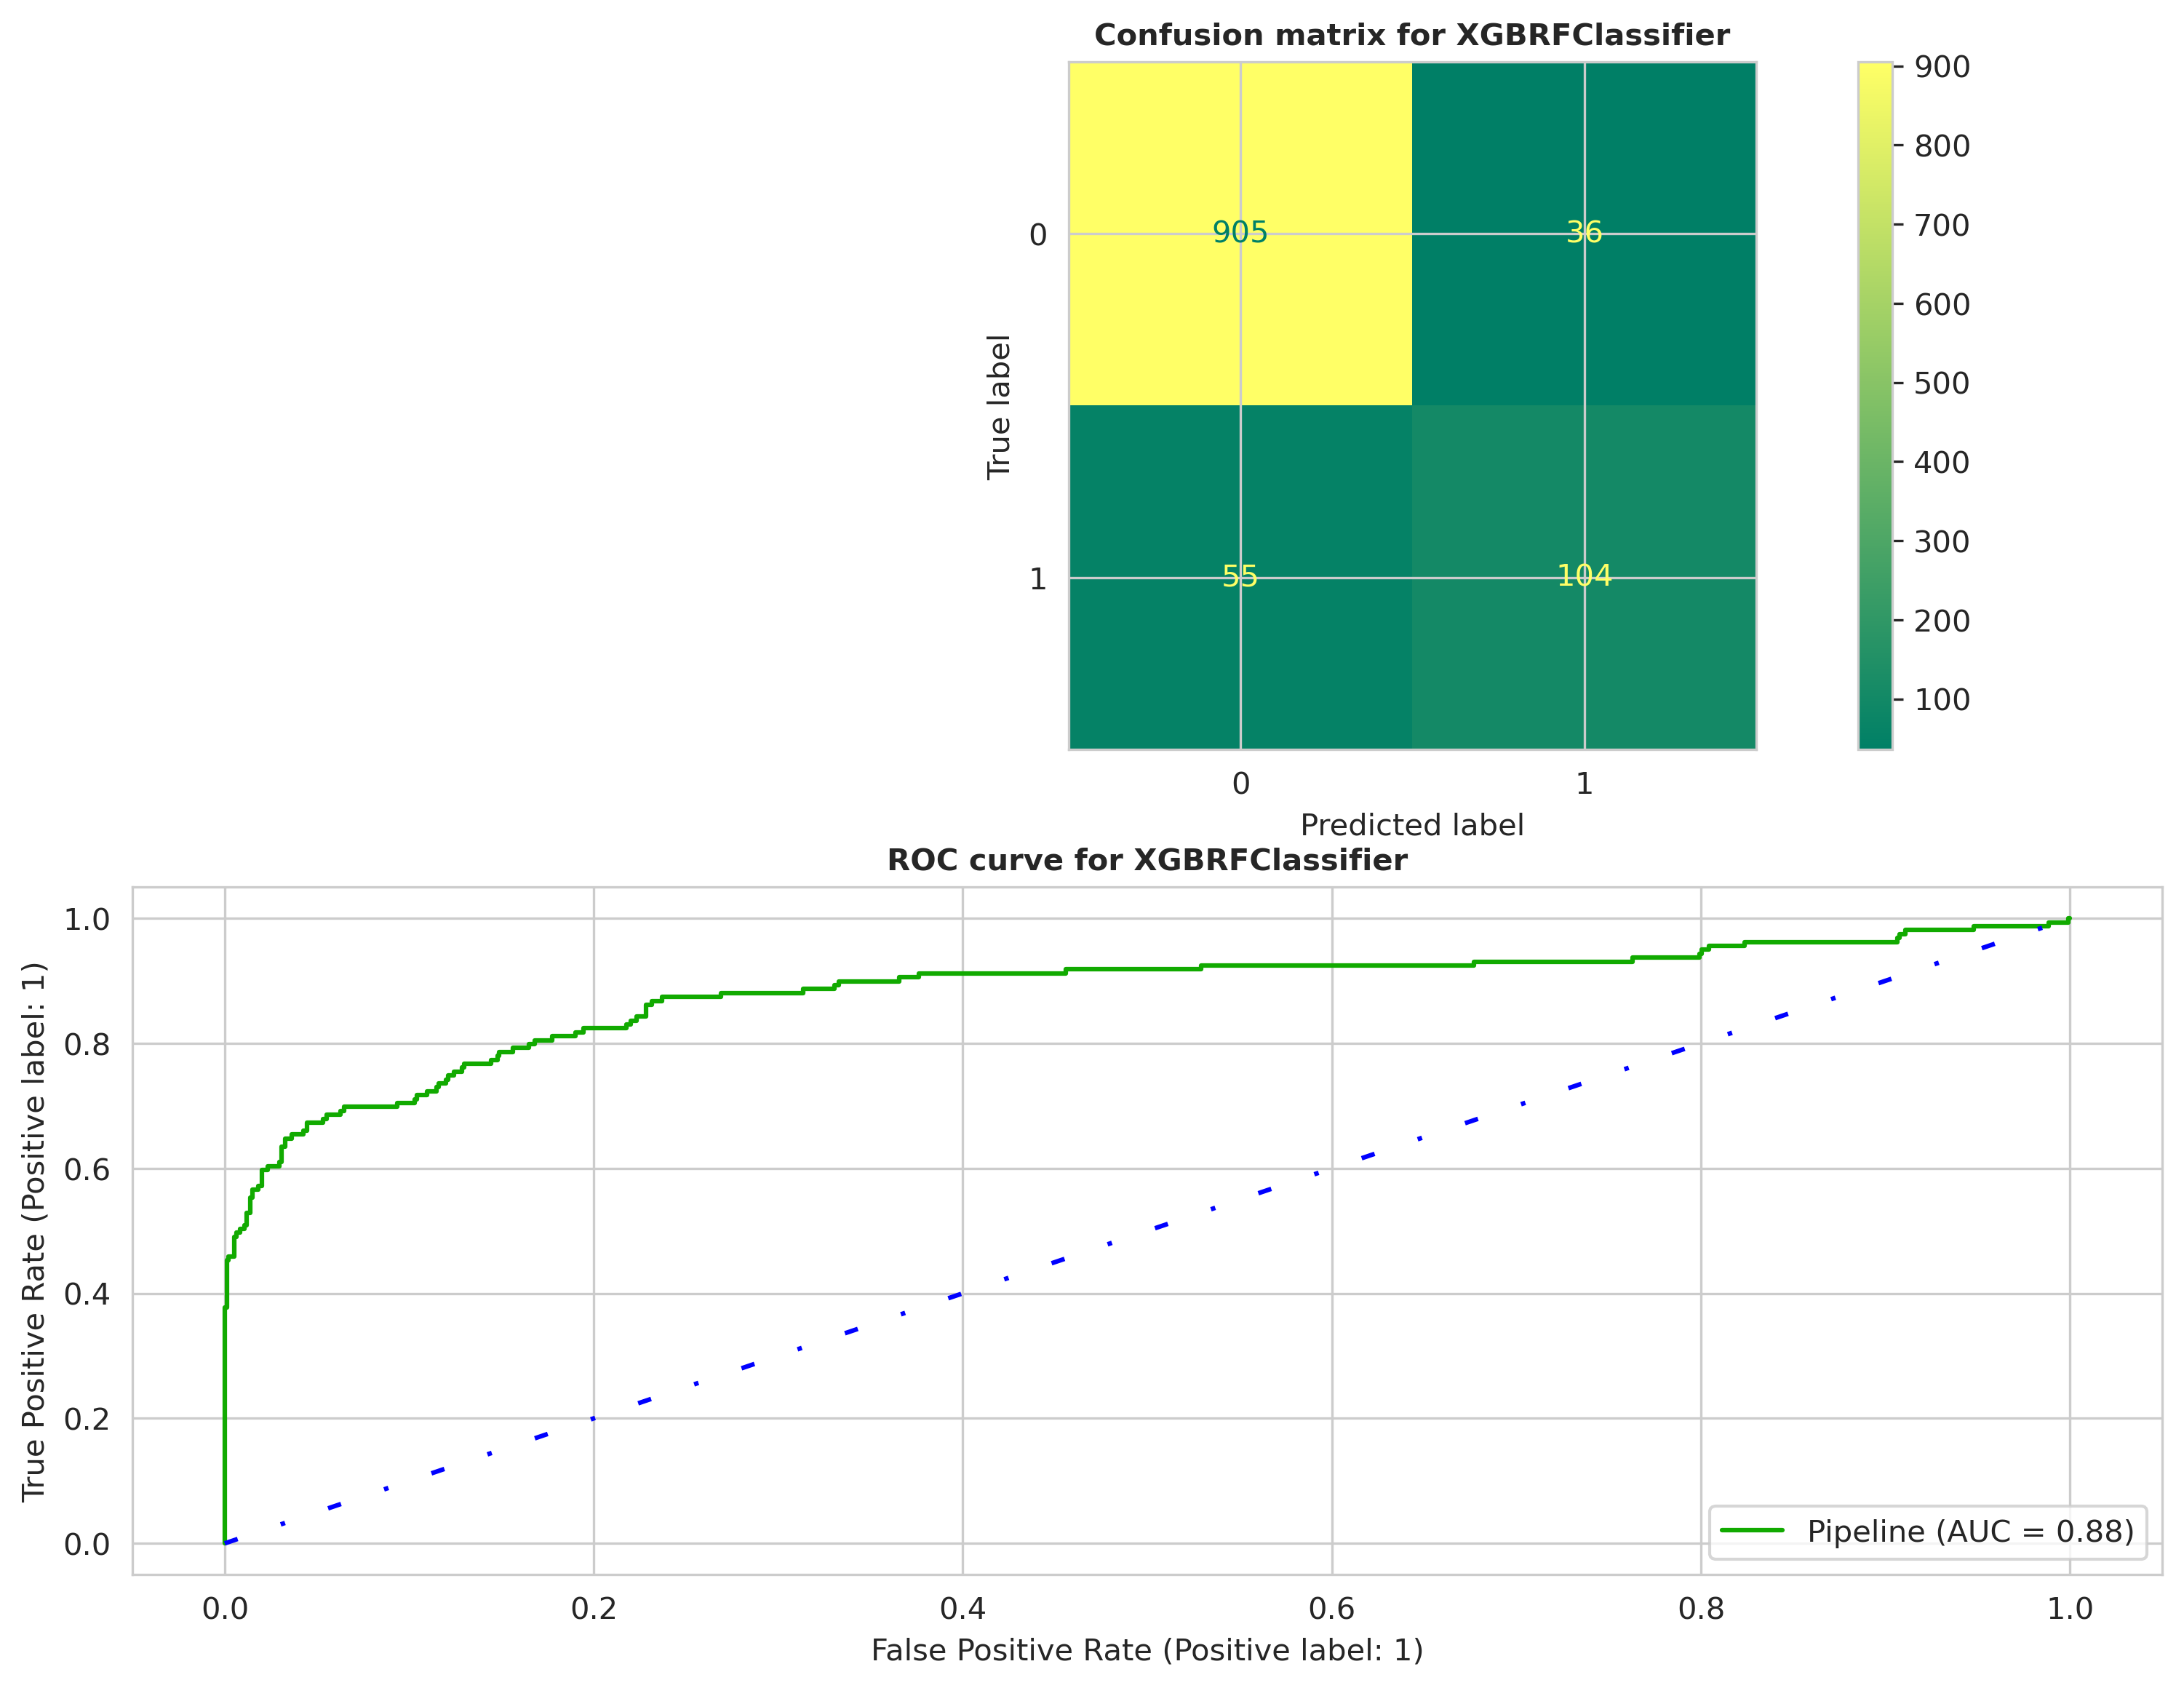

In [100]:
xgb_rf = xgboost.XGBRFClassifier(booster='gbtree', learning_rate=0.05, scale_pos_weight=5, random_state=SEED)
pipeline = make_pipeline(preproccessor, xgb_rf)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

for metric in metrics:
    if accuracy_score:
        print(f'{metric.__name__}: {metric(y_test, y_pred)}')
    else:
        print(f'{metric.__name__}: {metric(y_test, y_pred, average="macro")}')
print(classification_report(y_test, y_pred))

fig, axes = plt.subplots(2, 1, dpi=300)
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)    
axes[0].set_title(f'Confusion matrix for {pipeline[1].__class__.__name__}', fontsize=10, fontweight='bold')
ConfusionMatrixDisplay(conf_mat).plot(ax = axes[0], cmap="summer")

axes[1].set_title(f'ROC curve for {pipeline[1].__class__.__name__}', size=10, weight='bold')
RocCurveDisplay.from_estimator(pipeline, X_test, y_test, color="#1a0", ax=axes[1])
axes[1].plot([0, 1], color='b', linestyle=(0, (3, 10, 1, 10)))

The classification models did not became much better even after classes were balanced. Maybe I did something wrong. I tried different algorithms for over and undersampling from `imblearn` package but the results were the quiet same. And tuning some hyperparameters did not improve models. I only could say that training model on oversampled data allows to classify the minor class more precise.

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**